# <u> Initialization

## Imports, definitions, and functions

In [1]:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt

import seaborn as sns

from tkinter import filedialog
from tkinter import *

import math

#______________________________________________________________________________________________________________

# Define some important dictionaries of chemical information

   # Diffusion coefficients in um^2/msec, all assumed at 25C; all ions are in ion(charge) notation, sign is assumed
   # Taken from Li & Gregory 1974 primarily
diffusion_const = {'H(I)': 9310, 'OH(I)': 5270, 'Cl(I)': 2030, 'Na(I)': 1330,\
                   'Fe(II)': 719, 'Fe(III)': 607, \
                   'HS(I)': 1730, 'HSO4(I)': 1330, 'SO4(II)': 1070, \
                   'HCO3(I)': 1180, 'CO3(II)': 955, \
                   'H2PO4(I)': 846, 'HPO4(II)': 734, 'PO4(III)': 604}

dissociate_species = {'FeCl2': {'Fe(II)': 1, 'Cl(I)':2}, \
                      'Na2S': {'Na(I)':2, 'HS(I)': 1, 'OH(I)': 1}, \
                      'Na2HPO4': {'Na(I)': 2, 'HPO4(II)': 1}, \
                      'Na2CO3': {'Na(I)': 1, 'CO3(II)': 1}, \
                      'HAuCl4': {'Au(III)': 1, 'H(I)': 1, 'Cl(I)': 4}, \
                      'Na2S2O3': {'Na(I)': 2, 'S2O3': 1}, \
                      'NaBH4': {'Na(I)': 1, 'BH4': 1}, \
                      'Glucose': {'', ''},\
                      'pH':{'H(I)': 1}}

pka = {'HS(I)': 12.92, 'H2S': 7.0, \
       'HPO4(II)': 12.67, 'H2PO4(I)': 7.21, 'H3PO4': 1.97, \
       'H2CO3': 10.3,'HCO3(I)': 6.35}

ksp = {}

charge_valency = {'H(I)': 1, 'OH(I)': -1, 'Cl(I)': -1, 'Na(I)': 1,\
                  'Fe(II)': 2, 'Fe(III)': 3, \
                  'HS(I)': -1, 'HSO4(I)': -1, 'SO4(II)': -2, \
                  'HCO3(I)': -1, 'CO3(II)': -2, \
                  'H2PO4(I)': -1, 'HPO4(II)': -2, 'PO4(III)': -3, \
                  'Au(III)': 3, 
                 }



#______________________________________________________________________________________________________________


def new_channel(height, width, length):
    '''
    Produces and sets global values for a generic, rectangular channel with no-slip boundary condition at walls
    '''
    global channel_slice, wall_mask, channel_length
    
    if (length<width) or (length<height):
        print("Check correct placement and value of dimensions. Should be in microns.")
        print("Default length of 15,000 microns is being used.")
        channel_length = 15000
    else:
        channel_length = length
    
    channel_slice = np.zeros((height+2, width+2))
    wall_mask = np.ones((height+2, width+2))    
    
    # Should make this adjustable in the future, but hard-coded for now
    boundary_slip_value = 0.0

    w_dim = channel_slice.shape[1]
    h_dim = channel_slice.shape[0]

    # Set side walls to 'boundary_slip_value'
    for h in range(h_dim):
        wall_mask[h, 0] = boundary_slip_value
        wall_mask[h, w_dim-1] = boundary_slip_value
    # Set top and bottom of channel to boundary_slip_value
    wall_mask[0, ::] = boundary_slip_value
    wall_mask[h_dim-1, ::] = boundary_slip_value

    
#______________________________________________________________________________________________________________


def estimate_pressure_drop(flow_rate, wall_mask, homogenous=True, slice_distances=[], slice_masks=[]):
    '''
    Calculation taken from "Physical Properties of PDMS (Polydimethylsiloxane)
    Microfluidic Devices on Fluid Behaviors: Various Diameters and Shapes of 
    Periodically-Embedded Microstructures", Roh et al 2016.
    
    Assumes mean velocity and solves for pressure drop (simple algebra).
    
    INPUT:
        flow_rate (uL/min)- from syringe pump; other settings need separate consideration
        channel_slices (np.array)- if an interpolation between channel slices is considered,
    OUTPUT:
        pressure_drop- in mbar/mm
    '''
    
    if 'channel_length' in globals():
        length = channel_length
    else:
        print("Please establish a new_channel(h,w,l) or define a 'channel_length'")
    
    # All values are adjusted to SI units (m, Pa, m/sec)
       # Subtract 2 for wall boxes
    height = wall_mask.shape[0]-2
    width = wall_mask.shape[1] -2
        # Assume viscosity (kg/m-sec) is pure water
    viscosity = .001
    
    '''
       # Double flow due to 2 syringes at that rate, and adjust from uL/min to m/sec
       #   1 ul/min = 10^8 um^3/min    
    chan_area = np.sum(wall_mask) 
    chan_vol = chan_area * length # in um^3
       # v-bar = Area / volumetric-flow-rate
    adjusted_flow = 2 * (flow_rate * 10**8) * (1/60)
       # Units are weird here, but this is sec/channel-transit
       # Adjust for length of channel in meters / 1-channel-transit * sec
    average_velocity = (length/ 10**6) / (chan_vol / adjusted_flow)

    pa_pressure_drop = average_velocity * (12 * viscosity * (length/10**6)**2) / (height/10**6)**3
       # Change units from Pa to mbar/mm for Poisuille form
       # Divide by 100 to get Pa->mbar and divide by length/1000 to get 'per mm' as length should be in um
    pressure_drop = pa_pressure_drop / 100 / (length/1000)
    '''
    # Hard-coded for pressure drop in a 70x500x15000 um rectangular microchannel
    # Will revise when time permits. Resistance calculation is simple.
    total_pressure_drop = round((flow_rate * 0.19208019) -0.01375857, 3)
    pressure_drop = round(total_pressure_drop / (length/1000), 2)
    
    if not homogenous:
        # Placeholder
        # This will be complicated, but take each 
        pass 
    
    return pressure_drop

#______________________________________________________________________________________________________________


def equilibrate_flow_slice(parameter_tuple, channel_slice, wall_mask, max_iterations = 1000, \
                          accuracy_threshold = 0.01, run_to_max=False, show_print = False):
    '''
    INPUTS:
        parameter_tuple- (pressure_drop(mbar/mm), 
                          slice_depth(um, usually 1 um), 
                          time_step (usec, needs to be small or solution becomes unstable; usually 1),
                          density (g/cm^3),
                          viscosity (mPa* sec))
        channel_slice- numpy array of channel cross-section; values represent flow in each cell (um/msec)
        viscosity- single float value or numpy array the same size as channel_slice
                NOTE: if dynamic viscosity is being considered (an array is passed rather than a single number), 
                    strange effects are possible and the output should be monitored closely.
        wall_mask- array the size and shape of 'channel_slice', with zeroes at boundaries and ones at flow regions
        max_iterations- set a hard cutoff to avoid extremely long calculations for high flow rates 
                (not really an issue on rectangular channels, but will likely occur with arbitrary wall geometries)
        accuracy_threshold- numerical percentage of difference between calculations that will be called 'good enough'
    ACTION:
        copy_slice- a working version of channel_slice to store prior state
        output_slice- the last-calculated update
    OUTPUT:
        output_slice- the last-calculated update; FLOWRATES ARE IN UNITS OF mm/sec
    '''
    global omega
    
    #Make copies to alter
    working_slice = np.copy(channel_slice)
    output_slice = np.copy(channel_slice)
    
    #Split-out parameters and handle variable viscosity argument
    pressure_drop, slice_depth, time_step, density, _ = parameter_tuple
    if type(parameter_tuple[-1])=='float' or type(parameter_tuple[-1])=='int':
        viscosity = parameter_tuple[-1]
        variable_visc = False
    else:
        viscosity = parameter_tuple[-1]
        variable_visc = True
    
    #Calculate gamma and omega for calculations
    gamma = 0.1 * pressure_drop * time_step / density
    if variable_visc:
        multiplier = (time_step / (density * slice_depth**2))
        omega = np.ones((channel_slice.shape[0], channel_slice.shape[1])) * multiplier
        omega =  np.multiply(omega, viscosity)
    else:
        omega = (time_step / (density * slice_depth**2)) * viscosity
    
    # Iterate through until an equilibrium is reached
        # Initialize some variables
    iterations = 0
    max_flow = 0
    min_flow = 0
    average_flow = 0
    slice_height = channel_slice.shape[0]
    slice_width = channel_slice.shape[1]
    
    #ALL OF THE FOLLOWING IS IF VISCOSITY IS CONSTANT------------>
    
    # Run through each cell, for each iteration
    while iterations < max_iterations:
        for h in range(1,slice_height-1):
            if variable_visc:
                for w in range(1,slice_width-1):
                    # There's a mixed conversion from mm to um; divide by 1000 to adjust
                    this_calc = (working_slice[h,w] * round(1-4*omega[h,w],6) + omega[h,w] * \
                    round(working_slice[h+1,w] + working_slice[h-1,w] + working_slice[h,w+1] + working_slice[h,w-1], 6) -\
                    gamma)
                    output_slice[h,w] = this_calc
            else:
                for w in range(1,slice_width-1):
                    # There's a mixed conversion from mm to um; divide by 1000 to adjust
                    this_calc = (working_slice[h,w] * round(1-4*omega[h,w],6) + omega[h,w] * \
                    round(working_slice[h+1,w] + working_slice[h-1,w] + working_slice[h,w+1] + working_slice[h,w-1], 6) -\
                    gamma)
                    output_slice[h,w] = this_calc
        
        output_slice = np.multiply(output_slice, wall_mask)
        working_slice = output_slice
        
        this_max = np.amax(output_slice)
        this_min = np.amin(output_slice)
        this_average = np.average(output_slice)
        
        if ((this_average - average_flow) < (accuracy_threshold * average_flow)) and (this_max-max_flow)!=0:
            equilibrium_met = True
        else:
            equilibrium_met = False
            
        max_flow = this_max
        min_flow = this_min
        average_flow = this_average     
        
        iterations += 1
        if run_to_max:
            equilibrium_met = False
        
        if ((iterations == max_iterations) or (equilibrium_met)) and show_print:
            print("Done in ", iterations, " iterations.")
            print("Max. flow:  ", max_flow)
            print("Min. flow:  ", min_flow)
            print("Avg. flow:  ", average_flow)
            
            plt.plot(output_slice)
            plt.show()
            
            break
            
    # >---------------------------->END CONSTANT VISCOSITY SECTION
    
    return output_slice


#______________________________________________________________________________________________________________

    
def simple_1D_diffusion(wall_mask, diffusion_coefficient, reactant_side, flow_rate, \
                        return_slices = [0.001, 0.1, 0.5, 0.8]):
    '''
    INPUT:
        wall_mask- numpy array with 0 at wall-like boundary cells and 1's everywhere else
        diffusion_coefficient- in um^2/sec
        reactant_side- 'metal-side' or 'anion-side' (left or right side of channel; )
        flow_rate- used to calculate diffusional distance
        return_slices- percent of channel_length slices should be made for 
    OUTPUT:
        diffusion_slice- regions
    '''
    
    # Check to make sure channel length has been defined
    if 'channel_length' in globals():
        pass
    else:
        print("Please establish a new_channel(h,w,l) or define a 'channel_length'")
    
    channel_area = np.sum(wall_mask)
    channel_volume = channel_area * channel_length

    height = wall_mask.shape[0]
    width = wall_mask.shape[1]
    half_width = int(round(width/2))

    # Convert 'return_slices' list of percent-of-length-down-channel values into actual lengths
    return_distances = [int(round(channel_length*number)) for number in return_slices]
    # Create a list to hold the return slices
    diffusion_slice_list = []

    # doubled due to 2 syringes and same channel area from inlets to main channel, 
    # and convert from uL/min to um^3/sec to sec/channel slice
    adjusted_flow = 2 * flow_rate * (10**8) * (1/60)
    time_per_channel_um = channel_area / adjusted_flow

    # Define diffusional direction (indices) based on 'reactant_side'
    # Create a list of 'step_indices' from boundary to channel wall
    if reactant_side == 'metal-side':
        width_start = half_width+1
        step_indices = range(width_start, width-1)
    elif reactant_side == 'anion-side':
        width_start = half_width
        step_indices = range(width_start, 0, -1)
    else:
        print("Choose either 'metal-side' (left channel) or 'anion-side' (right channel).")

    for distance_down_channel in return_distances:
        # Initialize empty channel
        diffusion_slice = np.zeros((height, width))
        distance_from_boundary = 0
        this_diffusional_distance = round(distance_down_channel * time_per_channel_um * diffusion_coefficient)
        if reactant_side == 'metal-side':
            this_diffusional_boundary = width_start + this_diffusional_distance
        elif reactant_side == 'anion-side':
            this_diffusional_boundary = width_start - this_diffusional_distance
        this_diffusive_flux = diffusion_coefficient
        
        for width_index in step_indices:
            #This is deceptively simple; 'diffusion_coefficient' is in units of um^2/sec, which symmetry lets us assume is 
            #   equivalent to um/sec. Each step away from diffusional boundary up to 'this_diffusional_boundary' lowers the
            #   possible flux by 1um/time-it-took-to-get-to-that-section-of-channel
            if this_diffusive_flux > 0:
                this_diffusive_flux -= 1
            this_diffusive_flux -= 1
            #Cheap way of defining diffusion direction is to hard-code it as below. In the future, a more mathy 
            #   that takes into account the concentration gradient should be implemented
            if reactant_side == 'metal-side':
                if width_index >= this_diffusional_boundary:
                    this_diffusive_flux = 0
                else:
                    pass
            elif reactanat_side == 'anion-side':
                if width_index <= this_diffusional_boundary:
                    this_diffusive_flux = 0
                else:
                    pass
            diffusion_slice[::, width_index] = this_diffusive_flux
            distance_from_boundary += 1
        # Re-apply the 'wall_mask' to enforce boundary conditions==0; only matters if non-symetric boundaries are used
        #   and once actual diffusion models are considered (i.e. not 1D steps away from the boundary)
        diffusion_slice_list.append(np.multiply(diffusion_slice, wall_mask))
        
    print("At ", return_distances[0], " um")
    f, ax = plt.subplots(figsize=(50, 7))
    plt.imshow(diffusion_slice_list[0], interpolation= 'nearest')
    plt.show()

    print("At ", return_distances[1], " um")
    f, ax = plt.subplots(figsize=(50, 7))
    plt.imshow(diffusion_slice_list[1], interpolation= 'nearest')
    plt.show()

    print("At ", return_distances[2], " um")
    f, ax = plt.subplots(figsize=(50, 7))
    plt.imshow(diffusion_slice_list[2], interpolation= 'nearest')
    plt.show()

    print("At ", return_distances[3], " um")
    f, ax = plt.subplots(figsize=(50, 7))
    plt.imshow(diffusion_slice_list[3], interpolation= 'nearest')
    plt.show()
    
    return diffusion_slice_list, return_distances


#______________________________________________________________________________________________________________


def pseudo_3d_model(flow_rate, wall_mask, flow_slice, \
                    metal_side_reactants, anion_side_reactants,\
                    precipitation = False, \
                    flow_equilibrate = False, \
                    return_slices = [0.001, 0.01, 0.1, 0.5, 0.66667], \
                    chem_return = ['H(I)', 'Fe(II)', 'HS(I)', 'Cl(I)', 'Na(I)'], \
                    specify_species = []
                   ):
    
    # Convert 'return_slices' list of percent-of-length-down-channel values into actual lengths
    return_distances = [int(round(channel_length*number)) for number in return_slices]

    # Specify and initialize some channel parameters
    channel_area = np.sum(wall_mask)
    channel_volume = channel_area * channel_length
    height = wall_mask.shape[0]
    width = wall_mask.shape[1]
    half_width = int(round(width/2))

    # doubled due to 2 syringes and same channel area from inlets to main channel, 
    #    and convert from uL/min to um^3/sec to sec/channel-slice to msec/channel-slice
    adjusted_flow = 2 * flow_rate * (10**8) * (1/60)
    um_per_msec = channel_area / adjusted_flow * 1000
    
    # Create an array of transit times for each cell based on the velocity from 'flow_slice'
    time_step_slice = np.zeros((height,width))
    for h in range(height):
        for w in range(width):
            this_flow = flow_slice[h,w]
            if this_flow > 10e-4:
                time_step_slice[h,w] = 1/this_flow
            else:
                time_step_slice[h,w] = 0

    # Initialize a list to collect the models that will be returned
    return_models = []

    # Convert from Mol/L to mMol/um^3
    mol_to_um = 10e-13

    # If calculated flow is less than the average speed/channel slice, assume contribution is zero
    #   Why? the 'adjusted_flow' is used as a clock to govern later time-distance calculations and time steps
    flow_contribution_mask = np.copy(flow_mask)   #Divide by 1000 to convert from mm/sec to um/sec
    for h in range(height):
        for w in range(5, (width-5)):
            this_diff = flow_contribution_mask[h,w] / um_per_msec
            if this_diff > 0:
                flow_contribution_mask[h,w] = this_diff
            else:
                flow_contribution_mask[h,w] = 0
    flow_dilution_volume = np.add(np.ones((height, width)), flow_contribution_mask)
       
    # Take the reactants, dissociate them into species, and assign concentrations
       # Collect all tracked species
    all_species = []
       # Do the metal-side reactants
    metal_flow = {}
    metal_flow_species = list(metal_side_reactants.keys())
    for species in metal_flow_species:
        these_keys = list(dissociate_species[species].keys())
        for solute in these_keys:
            all_species.append(solute)
            if species == 'pH' :
                #conc = (10**(-1* metal_side_reactants[species])) * mol_to_um
                conc = metal_side_reactants[species]
            else:
                conc = metal_side_reactants[species] * dissociate_species[species][solute] * mol_to_um
            try:
                metal_flow[solute]+= conc
            except KeyError:
                metal_flow.update( {solute: conc} )
       # Do the anion-side reactants
    anion_flow = {}        
    anion_flow_species = list(anion_side_reactants.keys())
    for species in anion_flow_species:
        these_keys = list(dissociate_species[species].keys())
        for solute in these_keys:
            all_species.append(solute)
            if species == 'pH':
                #conc = (10**(-1* metal_side_reactants[species])) * mol_to_um
                conc = anion_side_reactants[species]
            else:    
                conc = anion_side_reactants[species] * dissociate_species[species][solute] * mol_to_um #TESTING a drop of molar quantities
            try:
                anion_flow[solute]+= conc
            except KeyError:
                anion_flow.update( {solute: conc} )   

    # Make masks to aid in diffusing and adjusting concentrations
    anion_mask = np.zeros((height,width))
    anion_mask[::, (half_width):(width-5)] = 1
    metal_mask = np.zeros((height,width))
    metal_mask[::, 5:half_width] = 1

    negative_valency = [np.zeros((height, width)) for i in range(len(return_distances))]
    positive_valency = [np.zeros((height, width)) for i in range(len(return_distances))]

    print("All species to be run: ")
    print(all_species)
    print()

    if len(specify_species) > 0:
        all_species = specify_species    
    
    return_names = []
    for species in all_species:
        print()
        print("Starting on ", species)

        # 'simplest' case; run if precipitation and flow equilibration are not considered, 
        #   and this 'species' has not been calculated yet
        if (species not in return_names) and (not precipitation) and (not flow_equilibrate):
            if species in chem_return:
                return_names.append(species)

            current_index = 0
            initial_slice = np.zeros( (height, width) )
            working_slice = np.zeros( (height, width) )
            flow_addition = np.zeros( (height, width) )
            # delta_T should be <= delta_distance^2/ (2*Diffusion_constant) for stability of FTCS method
            # 'stable_delta_time' is in msec
            distance_step = 1   #Hard-coded to 1um; all the code is set up for this step size
            msec_diff_const = diffusion_const[species]/1000
            stable_delta_time = distance_step**2 / (2 * msec_diff_const)
        
            try:
                anion_flow_contribution = np.multiply(np.multiply(anion_mask, flow_contribution_mask), anion_flow[species])
                flow_addition = np.add(flow_addition, anion_flow_contribution)
                anion_include = True
                anion_max = anion_flow[species]
            except KeyError:
                anion_include = False
                anion_max = 0
                pass

            try:
                metal_flow_contribution = np.multiply(np.multiply(metal_mask, flow_contribution_mask), metal_flow[species])
                flow_addition = np.add(flow_addition, metal_flow_contribution)
                metal_include = True
                metal_max = metal_flow[species]
            except KeyError:
                metal_include = False
                metal_max = 0
                pass

            max_conc = max([metal_max, anion_max])

            # Initialize the flow contribution 
            if species in list(anion_flow.keys()):

                anion_fill_slice = np.multiply(anion_mask, anion_flow[species])
                initial_slice = np.add(initial_slice, anion_fill_slice)

            if species in list(metal_flow.keys()):
                metal_fill_slice = np.multiply(metal_mask, metal_flow[species])
                initial_slice = np.add(initial_slice, metal_fill_slice)

            # Only step through until the last slice to be returned
            these_returns = []
            for current_index in range(return_distances[-1]+1):  
                if (current_index % 100)==0:
                    print(current_index)

                for h in range(height):
                    for w in range(5, width-6):
                        # Determine how many time-slices of what duration will result in a stable result
                        # distance is hard-coded to 1um
                        this_time_step = time_step_slice[h,w]

                        if this_time_step < stable_delta_time:
                            alpha = msec_diff_const * (this_time_step/distance_step**2)

                            if (wall_mask[h,w-1]!=0) or (wall_mask[h,w+1]!=0) or (wall_mask[h,w]!=0):
                                #1D solution
                                working_slice[h,w]= alpha * (initial_slice[h,w-1])+ (1-2*alpha)*initial_slice[h,w]+\
                                alpha * initial_slice[h,w+1]
                                '''
                                # Analytical solution to 2D 
                                # To keep array notation conistent, x=height and y=width
                                working_slice[h,w] = alpha * (initial_slice[h+1,w] + initial_slice[h-1,w])\
                                + alpha * (initial_slice[h,w+1] + initial_slice[h,w-1])+(1-4*alpha)*initial_slice[h,w]
                                '''
                        else:
                            number_time_steps = int(np.ceil(this_time_step/stable_delta_time))
                            alt_time_step = this_time_step/number_time_steps
                            alpha = msec_diff_const * (alt_time_step/distance_step**2)
                            for i in range(number_time_steps):
                                if (wall_mask[h,w-1]!=0) or (wall_mask[h,w+1]!=0) or (wall_mask[h,w]!=0):
                                    #1D solution
                                    working_slice[h,w]= alpha * (initial_slice[h,w-1])+ (1-2*alpha)*initial_slice[h,w]+\
                                    alpha * initial_slice[h,w+1]

                # SLICE CONTRIBUTION, DILUTED BY FLOW RATE: np.divide(np.copy(working_slice), flow_dilution_volume)
                #trial_slice = np.divide(np.copy(working_slice), flow_dilution_volume)
                #initial_slice = np.mean([working_slice<max_conc, trial_slice], axis=0)

                initial_slice = np.copy(working_slice)
                # Generate the next initial slice based on this result.
                #   If the metal OR anion inclusion variables are true
                if metal_include and anion_include:

                    initial_slice[::, 0:10] = metal_fill_slice[::, 0:10]
                    initial_slice[::, (width-10):(width-0)] = anion_fill_slice[::, (width-10):(width-0)]

                elif metal_include or anion_include:
                    if metal_include:
                        #initial_slice = np.divide(working_slice, flow_dilution_volume)
                        initial_slice[::, 0:half_width] = metal_fill_slice[::, 0:half_width]
                    if anion_include: 
                        #initial_slice = np.divide(working_slice, flow_dilution_volume)
                        initial_slice[::, half_width:width] = anion_fill_slice[::, half_width:width]

                if (current_index in return_distances) and (species in chem_return):
                    these_returns.append(np.copy(working_slice))
            if (species in chem_return):
                return_models.append(these_returns)
    
    return return_models, return_names, return_distances

#______________________________________________________________________________________________________________




## Functions under development

### Diffusion model- 1D, SliceBySlice, Working_slice/Initial_slice model

delta_T should be <= delta_distance^2/ (2*Diffusion_constant) for stability of FTCS method

In [ ]:
# As of 2021-05-11
# Latest working version of diffusion slice-by-slice, initial_slice/working_slice model
# Timing between 'steps' should be looked at more closely in the future. Conversions of average channel velocity
#   to cell-specific terms may have an error. Diffusional distances are reasonable, but should be larger.
#_________________________________________________________________________________________
flow_mask = np.copy(flow_slice)

metal_side_reactants = {'FeCl2': 1, 'pH': 5}
anion_side_reactants = {'Na2S': 1, 'pH': 11}
flow_rate = 50
precipitation = False
flow_equilibrate = False
return_slices = [0.001, 0.01, 0.1, 0.5, 0.66667]  #[0.001, 0.01, 0.1, 0.5, 0.66667]
chem_return = ['H(I)', 'Fe(II)', 'HS(I)', 'Cl(I)', 'Na(I)']

# Convert 'return_slices' list of percent-of-length-down-channel values into actual lengths
return_distances = [int(round(channel_length*number)) for number in return_slices]

# Specify and initialize some channel parameters
channel_area = np.sum(wall_mask)
channel_volume = channel_area * channel_length
height = wall_mask.shape[0]
width = wall_mask.shape[1]
half_width = int(round(width/2))

# doubled due to 2 syringes and same channel area from inlets to main channel, 
#    and convert from uL/min to um^3/sec to sec/channel-slice
adjusted_flow = 2 * flow_rate * (10**8) * (1/60)
time_per_channel_um = channel_area / adjusted_flow
um_per_msec = (adjusted_flow/channel_area) / 1000
# If calculated flow is less than the average speed/channel slice, assume contribution is zero
#   Why? the 'adjusted_flow' is used as a clock to govern later time-distance calculations and time steps
flow_contribution_mask = np.copy(flow_mask)   #Divide by 1000 to convert from mm/sec to um/sec
for h in range(1,(height-2)):
    for w in range(5, (width-5)):
        this_diff = flow_contribution_mask[h,w] / um_per_msec
        if this_diff > 0:
            flow_contribution_mask[h,w] = this_diff
        else:
            flow_contribution_mask[h,w] = 0
flow_dilution_volume = np.add(np.ones((height, width)), flow_contribution_mask)

# Not used currently, may incorporate in the future; Generate a diffusional geometry model
#diff_model = np.zeros( (height, width, diff_slice_number) )

# Initialize a list to collect the models that will be returned
return_models = []
pos_valence_slices = []
neg_valence_slices = []

# Convert from Mol/L to mMol/um^3
mol_to_um = 10e-13

# Take the reactants, dissociate them into species, and assign concentrations
   # Collect all tracked species
all_species = []
   # Do the metal-side reactants
metal_flow = {}
metal_flow_species = list(metal_side_reactants.keys())
for species in metal_flow_species:
    these_keys = list(dissociate_species[species].keys())
    for solute in these_keys:
        all_species.append(solute)
        if species == 'pH' :
            #conc = (10**(-1* metal_side_reactants[species])) * mol_to_um
            conc = metal_side_reactants[species]
        else:
            conc = metal_side_reactants[species] * dissociate_species[species][solute] * mol_to_um
        try:
            metal_flow[solute]+= conc
        except KeyError:
            metal_flow.update( {solute: conc} )
   # Do the anion-side reactants
anion_flow = {}        
anion_flow_species = list(anion_side_reactants.keys())
for species in anion_flow_species:
    these_keys = list(dissociate_species[species].keys())
    for solute in these_keys:
        all_species.append(solute)
        if species == 'pH':
            #conc = (10**(-1* metal_side_reactants[species])) * mol_to_um
            conc = anion_side_reactants[species]
        else:    
            conc = anion_side_reactants[species] * dissociate_species[species][solute] * mol_to_um #TESTING a drop of molar quantities
        try:
            anion_flow[solute]+= conc
        except KeyError:
            anion_flow.update( {solute: conc} )   

# Make masks to aid in diffusing and adjusting concentrations
anion_mask = np.zeros((height,width))
anion_mask[1:71, (half_width):(width-5)] = 1
metal_mask = np.zeros((height,width))
metal_mask[1:71, 5:half_width] = 1

negative_valency = [np.zeros((height, width)) for i in range(len(return_distances))]
positive_valency = [np.zeros((height, width)) for i in range(len(return_distances))]

print("All species to be run: ")
print(all_species)
print()

#all_species = ['H(I)']
return_names = []
for species in all_species:
    print()
    print("Starting on ", species)
        
    # 'simplest' case; run if precipitation and flow equilibration are not considered, 
    #   and this 'species' has not been calculated yet
    if (species not in return_names) and (not precipitation) and (not flow_equilibrate):
        if species in chem_return:
            return_names.append(species)
        
        current_index = 0
        initial_slice = np.zeros( (height, width) )
        working_slice = np.zeros( (height, width) )
        flow_addition = np.zeros( (height, width) )
           # Convert channel-slice/sec to channel-slice/msec
            # distance is hard-coded to 1um
        time_step = time_per_channel_um /10
        distance_step = 1
        alpha = diffusion_const[species] * (time_step/distance_step**2)
        
        try:
            anion_flow_contribution = np.multiply(np.multiply(anion_mask, flow_contribution_mask), anion_flow[species])
            flow_addition = np.add(flow_addition, anion_flow_contribution)
            anion_include = True
            anion_max = anion_flow[species]
        except KeyError:
            anion_include = False
            anion_max = 0
            pass
        
        try:
            metal_flow_contribution = np.multiply(np.multiply(metal_mask, flow_contribution_mask), metal_flow[species])
            flow_addition = np.add(flow_addition, metal_flow_contribution)
            metal_include = True
            metal_max = metal_flow[species]
        except KeyError:
            metal_include = False
            metal_max = 0
            pass
        
        max_conc = max([metal_max, anion_max])
            
        # Initialize the flow contribution 
        if species in list(anion_flow.keys()):
            
            anion_fill_slice = np.multiply(anion_mask, anion_flow[species])
            initial_slice = np.add(initial_slice, anion_fill_slice)
            
        if species in list(metal_flow.keys()):
            metal_fill_slice = np.multiply(metal_mask, metal_flow[species])
            initial_slice = np.add(initial_slice, metal_fill_slice)
        
        # Only step through until the last slice to be returned
        these_returns = []
        for current_index in range(return_distances[-1]+1):  
            if (current_index % 100)==0:
                print(current_index)
                
            for h in range(height):
                for w in range(5, width-6):
                    #1D solution
                    working_slice[h,w]= alpha * (initial_slice[h,w-1])+ (1-2*alpha)*initial_slice[h,w]+\
                    alpha * initial_slice[h,w+1]
                    '''
                    # Analytical solution to 2D 
                    # To keep array notation conistent, x=height and y=width
                    working_slice[h,w] = alpha * (initial_slice[h+1,w] + initial_slice[h-1,w])\
                    + alpha * (initial_slice[h,w+1] + initial_slice[h,w-1])+(1-4*alpha)*initial_slice[h,w]
                    '''
        
            # SLICE CONTRIBUTION, DILUTED BY FLOW RATE: np.divide(np.copy(working_slice), flow_dilution_volume)
            #trial_slice = np.divide(np.copy(working_slice), flow_dilution_volume)
            #initial_slice = np.mean([working_slice<max_conc, trial_slice], axis=0)
            
            initial_slice = np.copy(working_slice)
            # Generate the next initial slice based on this result.
            #   If the metal OR anion inclusion variables are true
            if metal_include and anion_include:
                
                initial_slice[::, 0:10] = metal_fill_slice[::, 0:10]
                initial_slice[::, (width-10):(width-0)] = anion_fill_slice[::, (width-10):(width-0)]
                
            elif metal_include or anion_include:
                if metal_include:
                    #initial_slice = np.divide(working_slice, flow_dilution_volume)
                    initial_slice[::, 0:half_width] = metal_fill_slice[::, 0:half_width]
                if anion_include: 
                    #initial_slice = np.divide(working_slice, flow_dilution_volume)
                    initial_slice[::, half_width:width] = anion_fill_slice[::, half_width:width]
            
            #initial_slice = np.mean(np.array([flow_addition, working_slice]), axis=0)
                                
            if (current_index in return_distances):
                this_valence = charge_valency[species]
                this_return_index = return_distances.index(current_index)

                if this_valence >0:
                    positive_valency[this_return_index] += np.multiply(working_slice, this_valence)
                elif this_valence < 0:
                    negative_valency[this_return_index] += np.multiply(working_slice, this_valence)
                
            if (current_index in return_distances) and (species in chem_return):
                these_returns.append(np.copy(working_slice))
        if (species in chem_return):
            return_models.append(these_returns)
                
    # More complicated result of speciation due to precipitation, but flow and diffusional mobilities are not
    #   assumed to change because of the additional species
    elif (species not in return_names) and (precipitation) and (not flow_equilibrate):
        # This code in progress
        
        current_index = 0
        these_returns = []
        initial_slice = np.zeros( (height, width) )
        working_slice = np.zeros( (height, width) )
        
        pass
    
    # Very complicated model; precipitation occurs and alters flow both by:
    #   1) Introduces viscosity by means of a friction factor (lots of assumptions here)
    #   2) Precipitate forms a new wall-like layer when its cell-concentration gets large enough
    elif (species not in return_names) and (precipitation) and (not flow_equilibrate):
        # Calculate solid molal concentration in a cell and introduce a friction factor
        #   Deform the flow as a result of the friction factor
        current_index = 0
        these_returns = []
        initial_slice = np.zeros( (height, width) )
        working_slice = np.zeros( (height, width) )
        
        # Diffuse species and calculate concentration
        #    Calculate speciation and precipitate 
        
        # Generate new wall-conditions when friction factor increases above a threshold 
        #   Equilibrate the flow in the cell based on
        
        # This code in progress
        pass
    
    
    '''
    ionic_slices = []
    for distance_index in range(len(return_distances)):
        this_ionic = np.zeros( (height, width))
        for name_index in range(len(return_names)):                
                for h in range(height-1):
                    for w in range(width-1):
                        this_ionic[h,w] += charge_valency[return_names[name_index]] * \
                        return_models[name_index][distance_index][h,w]
    '''
#____________________________________________________________________________________________________________            


### Diffusion model, 2.5D

In [ ]:
# ABANDONED IN PROGRESS; pseudo-3D model
#________________________________________________________________________________________________________

# Convert 'return_slices' list of percent-of-length-down-channel values into actual lengths
return_distances = [int(round(channel_length*number)) for number in return_slices]

# Specify and initialize some channel parameters
channel_area = np.sum(wall_mask)
channel_volume = channel_area * channel_length
height = wall_mask.shape[0]
width = wall_mask.shape[1]
half_width = int(round(width/2))

# doubled due to 2 syringes and same channel area from inlets to main channel, 
#    and convert from uL/min to um^3/sec to sec/channel-slice
adjusted_flow = 2 * flow_rate * (10**8) * (1/60)
msec_per_channel_um = channel_area / adjusted_flow * 1000

# Initialize a list to collect the models that will be returned
return_models = []

# Convert from Mol/L to mMol/um^3
mol_to_um = 10e-13

# If calculated flow is less than the average speed/channel slice, assume contribution is zero
#   Why? the 'adjusted_flow' is used as a clock to govern later time-distance calculations and time steps
flow_contribution_mask = np.copy(flow_mask)   #Divide by 1000 to convert from mm/sec to um/sec
for h in range(height):
    for w in range(5, (width-5)):
        this_diff = flow_contribution_mask[h,w] / um_per_msec
        if this_diff > 0:
            flow_contribution_mask[h,w] = this_diff
        else:
            flow_contribution_mask[h,w] = 0
flow_dilution_volume = np.add(np.ones((height, width)), flow_contribution_mask)

# Take the reactants, dissociate them into species, and assign concentrations
   # Collect all tracked species
all_species = []
   # Do the metal-side reactants
metal_flow = {}
metal_flow_species = list(metal_side_reactants.keys())
for species in metal_flow_species:
    these_keys = list(dissociate_species[species].keys())
    for solute in these_keys:
        all_species.append(solute)
        if species == 'pH' :
            #conc = (10**(-1* metal_side_reactants[species])) * mol_to_um
            conc = metal_side_reactants[species]
        else:
            conc = metal_side_reactants[species] * dissociate_species[species][solute] * mol_to_um
        try:
            metal_flow[solute]+= conc
        except KeyError:
            metal_flow.update( {solute: conc} )
   # Do the anion-side reactants
anion_flow = {}        
anion_flow_species = list(anion_side_reactants.keys())
for species in anion_flow_species:
    these_keys = list(dissociate_species[species].keys())
    for solute in these_keys:
        all_species.append(solute)
        if species == 'pH':
            #conc = (10**(-1* metal_side_reactants[species])) * mol_to_um
            conc = anion_side_reactants[species]
        else:    
            conc = anion_side_reactants[species] * dissociate_species[species][solute] * mol_to_um #TESTING a drop of molar quantities
        try:
            anion_flow[solute]+= conc
        except KeyError:
            anion_flow.update( {solute: conc} )   

# Make masks to aid in diffusing and adjusting concentrations
anion_mask = np.zeros((height,width))
anion_mask[::, (half_width):(width-5)] = 1
metal_mask = np.zeros((height,width))
metal_mask[::, 5:half_width] = 1

negative_valency = [np.zeros((height, width)) for i in range(len(return_distances))]
positive_valency = [np.zeros((height, width)) for i in range(len(return_distances))]

print("All species to be run: ")
print(all_species)
print()

return_names = []
for species in all_species:
    print()
    print("Starting on ", species)
    
    # 'simplest' case; run if precipitation and flow equilibration are not considered, 
    #   and this 'species' has not been calculated yet
    if (species not in return_names) and (not precipitation) and (not flow_equilibrate):
        if species in chem_return:
            return_names.append(species)
        
        current_index = 0
        initial_slice = np.zeros( (height, width) )
        working_slice = np.zeros( (height, width) )
        flow_addition = np.zeros( (height, width) )
        # delta_T should be <= delta_distance^2/ (2*Diffusion_constant) for stability of FTCS method
        # 'stable_delta_time' is in msec
        distance_step = 1   #Hard-coded to 1um; all the code is set up for this step size
        msec_diff_const = diffusion_const[species]/1000
        stable_delta_time = distance_step**2 / (2 * msec_diff_const)
        
        
        try:
            anion_flow_contribution = np.multiply(np.multiply(anion_mask, flow_contribution_mask), anion_flow[species])
            flow_addition = np.add(flow_addition, anion_flow_contribution)
            anion_include = True
            anion_max = anion_flow[species]
        except KeyError:
            anion_include = False
            anion_max = 0
            pass
        
        try:
            metal_flow_contribution = np.multiply(np.multiply(metal_mask, flow_contribution_mask), metal_flow[species])
            flow_addition = np.add(flow_addition, metal_flow_contribution)
            metal_include = True
            metal_max = metal_flow[species]
        except KeyError:
            metal_include = False
            metal_max = 0
            pass
        
        max_conc = max([metal_max, anion_max])
            
        # Initialize the flow contribution 
        if species in list(anion_flow.keys()):
            
            anion_fill_slice = np.multiply(anion_mask, anion_flow[species])
            initial_slice = np.add(initial_slice, anion_fill_slice)
            
        if species in list(metal_flow.keys()):
            metal_fill_slice = np.multiply(metal_mask, metal_flow[species])
            initial_slice = np.add(initial_slice, metal_fill_slice)
        
        # Only step through until the last slice to be returned
        these_returns = []
        for current_index in range(return_distances[-1]+1):  
            if (current_index % 100)==0:
                print(current_index)
                
            for h in range(height):
                for w in range(5, width-6):
                    # Determine how many time-slices of what duration will result in a stable result
                    # distance is hard-coded to 1um
                    this_time_step = time_step_slice[h,w]
                    
                    if this_time_step < stable_delta_time:
                        alpha = msec_diff_const * (this_time_step/distance_step**2)

                        if (wall_mask[h,w-1]!=0) or (wall_mask[h,w+1]!=0) or (wall_mask[h,w]!=0):
                            #1D solution
                            working_slice[h,w]= alpha * (initial_slice[h,w-1])+ (1-2*alpha)*initial_slice[h,w]+\
                            alpha * initial_slice[h,w+1]
                            '''
                            # Analytical solution to 2D 
                            # To keep array notation conistent, x=height and y=width
                            working_slice[h,w] = alpha * (initial_slice[h+1,w] + initial_slice[h-1,w])\
                            + alpha * (initial_slice[h,w+1] + initial_slice[h,w-1])+(1-4*alpha)*initial_slice[h,w]
                            '''
                    else:
                        number_time_steps = int(np.ceil(this_time_step/stable_delta_time))
                        alt_time_step = this_time_step/number_time_steps
                        alpha = msec_diff_const * (alt_time_step/distance_step**2)
                        for i in range(number_time_steps):
                            if (wall_mask[h,w-1]!=0) or (wall_mask[h,w+1]!=0) or (wall_mask[h,w]!=0):
                                #1D solution
                                working_slice[h,w]= alpha * (initial_slice[h,w-1])+ (1-2*alpha)*initial_slice[h,w]+\
                                alpha * initial_slice[h,w+1]
        
            # SLICE CONTRIBUTION, DILUTED BY FLOW RATE: np.divide(np.copy(working_slice), flow_dilution_volume)
            #trial_slice = np.divide(np.copy(working_slice), flow_dilution_volume)
            #initial_slice = np.mean([working_slice<max_conc, trial_slice], axis=0)
            
            initial_slice = np.copy(working_slice)
            # Generate the next initial slice based on this result.
            #   If the metal OR anion inclusion variables are true
            if metal_include and anion_include:
                
                initial_slice[::, 0:10] = metal_fill_slice[::, 0:10]
                initial_slice[::, (width-10):(width-0)] = anion_fill_slice[::, (width-10):(width-0)]
                
            elif metal_include or anion_include:
                if metal_include:
                    #initial_slice = np.divide(working_slice, flow_dilution_volume)
                    initial_slice[::, 0:half_width] = metal_fill_slice[::, 0:half_width]
                if anion_include: 
                    #initial_slice = np.divide(working_slice, flow_dilution_volume)
                    initial_slice[::, half_width:width] = anion_fill_slice[::, half_width:width]
            
            #initial_slice = np.mean(np.array([flow_addition, working_slice]), axis=0)
                                
            if (current_index in return_distances):
                this_valence = charge_valency[species]
                this_return_index = return_distances.index(current_index)

                if this_valence >0:
                    positive_valency[this_return_index] += np.multiply(working_slice, this_valence)
                elif this_valence < 0:
                    negative_valency[this_return_index] += np.multiply(working_slice, this_valence)
                
            if (current_index in return_distances) and (species in chem_return):
                these_returns.append(np.copy(working_slice))
        if (species in chem_return):
            return_models.append(these_returns)

## Code examples and misc. snippets

### Pressure-drop 'model' used here

Uses data from an online calculator. Seems to just be simple fluid resistance, but they claim there's some proprietary term used for PDMS elastomeric strain defects in flow. I don't buy it, but it's harmless to use.

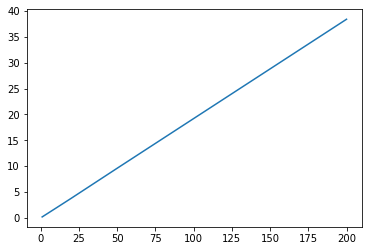

Linear regression fit: 
[ 0.19208019 -0.01375857]

Residual sum of squares: 
[0.0014281]


In [167]:
# Assumed fluid resistance due to channel area and shape as calculated by online calculator.
   # https://www.ufluidix.com/microfluidic-technical-knowledgebase/pressure-drop-calculator/

pairs = [(1, .2),(10,1.9), (20,3.8),(50, 9.6),(100, 19.2),(200, 38.4)]
flow = [entry[0] for entry in pairs]
mbar = [entry[1] for entry in pairs]
plt.plot(flow, mbar)
plt.show()

fit = np.polyfit(flow, mbar, 1, full=True)
print('Linear regression fit: ')
print(fit[0])
print()
print('Residual sum of squares: ')
print(fit[1])

### Forward in Time, Central in Space 2D Euler
Olsen-Kettle, L., 2011. Numerical solution of partial differential equations. Lecture notes at University of Queensland, Australia.

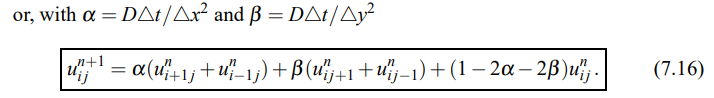

In [38]:
time_slice = np.zeros((5,5))
next_time_slice = np.zeros((5,5))
time_slice[2,3]=1
time_slice[3,3]=1


# If x-step and y-steps in distance are equal, alpha and beta are equal. This code assumes that is the case, 
#   and that evaluation cells are square/cubic
alpha = diffusion_coefficient * (time_step/distance_step**2)

for h in range(4):
    for w in range(4):
        # To keep array notation conistent, x=height and y=width
        next_time_slice[h,w] = alpha * (time_slice[h+1,w] + time_slice[h-1,w])\
        + alpha * (time_slice[h,w+1] + time_slice[h,w-1])+(1-4*alpha)*time_slice[h,w]
next_time_slice

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.25, 0.25, 0.  ],
       [0.  , 0.  , 0.25, 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])

In [ ]:
# If x-step and y-steps in distance are equal, alpha and beta are equal. This code assumes that is the case, 
#   and that evaluation cells are square/cubic
alpha = diffusion_coefficient * (time_step/distance_step**2)

for h in range(4):
    for w in range(4):
        # To keep array notation conistent, x=height and y=width
        next_time_slice[h,w] = alpha * (time_slice[h+1,w] + time_slice[h-1,w])\
        + alpha * (time_slice[h,w+1] + time_slice[h,w-1])+(1-4*alpha)*time_slice[h,w]

### Debye-Huckel approximation

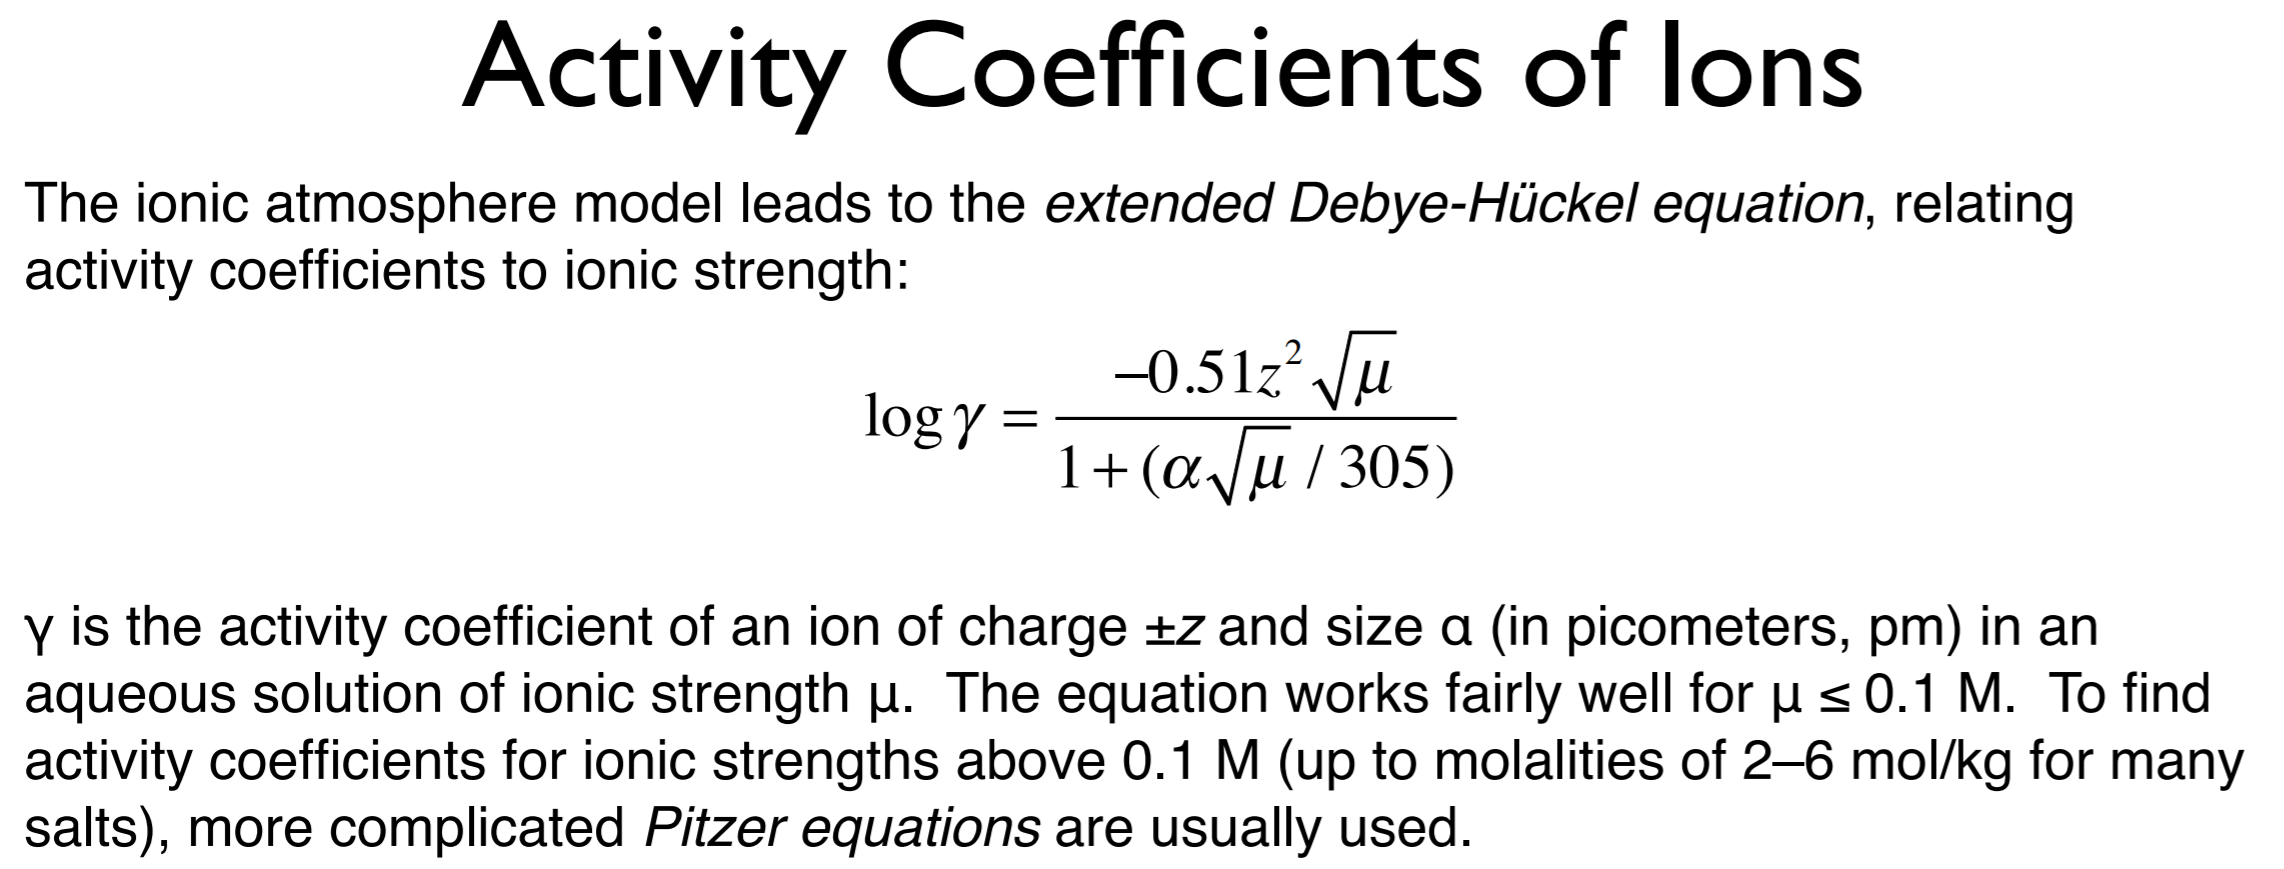

In [ ]:
# Debye-Huckel model; water, dilute, 298K
# Gamma is the activity coefficient

log_gamma = (-0.509 * abs(valence_charge**2)* np.sqrt(ionic_strength) ) / \
            (1+ (ionic_radius * np.sqrt(ionic_strength))/305)
gamma = 10**log_gamma

### Extended Debye-Huckel approximation

### Viscosity approximation

Krieger-Dougherty equation

In [20]:
visc_fractions

[]

Text(0.5, 0, 'Fraction of max volume fraction')

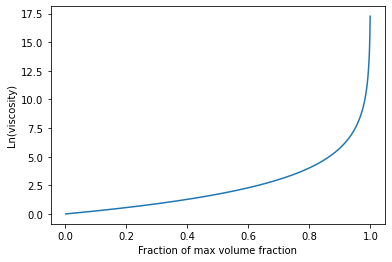

In [26]:
volume_fractions = [i/1000 for i in range(1,1000)]

visc_fractions = []
for fraction in volume_fractions:
    this_visc = round((1-fraction)**(-2.5), 5)
    ln_visc = math.log(this_visc)
    visc_fractions.append(ln_visc)

plt.plot(volume_fractions, visc_fractions)
plt.ylabel('Ln(viscosity)')
plt.xlabel('Fraction of max volume fraction')

# <u> Make a channel and set parameters

Some notes:
- If viscosity is being considered dynamically, that will be done at the time of calculation based on diffusive overlaps
- If viscosity is being considered dynamically, the 'viscosity' variable will become a channel mask initialized to the value below
- 'slice_depth' can change, but should stay at 2.5 um unless there's a very good reason not to. Stability issues will occur as discussed for the time_step below
- 'time_step' should not change; only the first term in the solution expansion is used for calculating the time-dependent change in flow rate; if any value greater than about 1 is used, the results will become unstable immediately

In [2]:
# Make a rectangular channel; (height, width, length) in um^3
   # creates 'channel_slice', 'channel_length' and 'wall_mask' global variables
new_channel(70, 500, 15000)

# MAKE SURE THIS IS RIGHT; in uL/min
flow_rate = 50
   # Made negative due to reality (it's a decrease down the channel)
   # in mbar/mm
pressure_drop = -1 * estimate_pressure_drop(flow_rate, wall_mask)

# in um; typically will not change
slice_depth = 2.5

# in usec; typically will not change
time_step = 1

# in g/cm^3; this doesn't change for now, but may in the future
density = 1

# in mPa * sec; assume water for single, homogenous value
   # Options below for dynamic consideration of viscosity take this value as the default
viscosity = 1

parameter_tuple = (pressure_drop, \
                  slice_depth, \
                  time_step, \
                  density, \
                  viscosity)

print("'parameter_tuple'")
print(parameter_tuple)
print()

#________________________________________________________________________________________

# Initial chemical inventories and values

metal_side = ['FeCl2']



'parameter_tuple'
(-0.64, 2.5, 1, 1, 1)



# <u> Standard assumption Peclet numbers

## Flow contribution and profile

Takes a standard 'channel_slice', 

'parameter_tuple'
(-0.64, 2.5, 1, 1, 1)

Gamma:   -0.064
Omega max:   0.16
Omega min:   0.16
Done in  96  iterations.
Max. flow:   9.00517406182588
Min. flow:   0.0
Avg. flow:   7.850644631181823


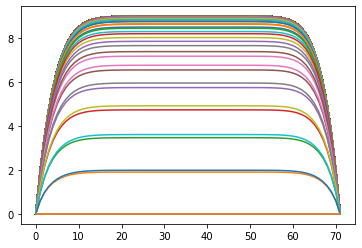

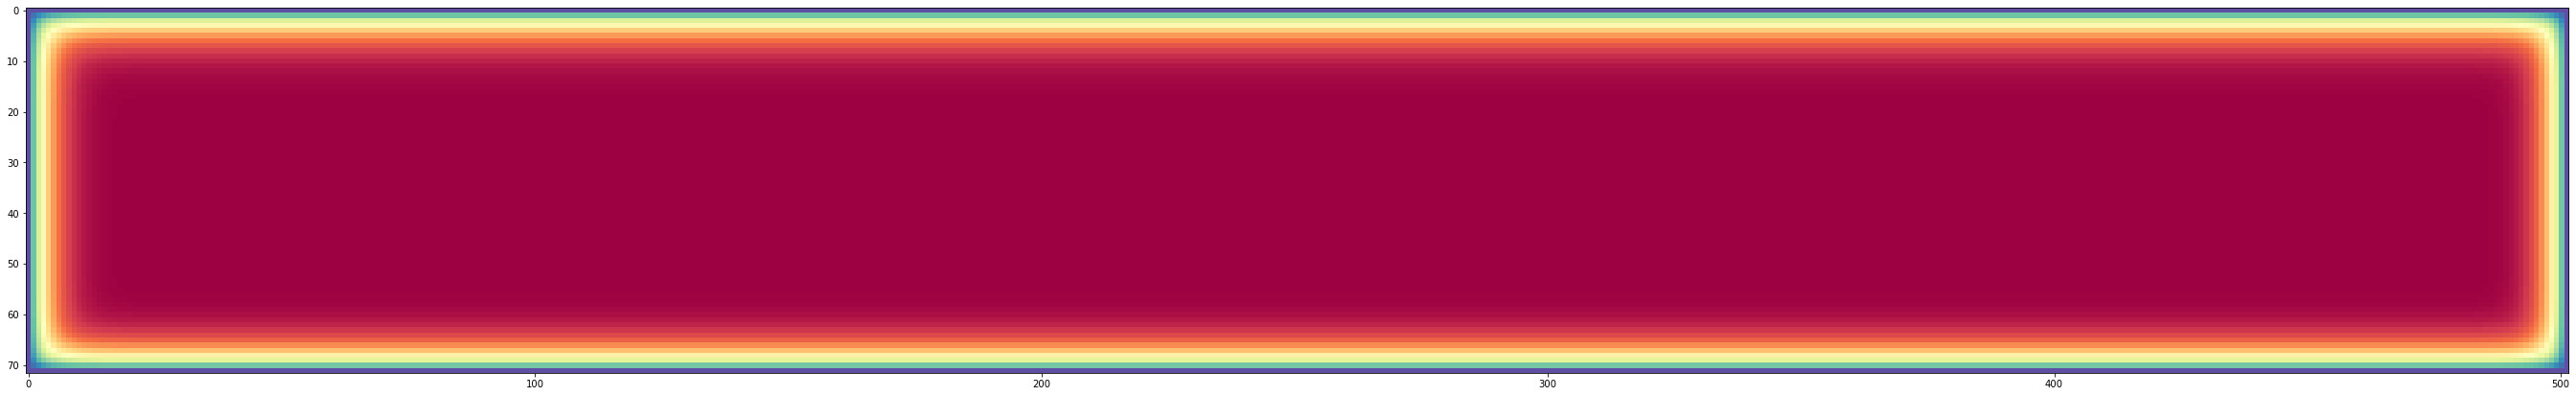

In [5]:
# Make a rectangular channel; (height, width, length) in um^3
   # creates 'channel_slice', 'channel_length' and 'wall_mask' global variables
new_channel(70, 500, 15000)

# MAKE SURE THIS IS RIGHT; in uL/min
flow_rate = 50
   # Made negative due to reality (it's a decrease down the channel)
   # in mbar/mm
pressure_drop = -1 * estimate_pressure_drop(flow_rate, wall_mask)

# in um; typically will not change
slice_depth = 2.5

# in usec; typically will not change
time_step = 1

# in g/cm^3; this doesn't change for now, but may in the future
density = 1

# in mPa * sec; assume water for single, homogenous value
   # Options below for dynamic consideration of viscosity take this value as the default
viscosity = 1

parameter_tuple = (pressure_drop, \
                  slice_depth, \
                  time_step, \
                  density, \
                  viscosity)

print("'parameter_tuple'")
print(parameter_tuple)
print()

#________________________________________________________________________________________


# Output is in mm/sec
flow_slice = equilibrate_flow_slice(parameter_tuple, channel_slice, wall_mask, max_iterations = 1000, \
                                   accuracy_threshold= .01)

f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(flow_slice, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

### Test a dynamic viscosity

#### (Fail) Use 'omega' constant with a dynamic viscosity
Does not work. The first term of the expansion as an analytical solution requires viscosity to be constant, and simple changing it's value in the 'omega' constant used in that solution is not appropriate.

In [3]:
# MAKE SURE THIS IS RIGHT; in uL/min
flow_rate = 50
   # Made negative due to reality (it's a decrease down the channel)
   # in mbar/mm
pressure_drop = -1 * estimate_pressure_drop(flow_rate, wall_mask)

# in um; typically will not change
slice_depth = 2.5

# in usec; typically will not change
time_step = 1

# in g/cm^3; this doesn't change for now, but may in the future
density = 1

# in mPa * sec; assume water for single, homogenous value
   # Options below for dynamic consideration of viscosity take this value as the default
#Calculate a testing viscosity profile____________________________________________________________________________
width = channel_slice.shape[1]
height = channel_slice.shape[0]

viscous_slice = np.multiply(np.ones((height, width)), viscosity)

top_visc = 1.2
band_size = 50

half_width = round(width/2)
viscous_slice[::,half_width] = top_visc
visc_step = (top_visc - viscosity)/band_size
this_visc = top_visc - visc_step

for index in range(1,band_size+1):
    viscous_slice[::,half_width + index] = this_visc
    viscous_slice[::,half_width - index] = this_visc
    this_visc -=visc_step
    if this_visc<viscosity:
        this_visc = viscosity
    
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(viscous_slice, interpolation= 'nearest')
plt.show()
#_________________________________________________________________________________________________________________

parameter_tuple = (pressure_drop, \
                  slice_depth, \
                  time_step, \
                  density, \
                  viscous_slice)   

# Output is in mm/sec
visc_flow_slice = equilibrate_flow_slice(parameter_tuple, channel_slice, wall_mask, max_iterations = 300, \
                                   accuracy_threshold= .001, run_to_max=True)

f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(visc_flow_slice, interpolation= 'nearest')
plt.show()

NameError: name 'wall_mask' is not defined

#### (In progress) Use a scalar to deform flow as a function of colloid-solute/colloid-colloid interaction strength
Not actually solving for flow based on dynamic viscosity, but assuming a dynamic effect on flow BECAUSE of a dynamic viscosity. 

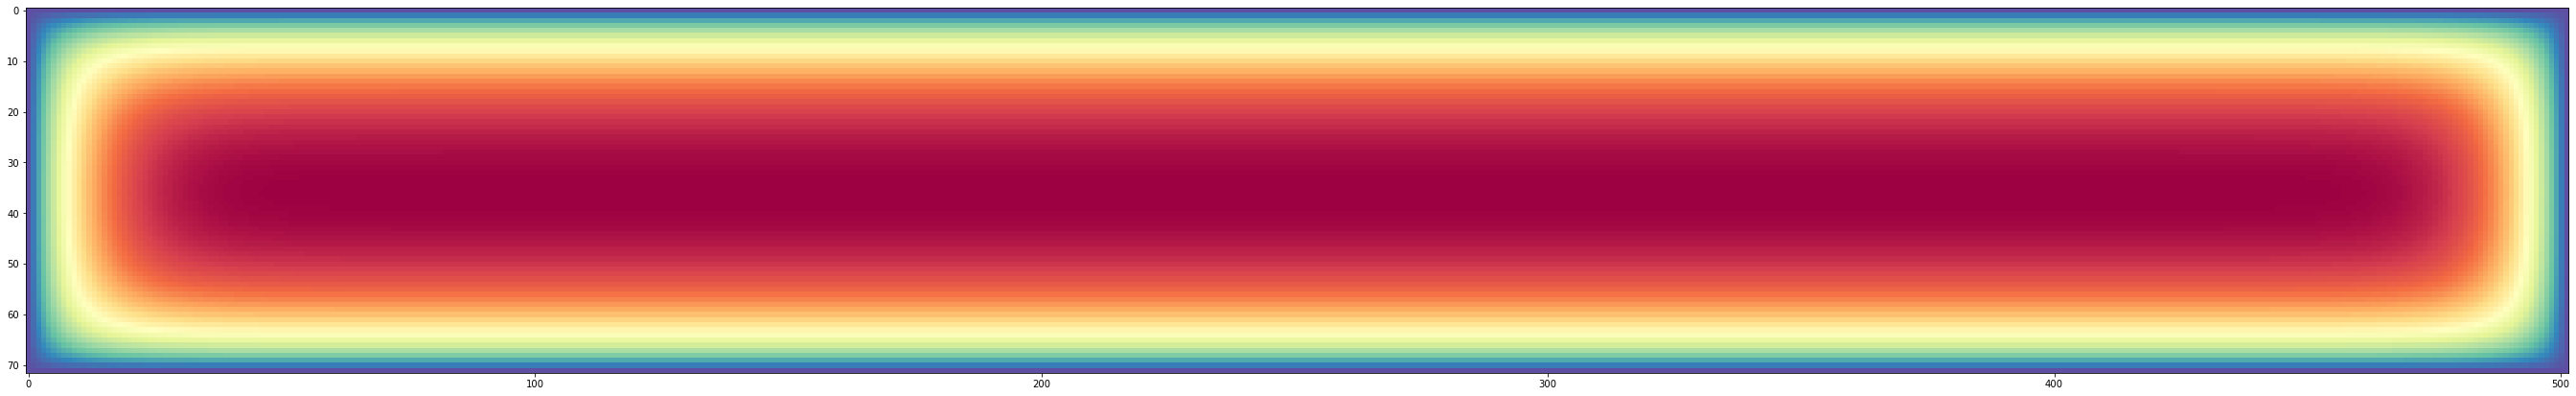

'parameter_tuple'
(-0.64, 2.5, 1, 1, 1)

70.95037970096875
49.5772355149511


In [13]:
root = Tk()
#root.withdraw()
filename = filedialog.askopenfilename()
root.destroy()

flow_slice = np.load(filename)

f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(flow_slice, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

# Make a rectangular channel; (height, width, length) in um^3
   # creates 'channel_slice', 'channel_length' and 'wall_mask' global variables
new_channel(70, 500, 15000)

# MAKE SURE THIS IS RIGHT; in uL/min
flow_rate = 50
   # Made negative due to reality (it's a decrease down the channel)
   # in mbar/mm
pressure_drop = -1 * estimate_pressure_drop(flow_rate, wall_mask)

# in um; typically will not change
slice_depth = 2.5

# in usec; typically will not change
time_step = 1

# in g/cm^3; this doesn't change for now, but may in the future
density = 1

# in mPa * sec; assume water for single, homogenous value
   # Options below for dynamic consideration of viscosity take this value as the default
viscosity = 1

parameter_tuple = (pressure_drop, \
                  slice_depth, \
                  time_step, \
                  density, \
                  viscosity)

print("'parameter_tuple'")
print(parameter_tuple)
print()

print(np.amax(flow_slice))
print(np.average(flow_slice))

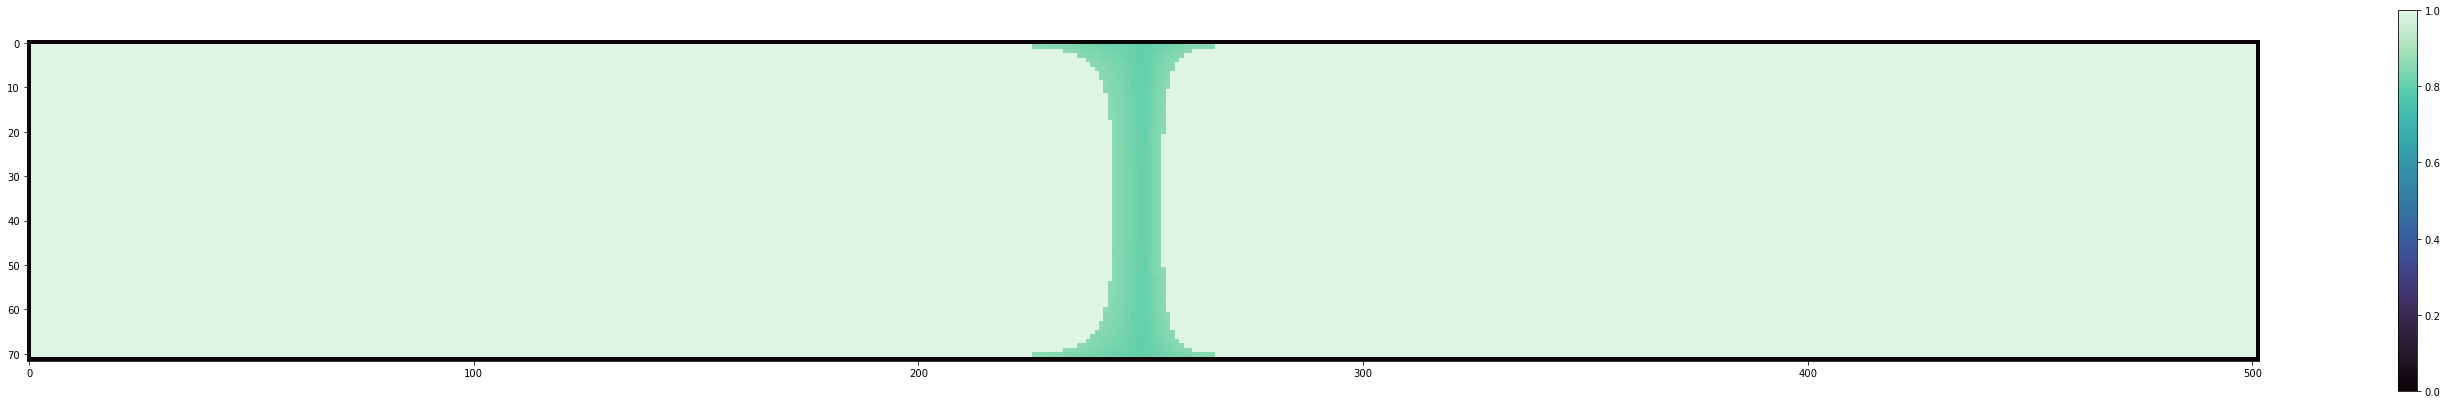

In [54]:
# Convert model from mol to Mol
model = fe_s_overlap[3]
model_max = np.amax(model)

visc_slice = np.copy(flow_slice)

height = flow_slice.shape[0]
width = flow_slice.shape[1]
visc_wall = np.ones( (height, width) )


for h in range(height):
    for w in range(width):
        if model[h,w]>= 2:
            visc_slice[h,w] = visc_slice[h,w] * 0
            visc_wall[h,w] = 0
        elif model[h,w]>= 0.7:
            this_value =  (1- (model[h,w]/5)) 
            visc_slice[h,w] = visc_slice[h,w] * this_value
            visc_wall[h,w] = this_value
        else:
            visc_wall[h,w] = 1
visc_wall = np.multiply(visc_wall, wall_mask)
            
f, ax = plt.subplots(figsize=(50, 7))
label_string = str('Flow deformation (Fe(II)-'+ anion+ ')')
plot = plt.imshow(visc_wall, interpolation= 'nearest', \
                  cmap = sns.color_palette("mako", as_cmap=True), \
                  vmin = 0, \
                  vmax = 1)

f.colorbar(plot)

plt.show()

Gamma:   -0.064
Omega max:   0.16
Omega min:   0.16
Done in  74  iterations.
Max. flow:   76.90600282802025
Min. flow:   0.0
Avg. flow:   50.088029908626176


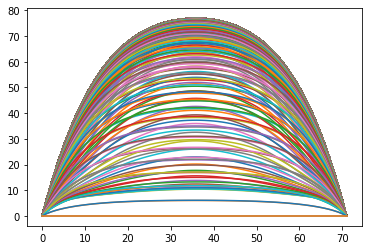

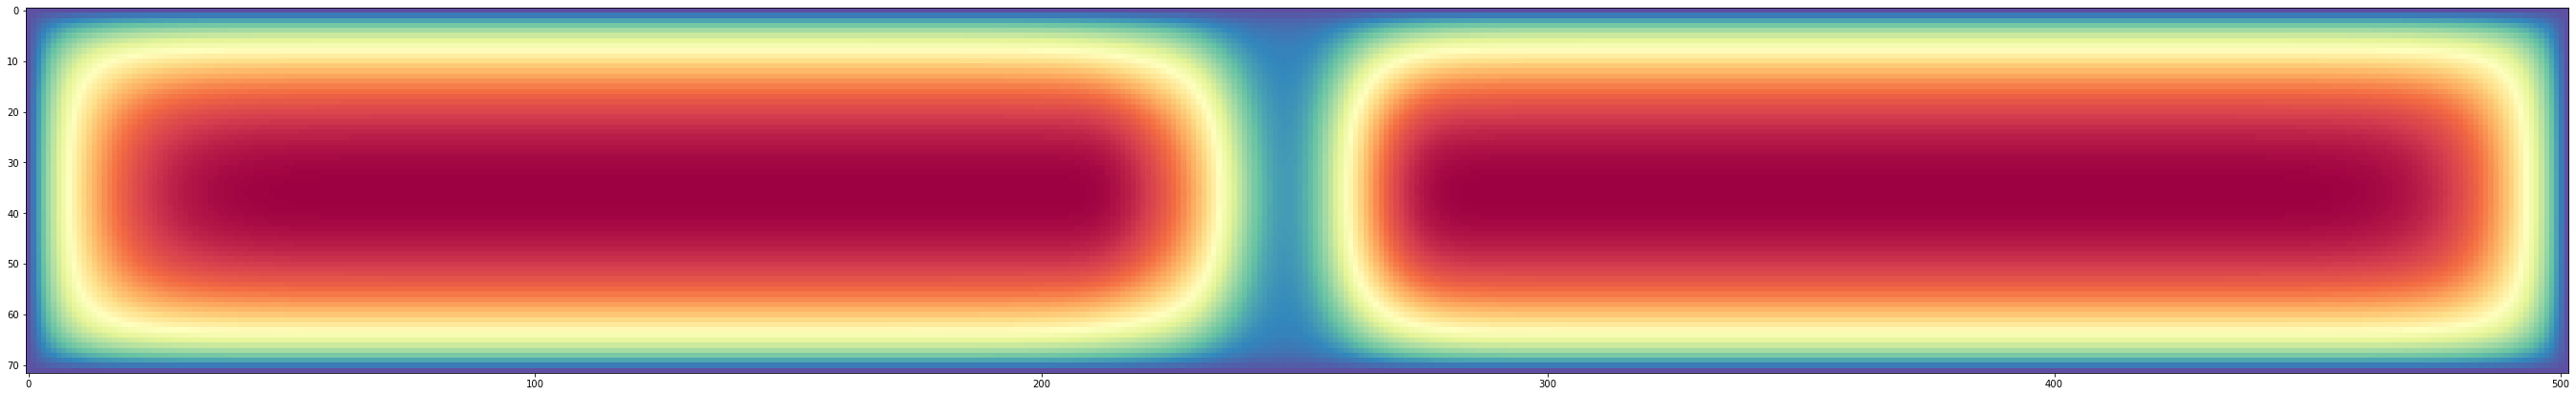

In [16]:
visc_flow_slice = equilibrate_flow_slice(parameter_tuple, visc_slice, wall_mask, max_iterations = 1000, \
                                   accuracy_threshold= .001, run_to_max = False)

f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(visc_flow_slice, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

75.38701759833123
50.0260564918864


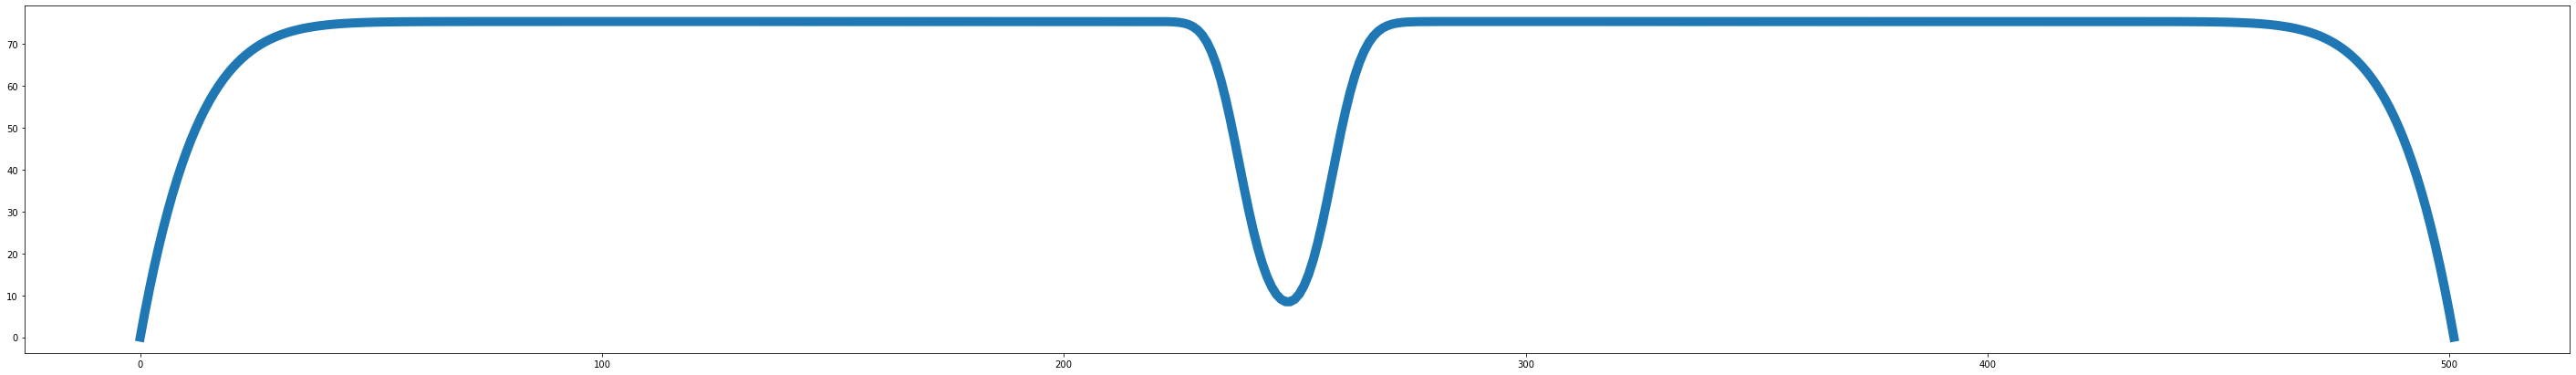

In [12]:
model = visc_flow_slice

print(np.amax(model))
print(np.average(model))

f, ax = plt.subplots(figsize=(50, 7))
plt.plot(model[35,::], linewidth = 10)
#plt.ylim([0,70])
plt.show()

### Test flow equilibration with test wall

6'18'' for flow equilibration with .1% accuracy threshold and 50 uL/min flow rate

Mask looks like: 


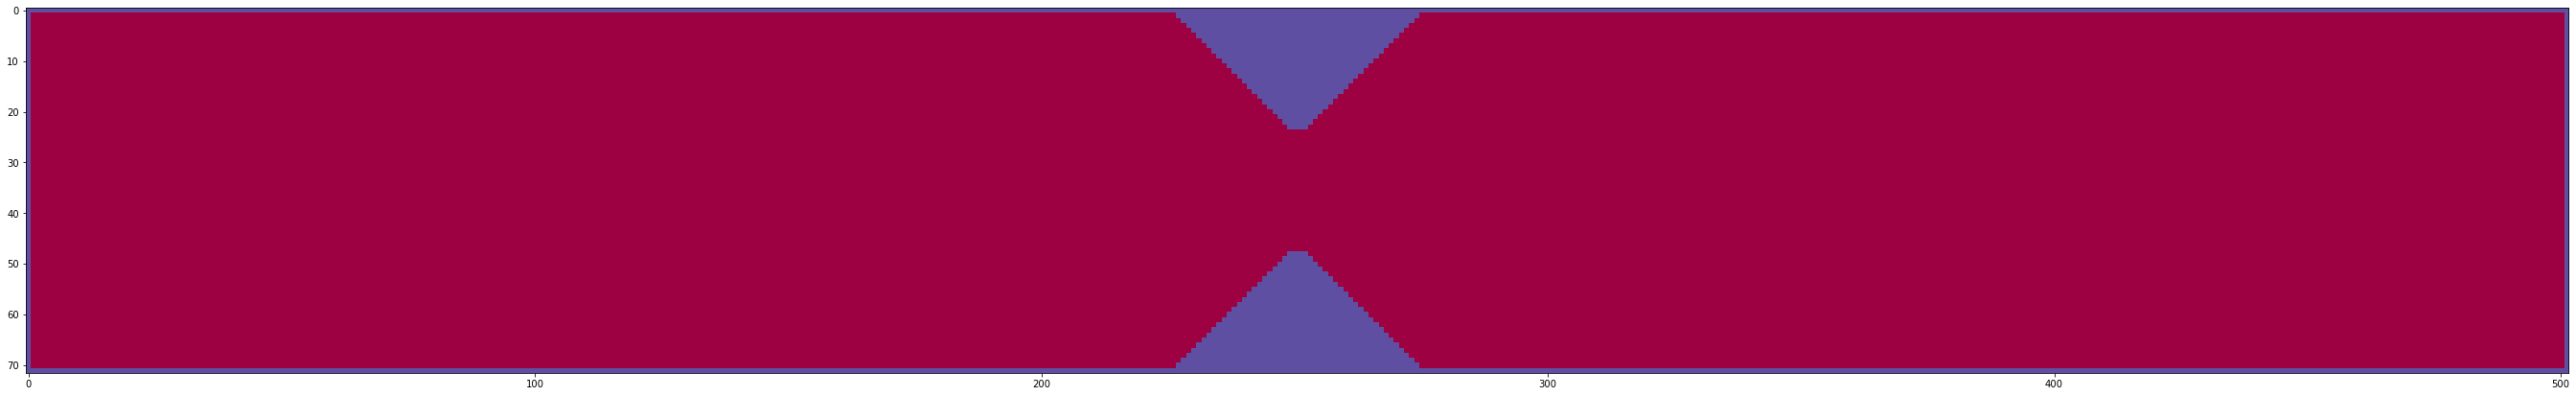

Gamma:   -0.064
Omega max:   0.16
Omega min:   0.16


KeyboardInterrupt: 

In [8]:
trial_wall_mask = np.copy(wall_mask)

width= channel_slice.shape[1]
height = channel_slice.shape[0]

half_width = round(width/2)
base_size = 50
for iteration, step in enumerate(range(round(base_size/2),1,-1)):
    trial_wall_mask[0+iteration, half_width-step:half_width+step]= 0
    trial_wall_mask[(height-1)-iteration, half_width-step:half_width+step] = 0

print("Mask looks like: ")    
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(trial_wall_mask, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

# MAKE SURE THIS IS RIGHT; in uL/min
flow_rate = 50
   # Made negative due to reality (it's a decrease down the channel)
   # in mbar/mm
pressure_drop = -1 * estimate_pressure_drop(flow_rate, wall_mask)

# in um; typically will not change
slice_depth = 2.5

# in usec; typically will not change
time_step = 1

# in g/cm^3; this doesn't change for now, but may in the future
density = 1

parameter_tuple = (pressure_drop, \
                  slice_depth, \
                  time_step, \
                  density, \
                  viscosity)   

# Output is in mm/sec
trial_flow_slice = equilibrate_flow_slice(parameter_tuple, channel_slice, trial_wall_mask, max_iterations = 1000, \
                                   accuracy_threshold= .001, run_to_max=False)

f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(trial_flow_slice, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

## Rough diffusional assumption

Assumes the following:
- that diffusion is essentially one dimensional
- that the possible diffusional flux is equal to the full coefficient of diffusion within a range as calculated by:
    - Concentration(r,t) = some math, with r=radial distance, t= time, and D= diffusion constant
- No diffusion for 

At  15  um


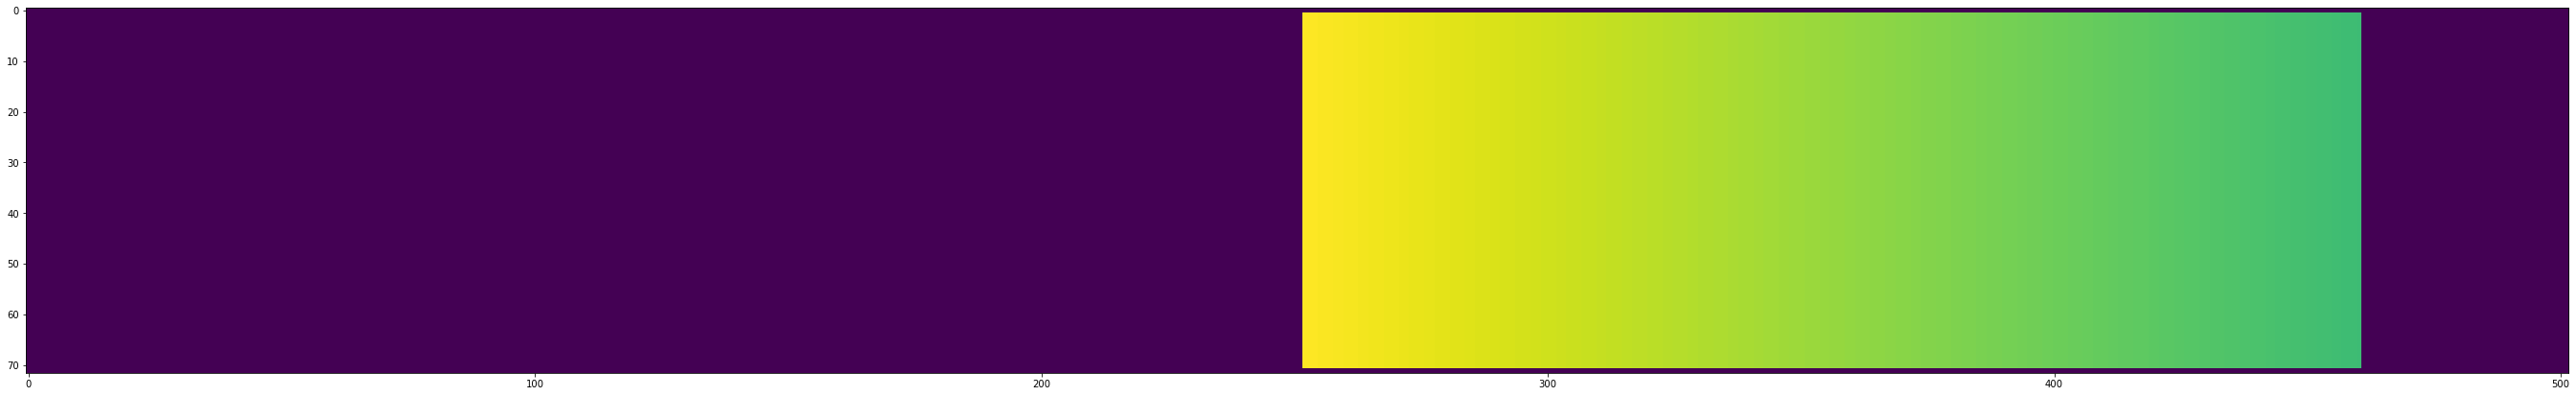

At  1500  um


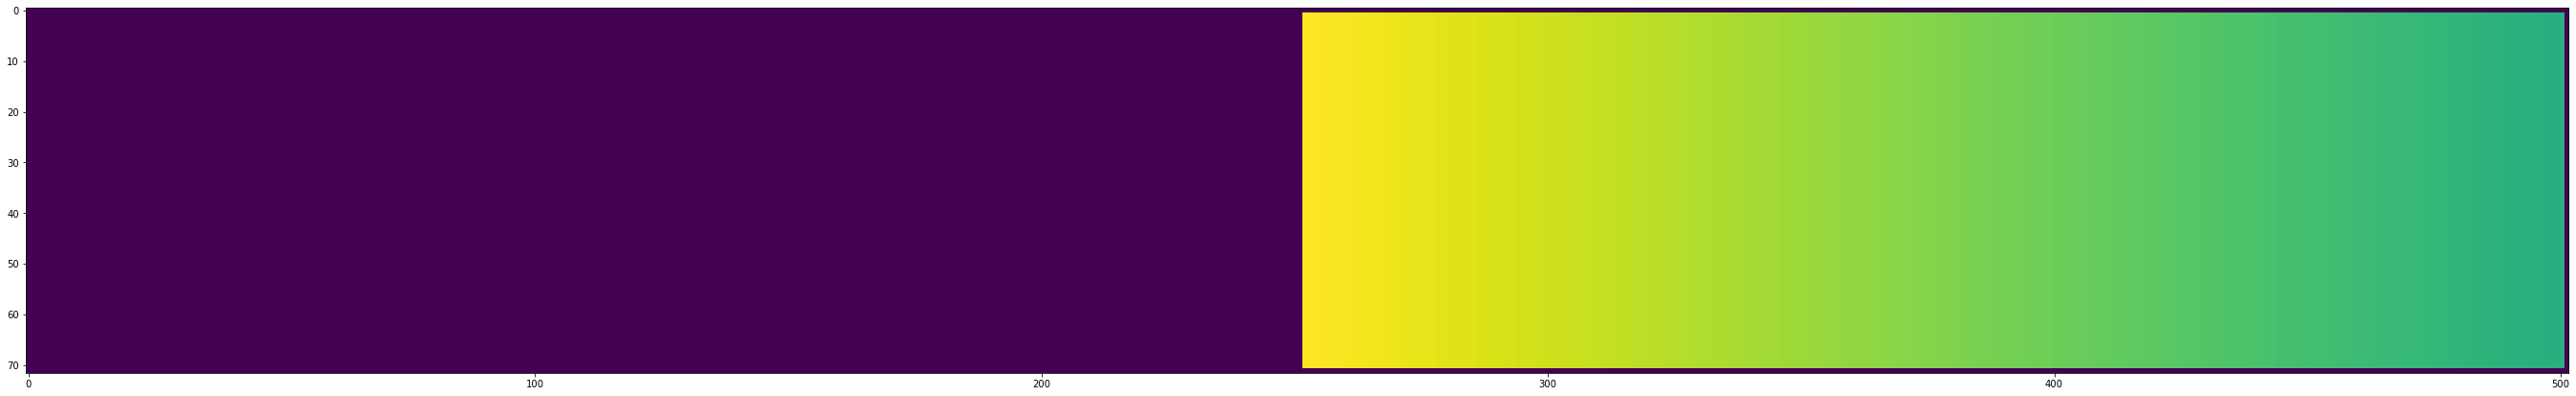

At  7500  um


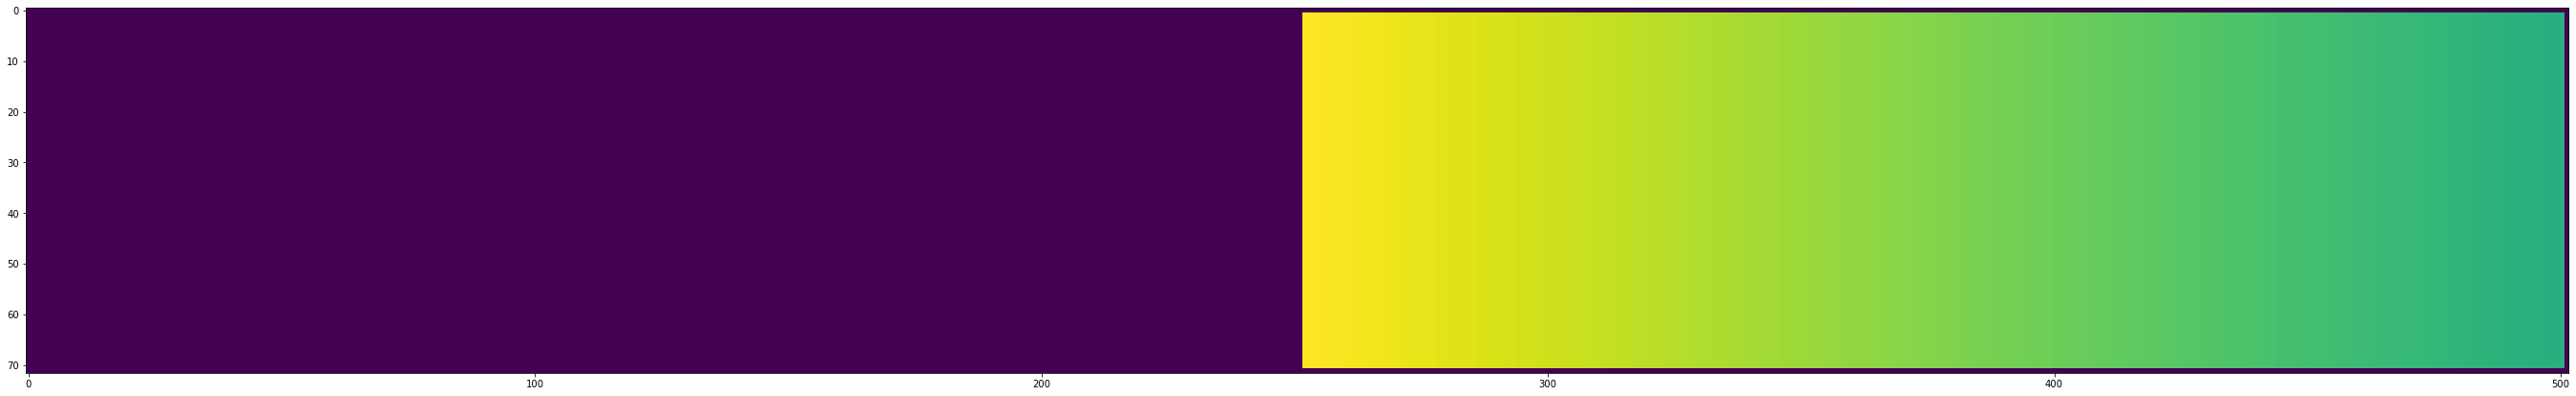

At  12000  um


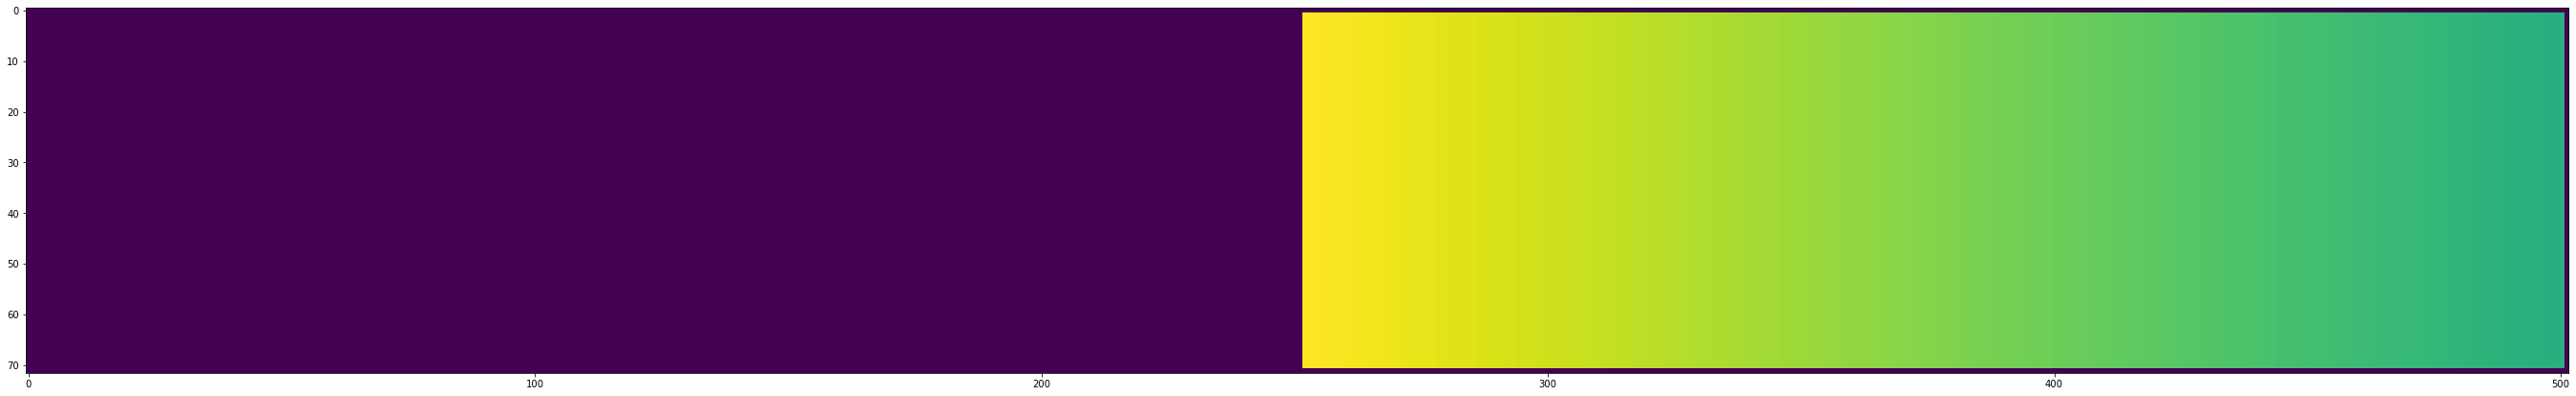

In [266]:
diffusion_slices, diffusion_distances = simple_1D_diffusion(wall_mask, 1330, 'metal-side', flow_rate)

## Mapping and graphing Peclet number at channel slices

Gamma:   -0.256
Omega:   0.16
Done in  782  iterations.
Max. flow:   283.9065252590749
Min. flow:   0.0
Avg. flow:   198.37226362857794


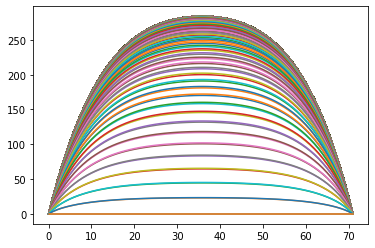

Flow profile for  200  uL/min. Flow in um/sec.


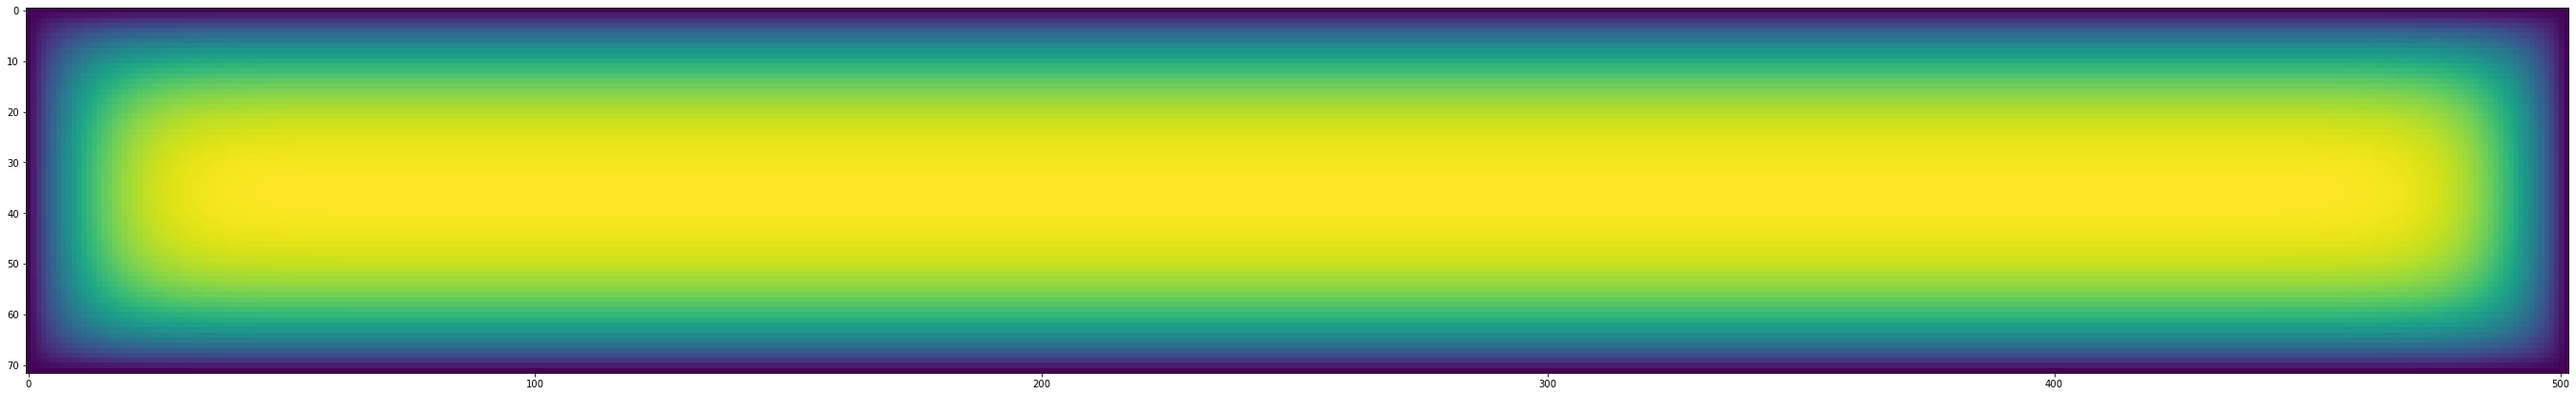

At  15  um


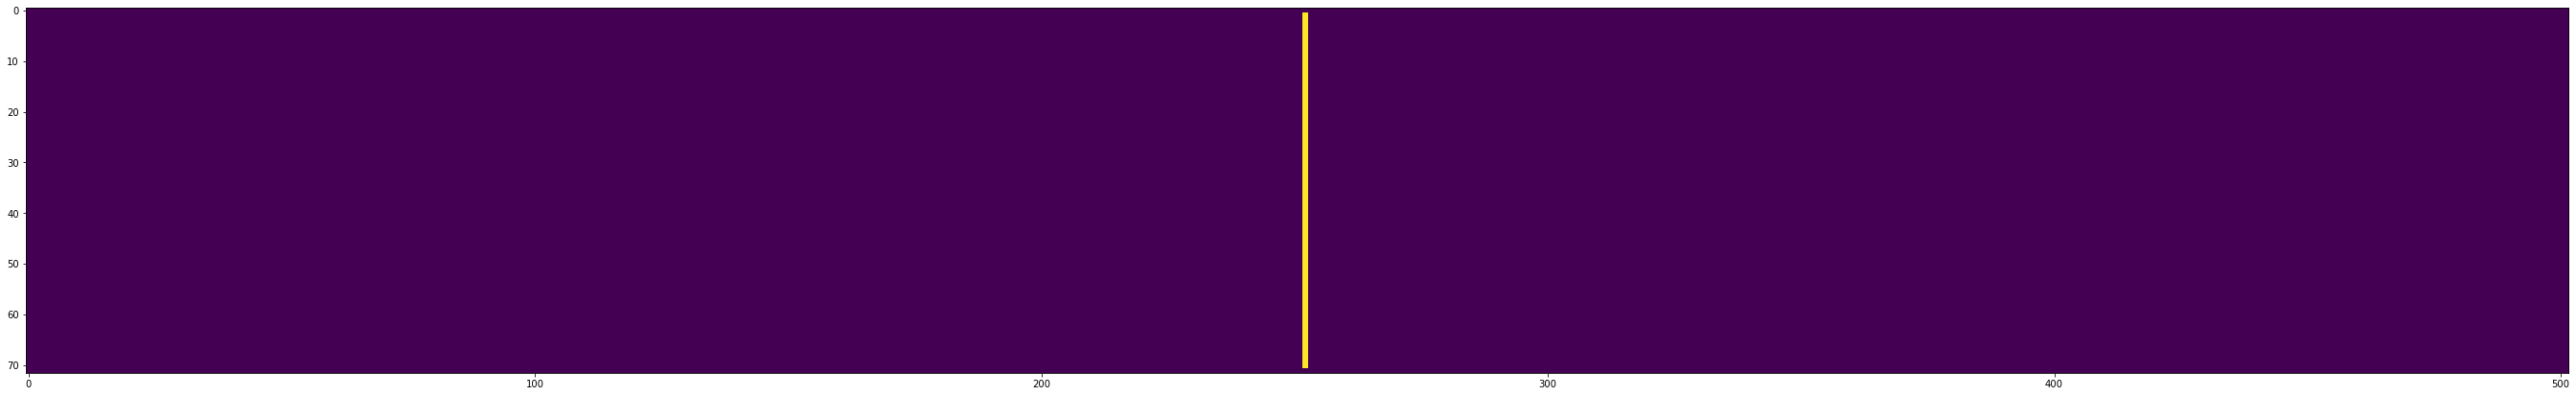

At  1500  um


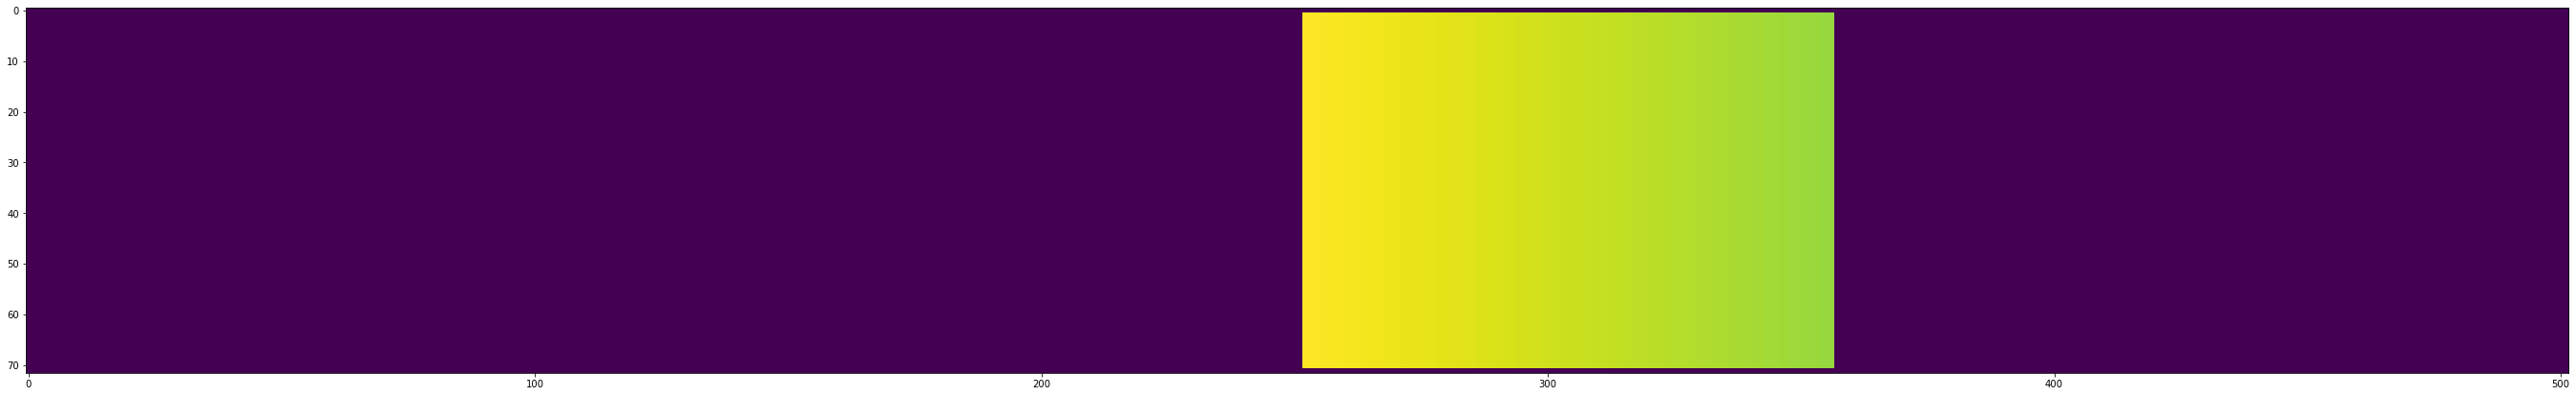

At  7500  um


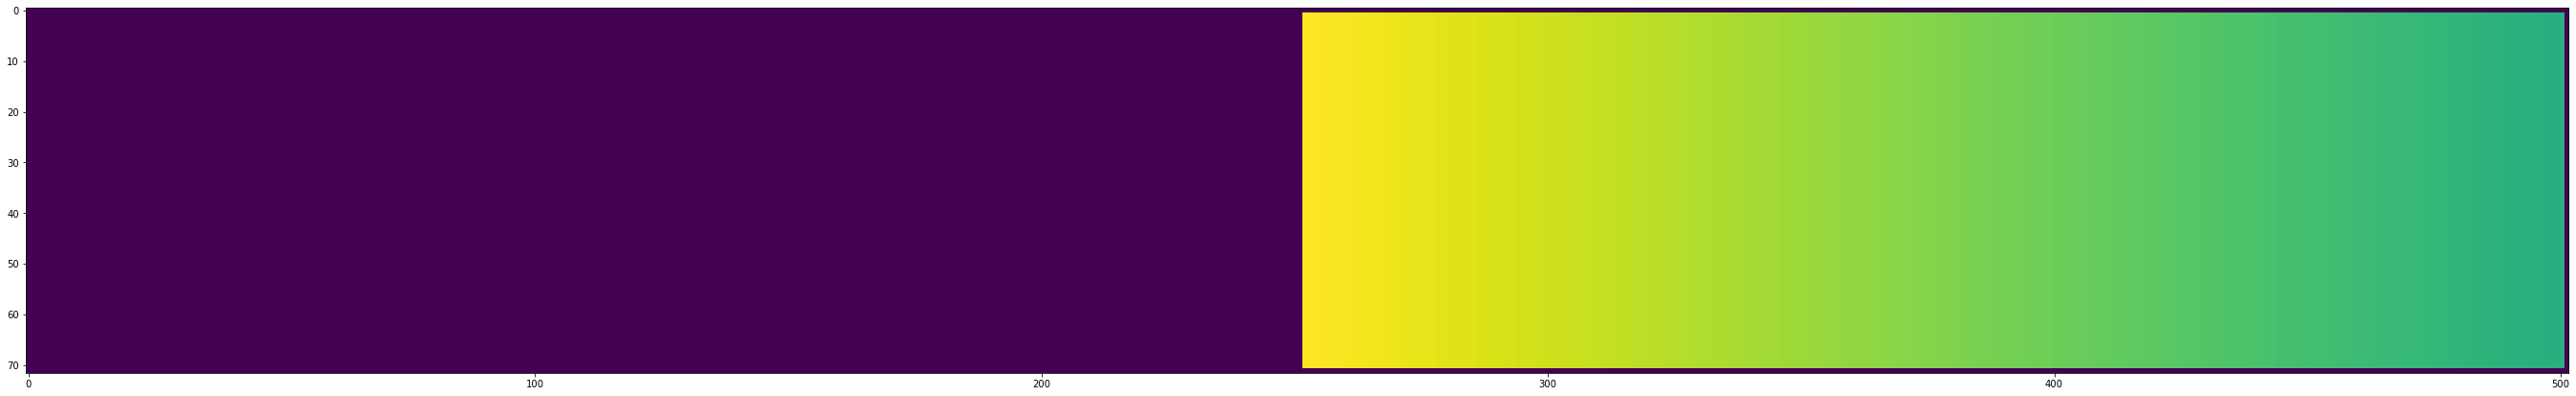

At  12000  um


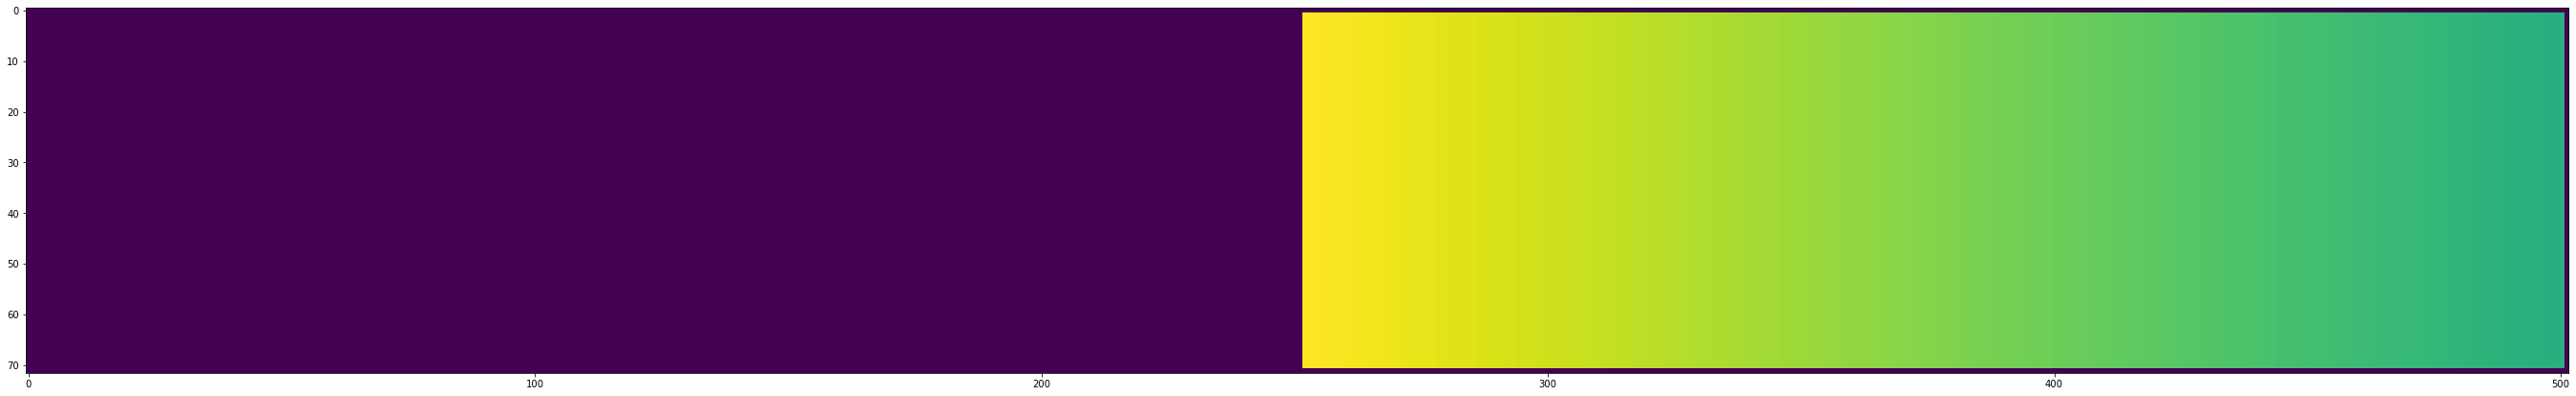

Peclet numbers across channel for each channel section


NameError: name 'return_distances' is not defined

In [9]:
# Combining the two sections above
new_channel(70, 500, 15000)

# MAKE SURE THIS IS RIGHT; in uL/min
flow_rate = 200
   # Made negative due to reality (it's a decrease down the channel)
   # in mbar/mm
pressure_drop = -1 * estimate_pressure_drop(flow_rate, wall_mask)

# in um; typically will not change
slice_depth = 2.5

# in usec; typically will not change
time_step = 1

# in g/cm^3; this doesn't change for now, but may in the future
density = 1

# in mPa * sec; assume water for single, homogenous value
   # Options below for dynamic consideration of viscosity take this value as the default
viscosity = 1

parameter_tuple = (pressure_drop, \
                  slice_depth, \
                  time_step, \
                  density, \
                  viscosity)    

#______________________________________________________________________________________________
# Flow equilibration and profiling 
flow_slice = equilibrate_flow_slice(parameter_tuple, channel_slice, viscosity, wall_mask, max_iterations = 1000, \
                                   accuracy_threshold= .001, run_to_max = False)
um_flow_slice = flow_slice*1000
print("Flow profile for ", flow_rate, " uL/min. Flow in um/sec.")
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(um_flow_slice, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()
    
#______________________________________________________________________________________________
# Calculate rough 1D diffusional fluxes for     
diffusion_slices, diffusion_distances = simple_1D_diffusion(wall_mask, 1330, 'metal-side', flow_rate)

#______________________________________________________________________________________________
# Combine and calculate Peclet number per bin for each distance
peclet_slices = []
for diffusion_profile in diffusion_slices:
    this_slice = channel_slice
    this_slice = np.divide(um_flow_slice, diffusion_profile, out=np.zeros_like(um_flow_slice), \
                           where=diffusion_profile!=0)
    peclet_slices.append(this_slice)

print("Peclet numbers across channel for each channel section")
print("At ", return_distances[0], " um")
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(peclet_slices[0], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
ax.legend()
plt.show()

print("At ", return_distances[1], " um")
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(peclet_slices[1], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
ax.legend()
plt.show()

print("At ", return_distances[2], " um")
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(peclet_slices[2], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
ax.legend()
plt.show()

print("At ", return_distances[3], " um")
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(peclet_slices[3], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
ax.legend()
plt.show()

In [ ]:
print("At ", return_distances[0], " um")
print("Max. Peclet number:  ", np.amax(peclet_slices[0][::,200:300]))
print("Avg. flow:  ", np.average(peclet_slices[0][::,200:300]))
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(peclet_slices[0][::,200:300], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

print("At ", return_distances[1], " um")
print("Max. Peclet number:  ", np.amax(peclet_slices[1][::,200:300]))
print("Avg. flow:  ", np.average(peclet_slices[1][::,200:300]))
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(peclet_slices[1][::,200:300], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

print("At ", return_distances[2], " um")
print("Max. Peclet number:  ", np.amax(peclet_slices[2][::,200:300]))
print("Avg. flow:  ", np.average(peclet_slices[2][::,200:300]))
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(peclet_slices[2][::,200:300], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

print("At ", return_distances[3], " um")
print("Max. Peclet number:  ", np.amax(peclet_slices[3][::,200:300]))
print("Avg. flow:  ", np.average(peclet_slices[3][::,200:300]))
f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(peclet_slices[3][::,200:300], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

# <u> Detailed diffusion/flow model (no precipitation)

Assumes a stepwise contribution from one channel-side, and distributes down-channel based on flow rate

## Load or create a new flow slice 

### Load a flow slice

Max flow:  283.8015596268658
Average flow:  198.30896385572893


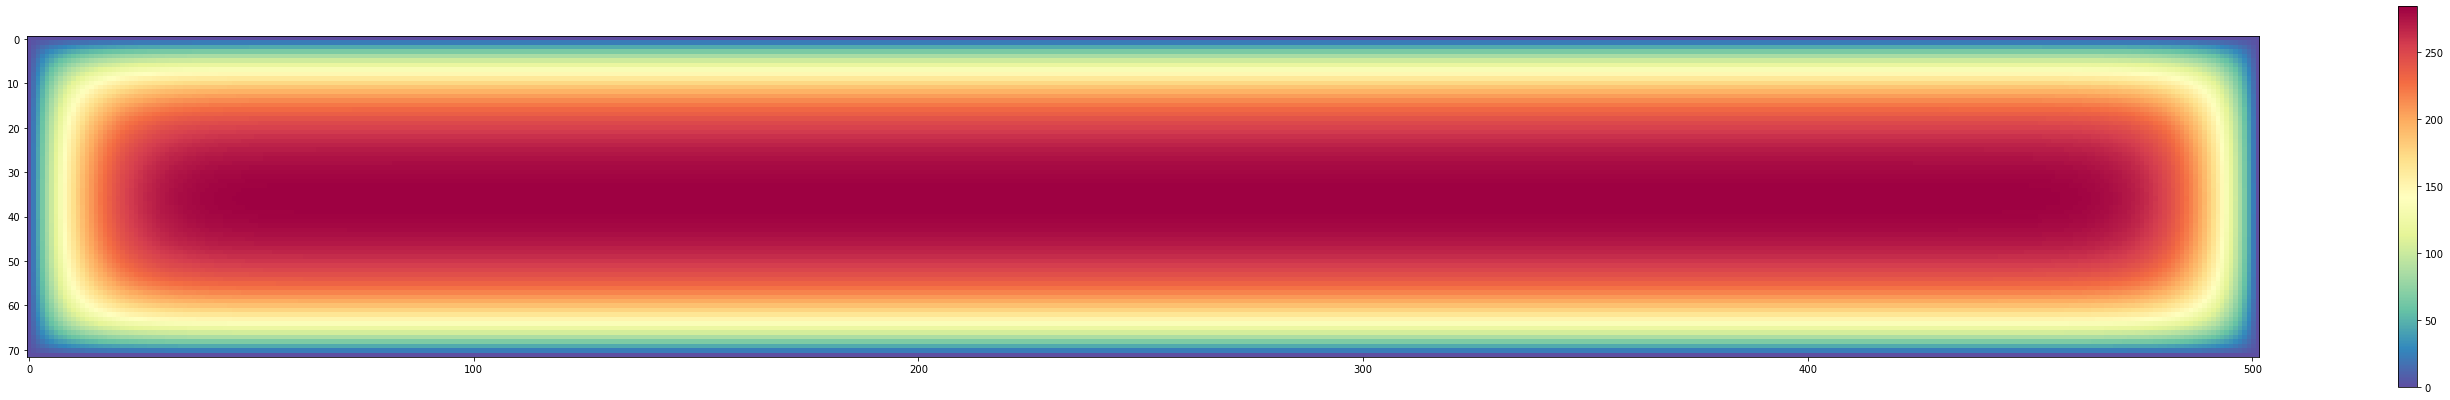

In [7]:
root = Tk()
#root.withdraw()
filename = filedialog.askopenfilename()
root.destroy()

flow_slice = np.load(filename)

print("Max flow: ", np.amax(flow_slice))
print("Average flow: ", np.average(flow_slice))

f, ax = plt.subplots(figsize=(50, 7))
plot = plt.imshow(flow_slice, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))

f.colorbar(plot)
plt.show()


### Create a new flow slice

'parameter_tuple'
(-2.56, 2.5, 1, 1, 1)

Gamma:   -0.256
Omega max:   0.16
Omega min:   0.16
Done in  782  iterations.
Max. flow:   283.8015596268658
Min. flow:   0.0
Avg. flow:   198.30896385572893


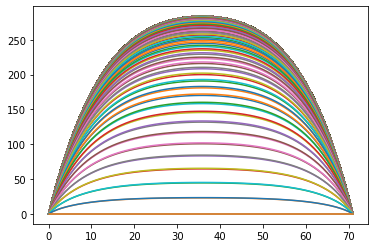

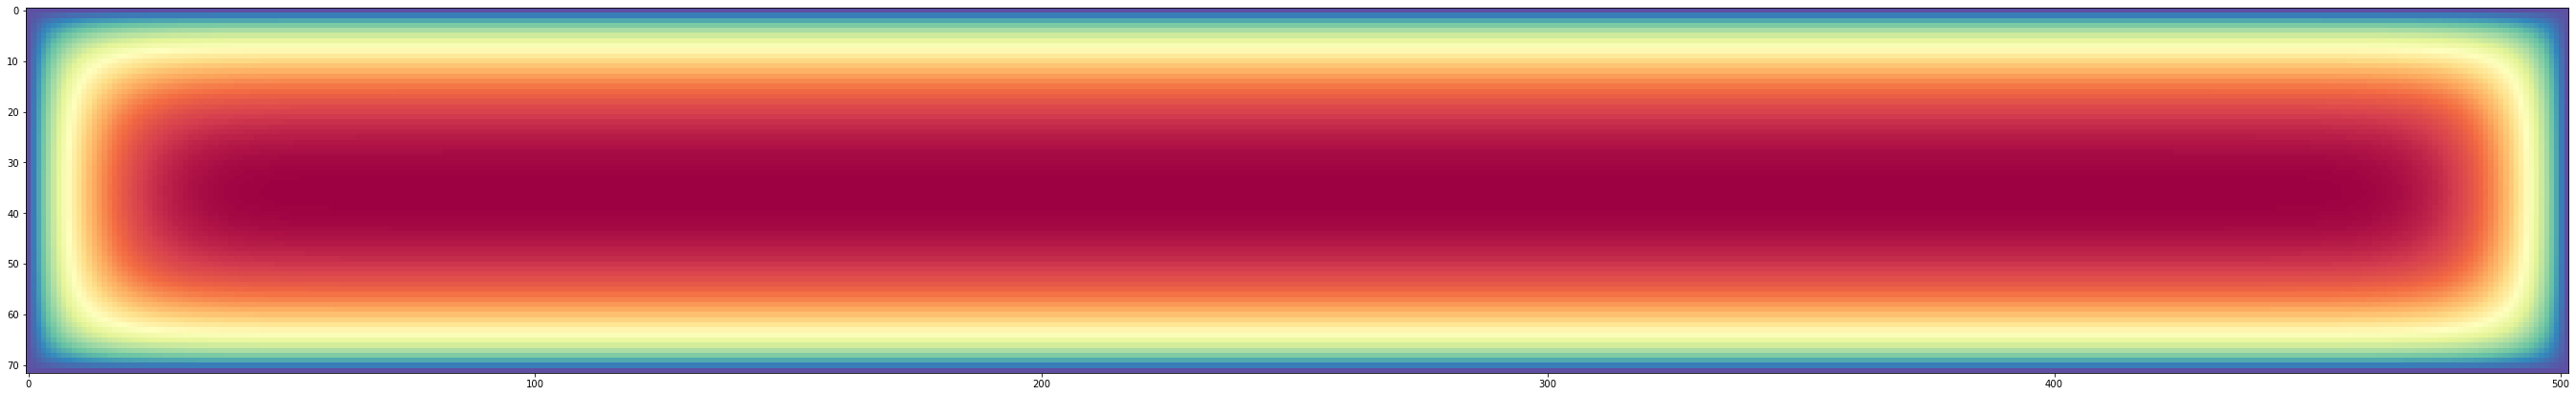

In [90]:
#Create a new flow slice
#_______________________________________________________________________________________________________

# Output is in mm/sec
flow_slice = equilibrate_flow_slice(parameter_tuple, channel_slice, wall_mask, max_iterations = 1000, \
                                   accuracy_threshold= .001)

f, ax = plt.subplots(figsize=(50, 7))
plt.imshow(flow_slice, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
plt.show()

#
# Save the flow model, if desired
#Done: #one_flow_slice   #fifty_flow_slice   #onehundred_flow_slice   #twohundred_flow_slice

root = Tk()
#root.withdraw()
filename = filedialog.asksaveasfilename()
root.destroy()

np.save(filename, flow_slice)

## Load or create pseudo-3D models

### Load a 'results_model'

In [19]:
root = Tk()
#root.withdraw()
filename = filedialog.askopenfilename()
root.destroy()

return_models = np.load(filename)

In [20]:
# Make a new channel to 'apply' model to
new_channel(70, 500, 15000)

# These are the standard percentage-of-channel-length distances that are calculated
return_percentages = [0.001, 0.01, 0.1, 0.5, 0.66667]

#'channel_length' should be a global variable
return_distances = [int(round(percentage * channel_length)) for percentage in return_percentages]

# For Fe(II)Cl2-Na2S, the standard return chemical species and their order is below
return_names = ['Fe(II)', 'Cl(I)', 'H(I)', 'Na(I)', 'HS(I)']
# ['Fe(II)', 'Cl(I)', 'H(I)', 'Na(I)', 'HPO4(II)']
# ['Fe(II)', 'Cl(I)', 'H(I)', 'Na(I)', 'HS(I)']
# ['Fe(II)', 'Cl(I)', 'H(I)', 'Na(I)', 'CO3(II)']

### Create a new pseudo-3D model

In [9]:
new_channel(70, 500, 15000)

# Required inputs
flow_rate = 1
#'wall_mask', global variable on channel generation
flow_mask = np.copy(flow_slice)
metal_side_reactants = {'FeCl2': 1, 'pH': 5}
anion_side_reactants = {'Na2HPO4': 1, 'pH': 9.5} # 'Na2S'   'Na2HPO4'   'Na2CO3'

# Optional inputs
precipitation = False
flow_equilibrate = False
return_slices = [0.001]  # [0.001, 0.01, 0.1, 0.5, 0.66667]
# ['H(I)', 'Fe(II)', 'Cl(I)', 'Na(I)', 'HS(I)']
# ['H(I)', 'Fe(II)', 'Cl(I)', 'Na(I)', 'HPO4(II)']
# ['H(I)', 'Fe(II)', 'Cl(I)', 'Na(I)', 'CO3(II)']
this_return = ['H(I)', 'Fe(II)', 'Cl(I)', 'Na(I)', 'HPO4(II)']

return_models, return_names, return_distances = pseudo_3d_model(flow_rate, wall_mask, flow_slice, \
                                                                metal_side_reactants, anion_side_reactants, \
                                                                return_slices = [0.001, 0.01, 0.1, 0.5, 0.66667], \
                                                                chem_return = this_return, \
                                                                specify_species = []
                                                               ) 

All species to be run: 
['Fe(II)', 'Cl(I)', 'H(I)', 'Na(I)', 'HPO4(II)', 'H(I)']


Starting on  Fe(II)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000

Starting on  Cl(I)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800


## Save the model results

In [10]:
root = Tk()
#root.withdraw()
filename = filedialog.asksaveasfilename()
root.destroy()

np.save(filename, return_models)

## Visualize the 'return_models'

### Visualize all results from 'return_models'

____________________________________________________
Fe(II)

1.0000000000000002e-12
4.765360781455611e-13
0.0

15


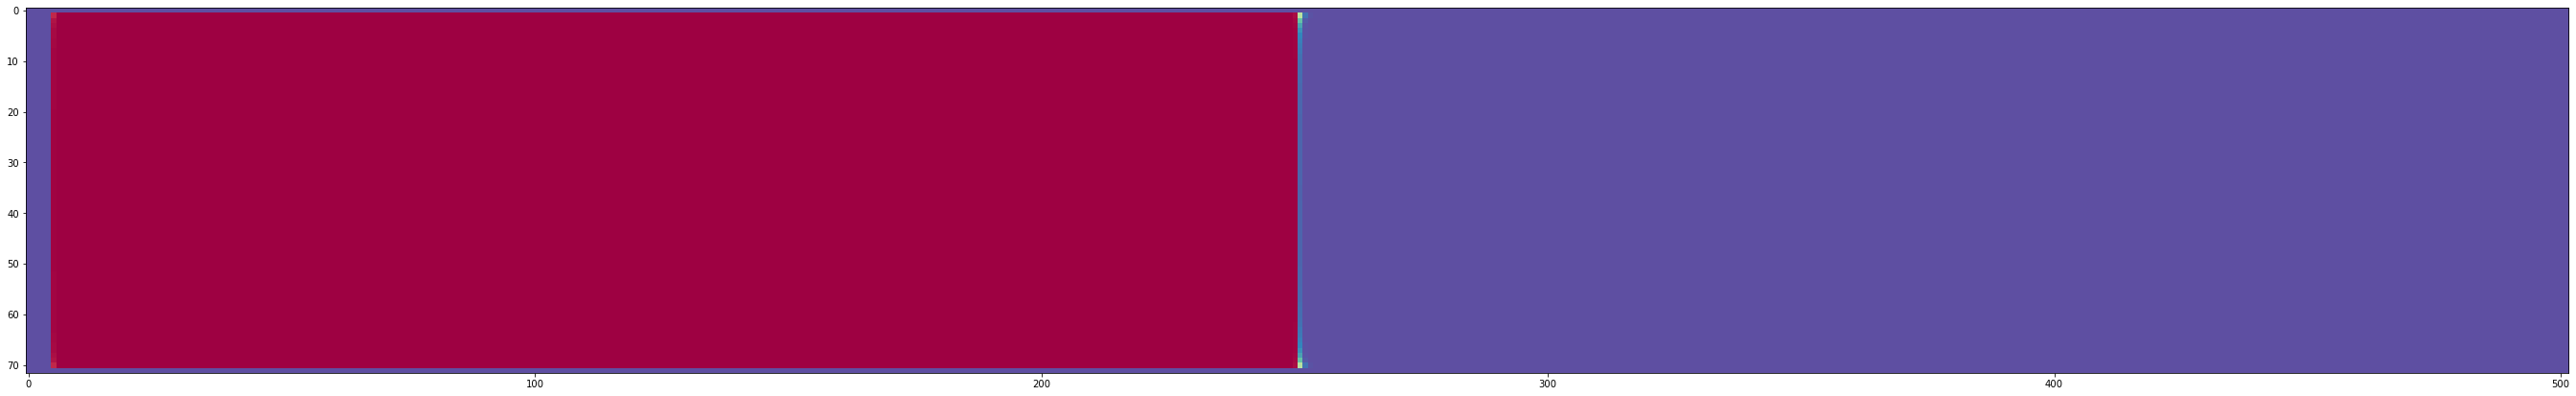

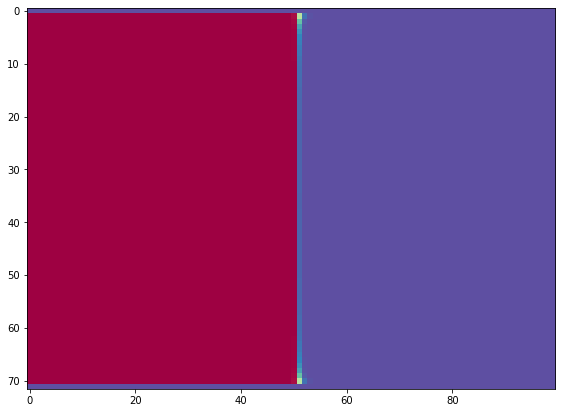


1.0000000000000002e-12
4.773723088199271e-13
0.0

150


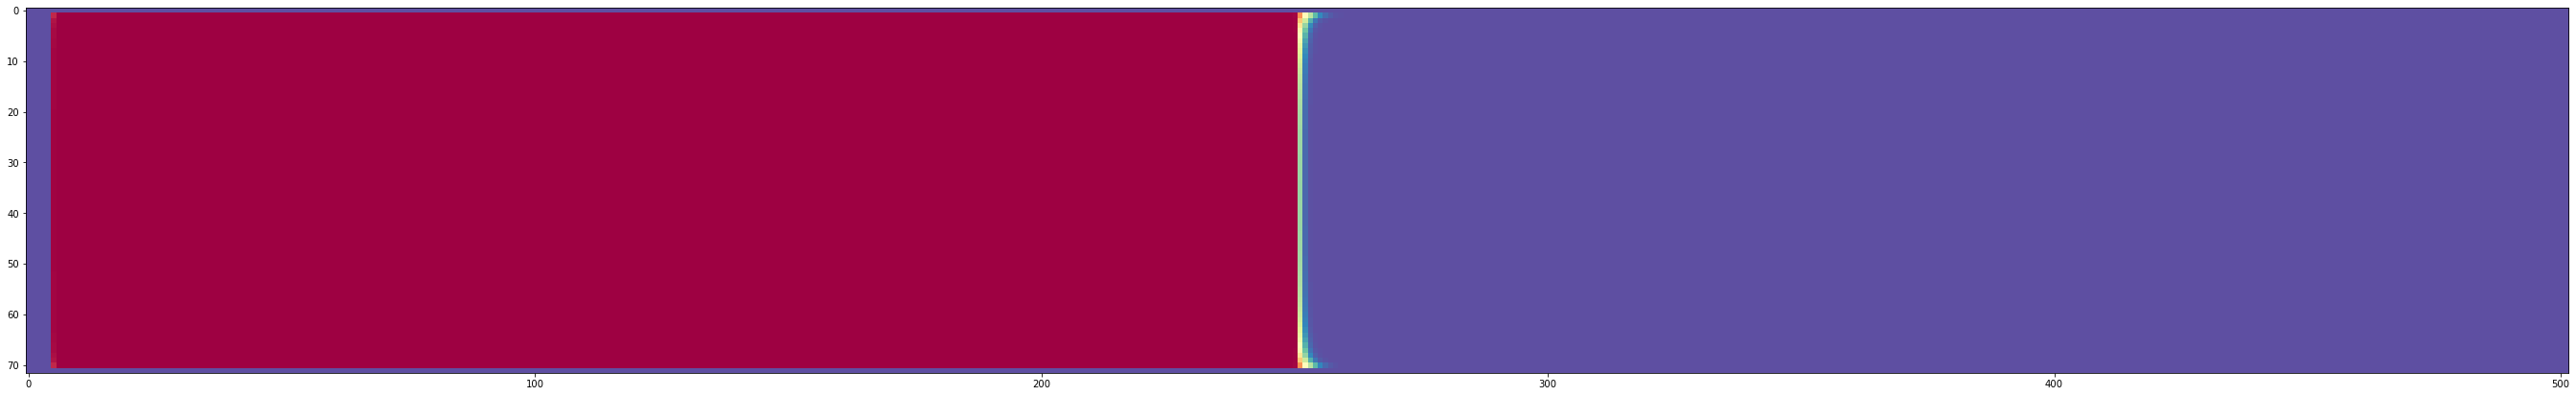

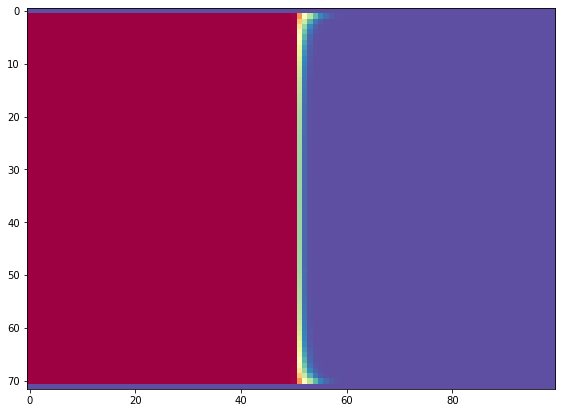


1.0000000000000002e-12
4.809687786841309e-13
0.0

1500


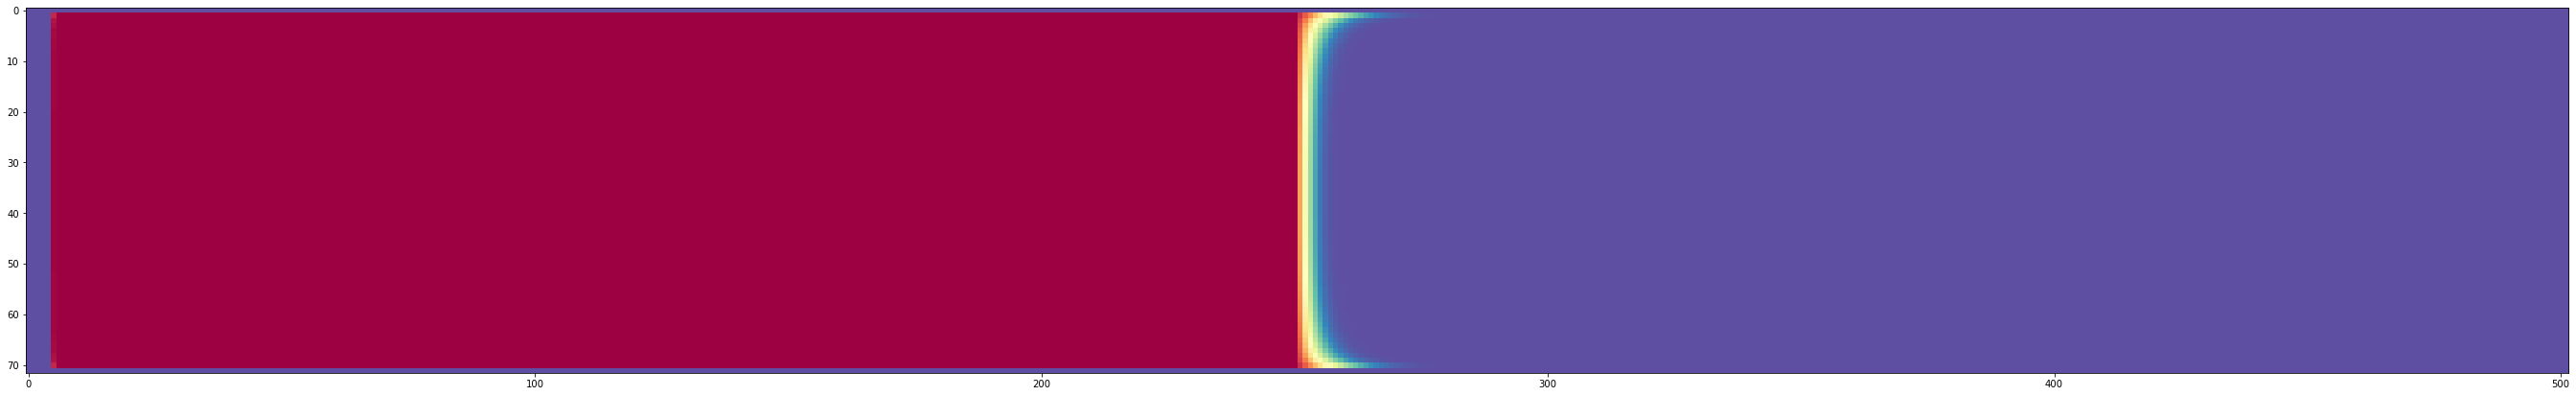

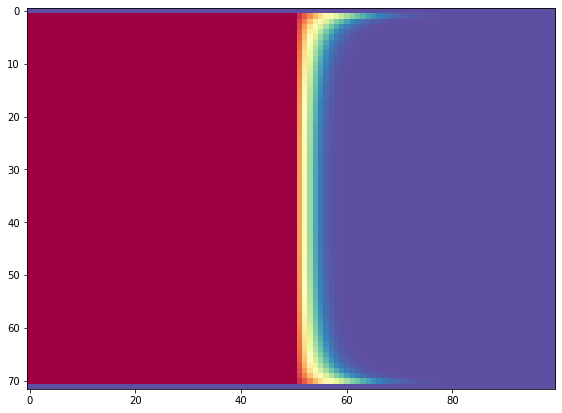


1.0000000000000002e-12
4.876992176054903e-13
0.0

7500


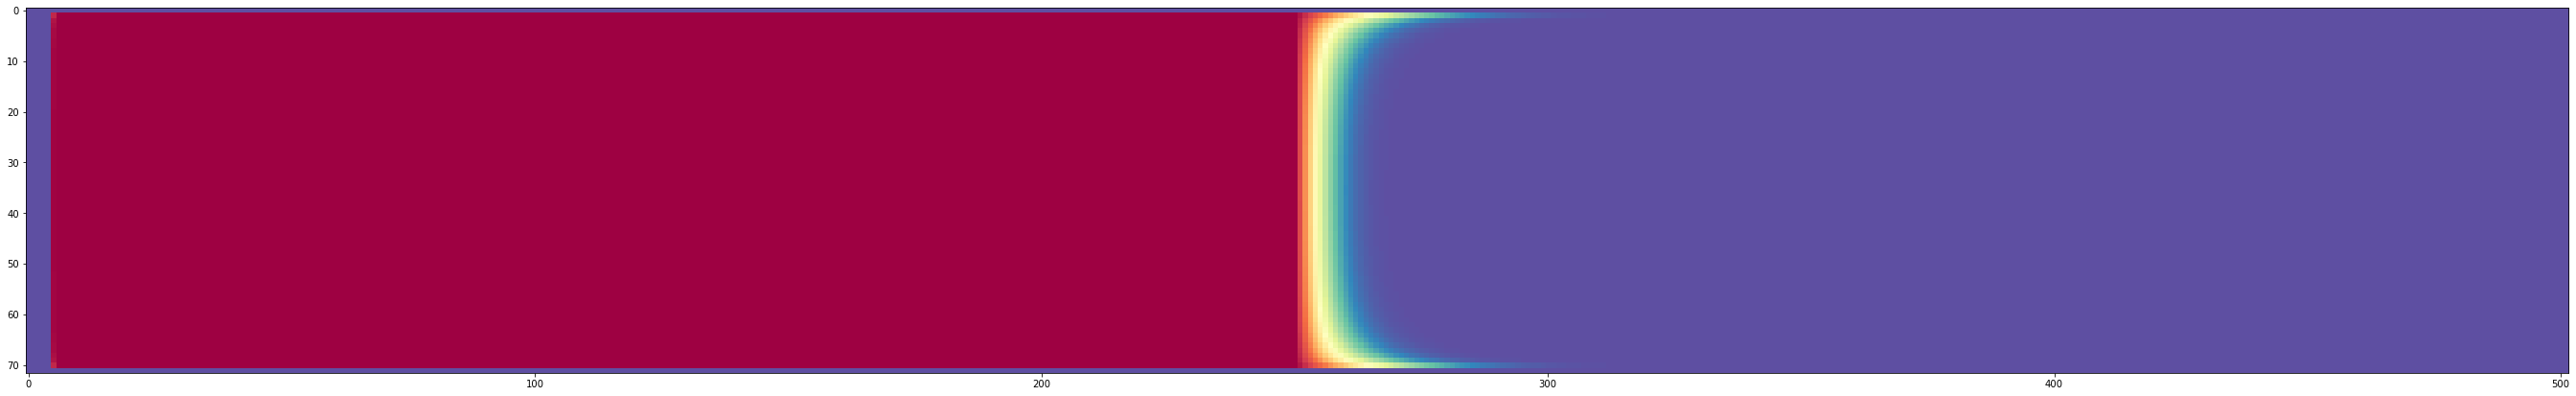

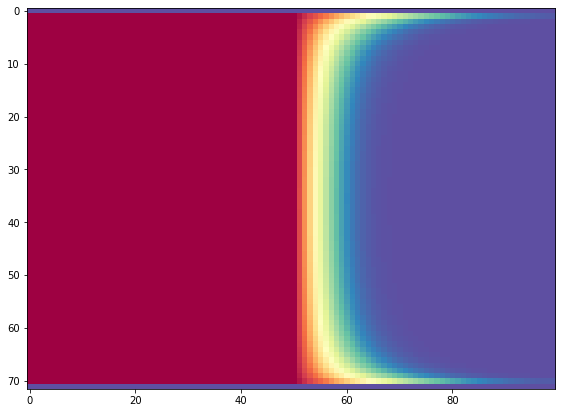


1.0000000000000002e-12
4.895885185770346e-13
0.0

10000


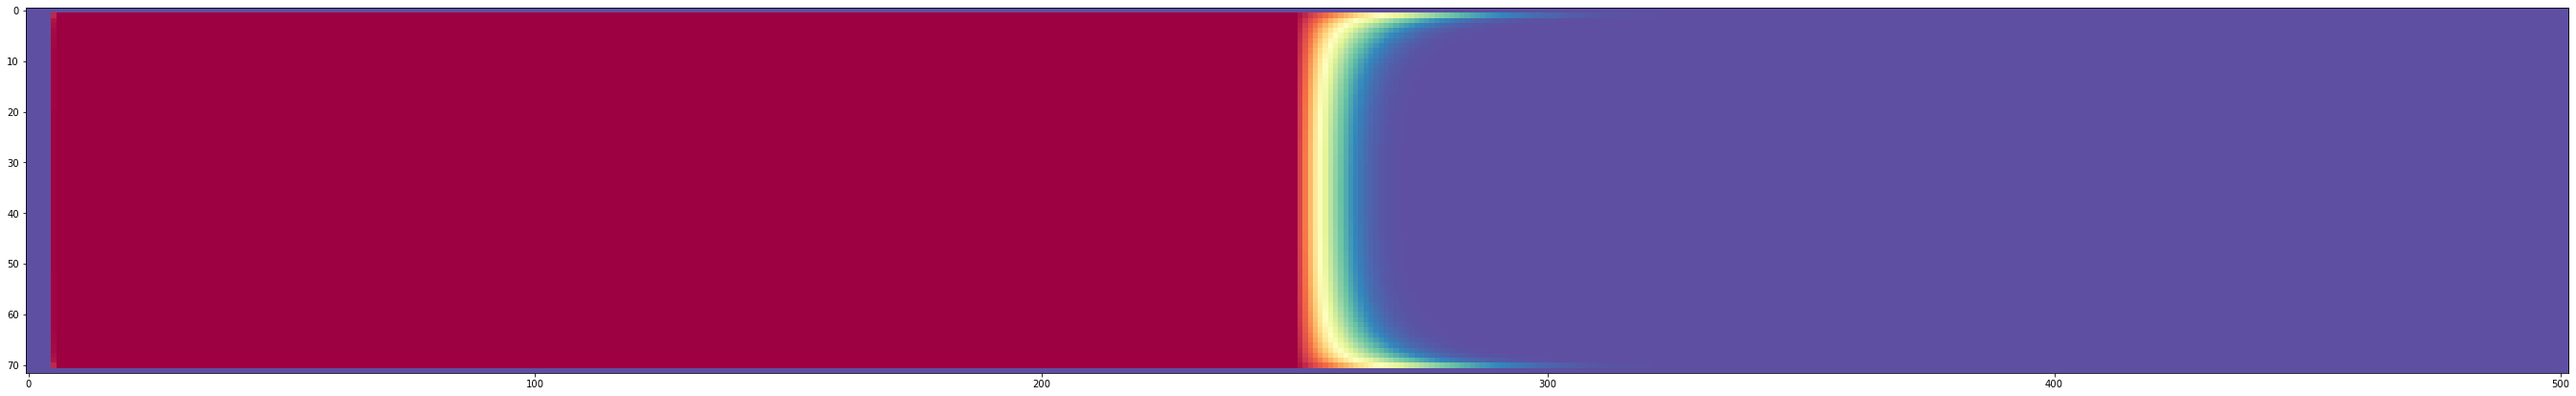

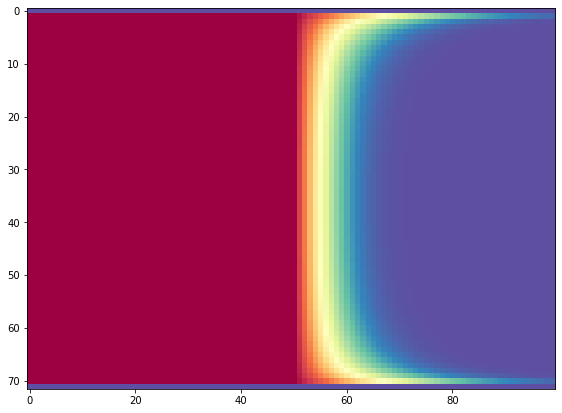

____________________________________________________
Cl(I)

2.0000000000000004e-12
9.534062129355065e-13
0.0

15


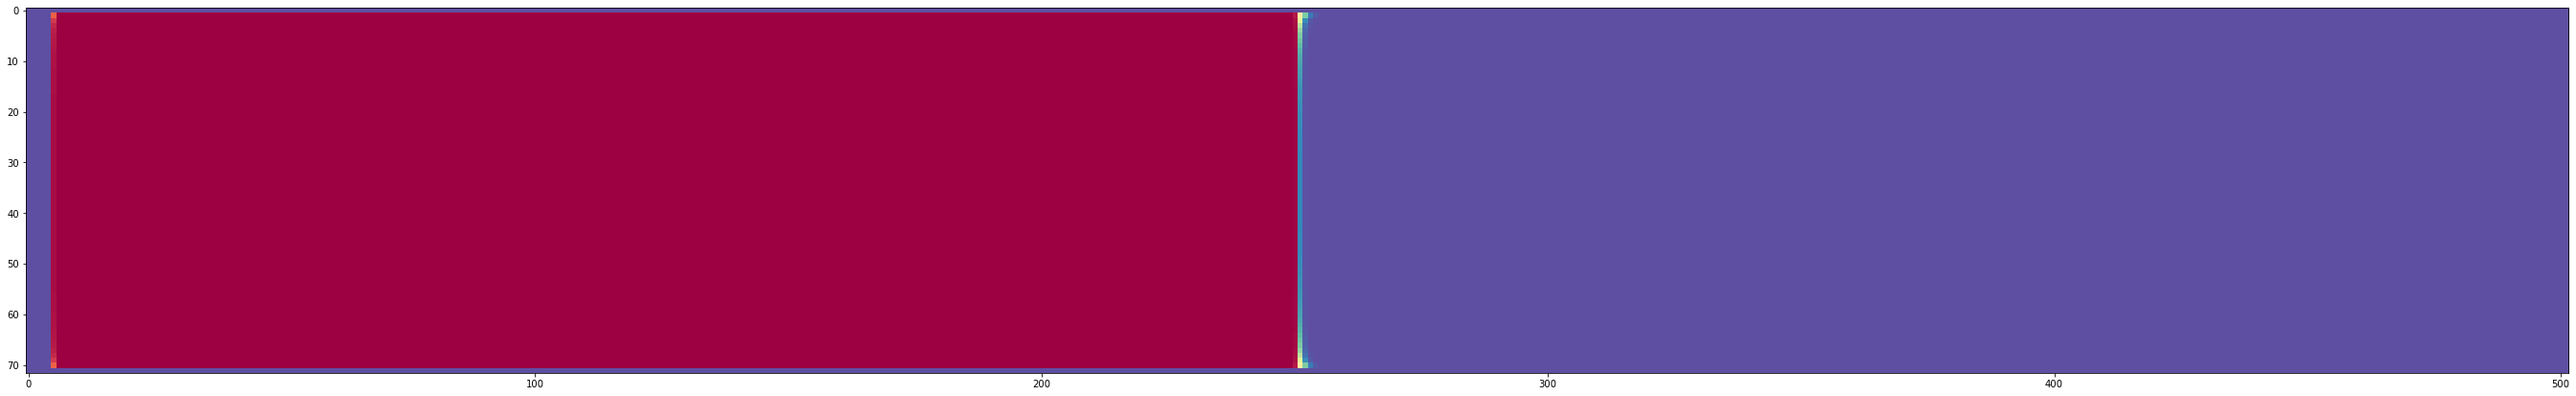

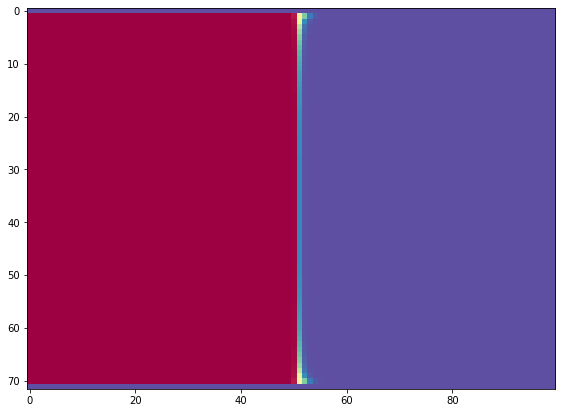


2.0000000000000004e-12
9.568396818087876e-13
0.0

150


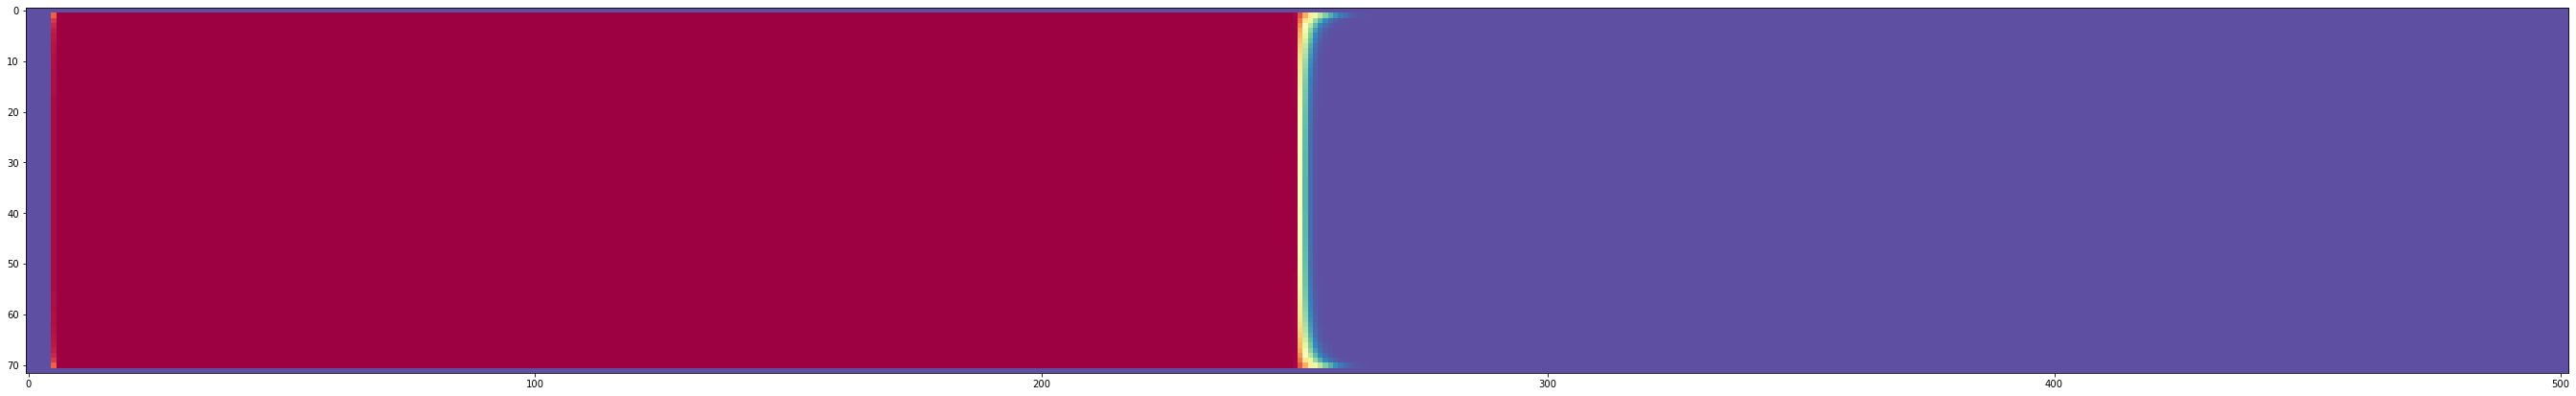

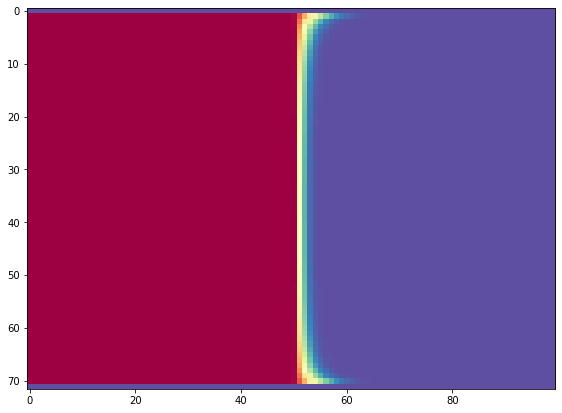


2.0000000000000004e-12
9.69252181034707e-13
0.0

1500


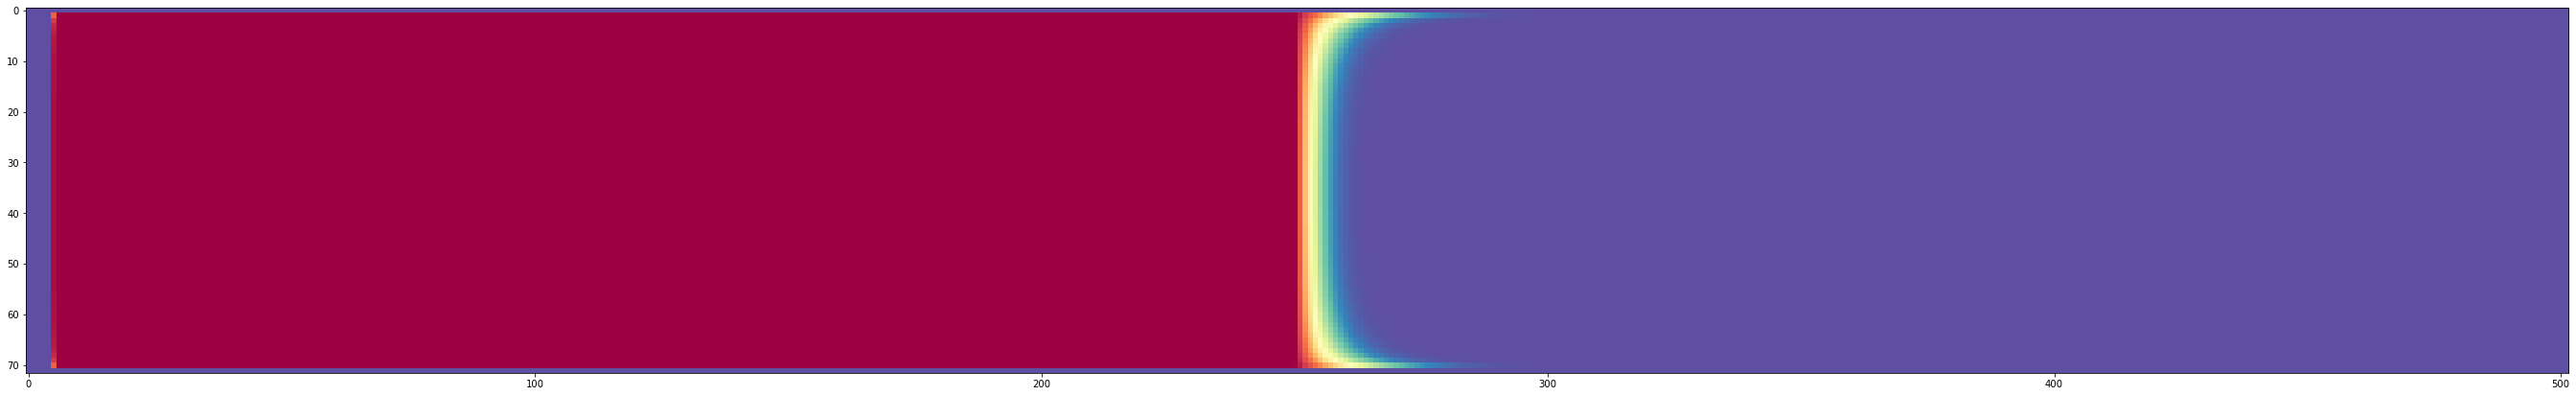

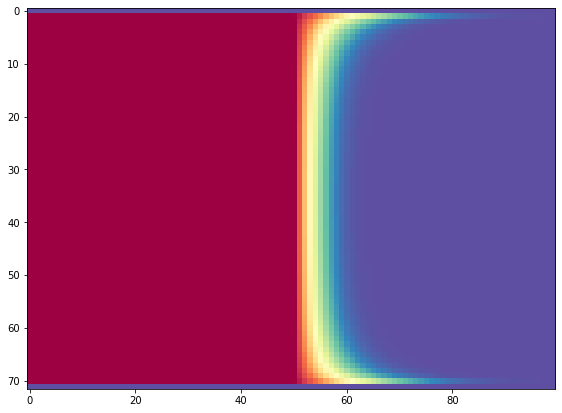


2.0000000000000004e-12
9.919424788196262e-13
0.0

7500


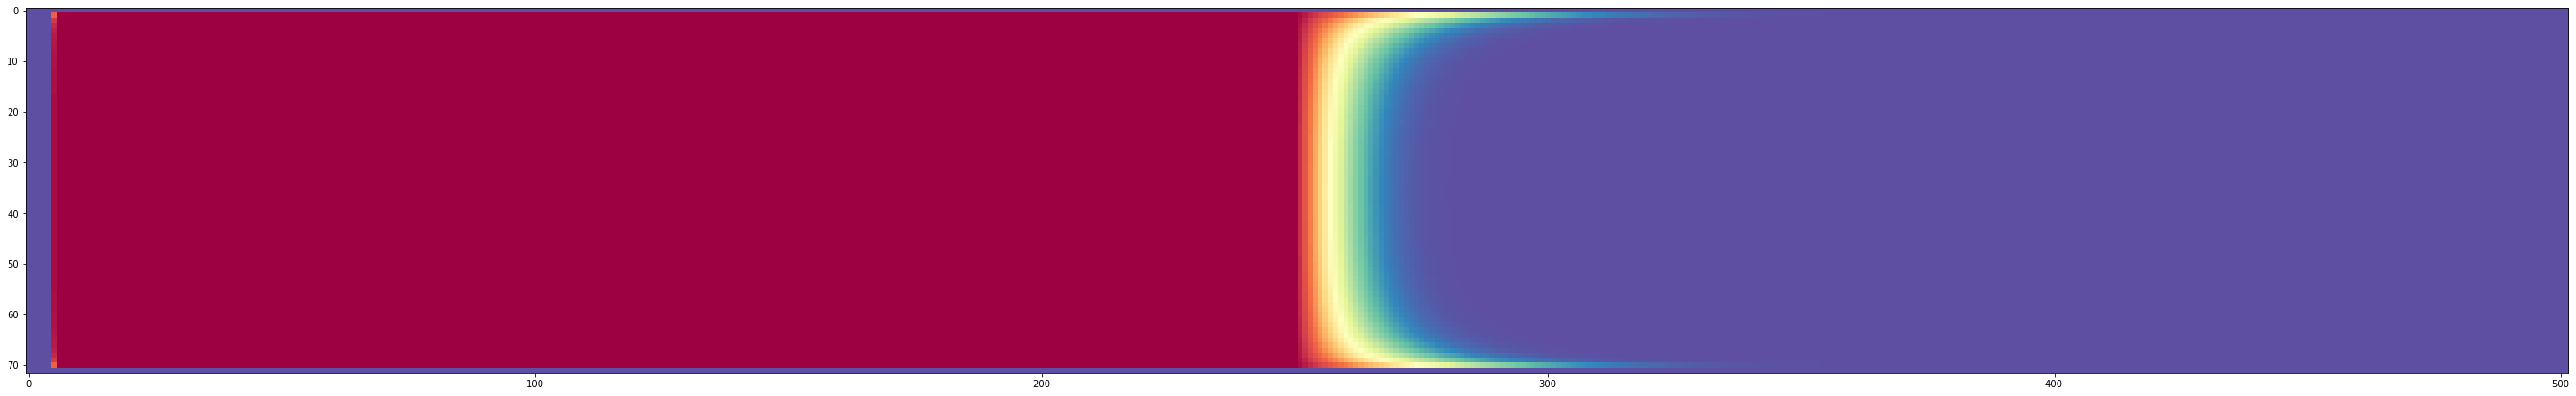

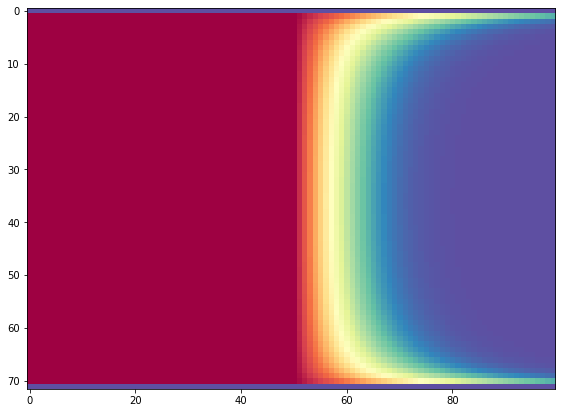


2.0000000000000004e-12
9.982993553301539e-13
0.0

10000


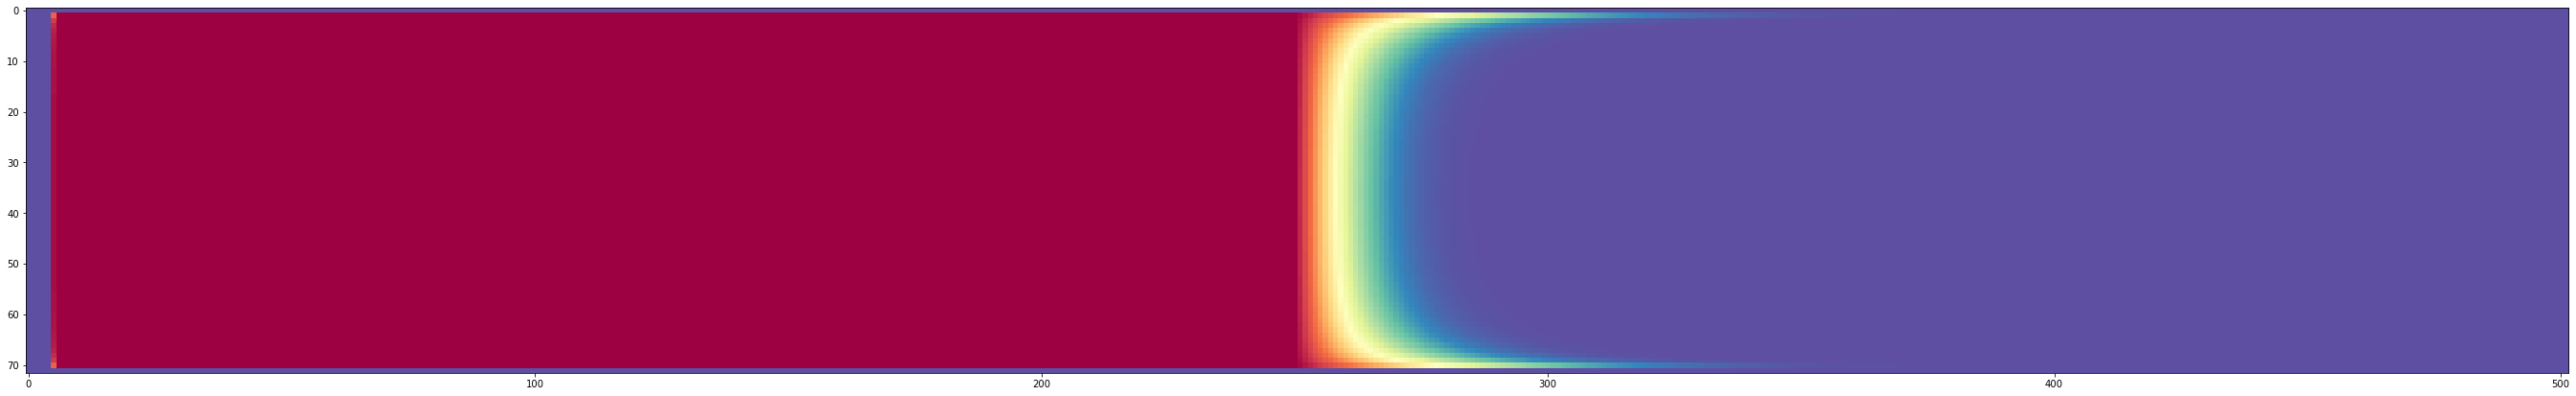

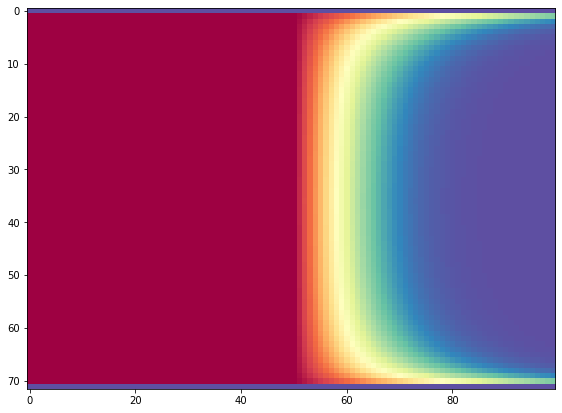

____________________________________________________
H(I)

11.000000000000021
7.600186254196073
0.0

15


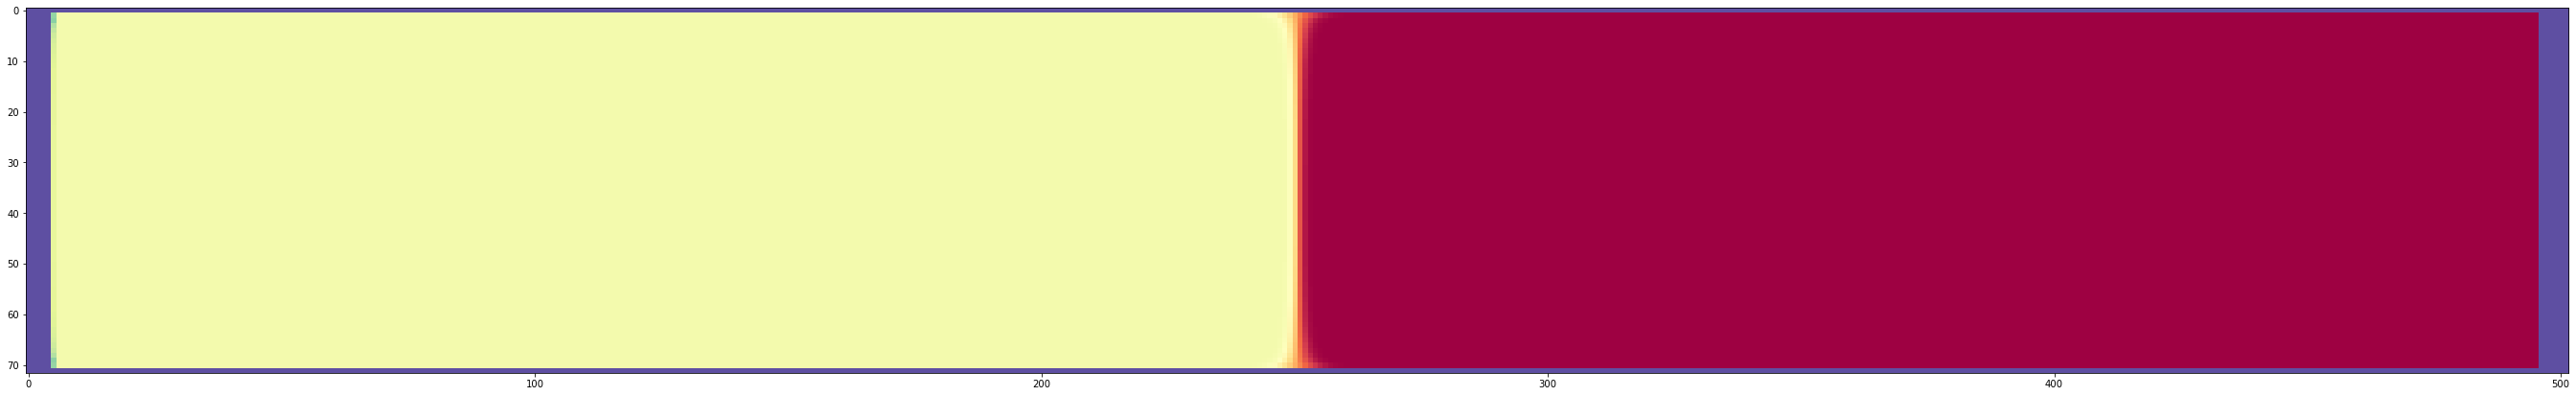

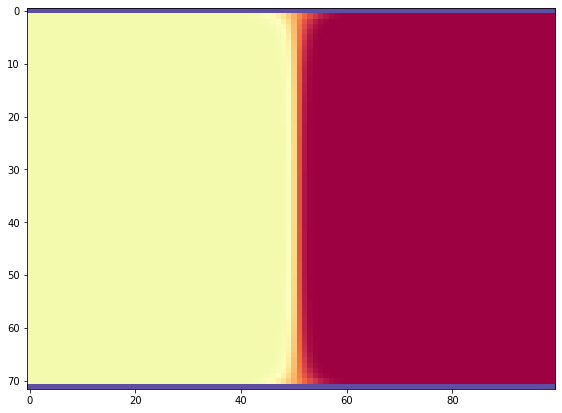


11.000000000000032
7.600186254196073
0.0

150


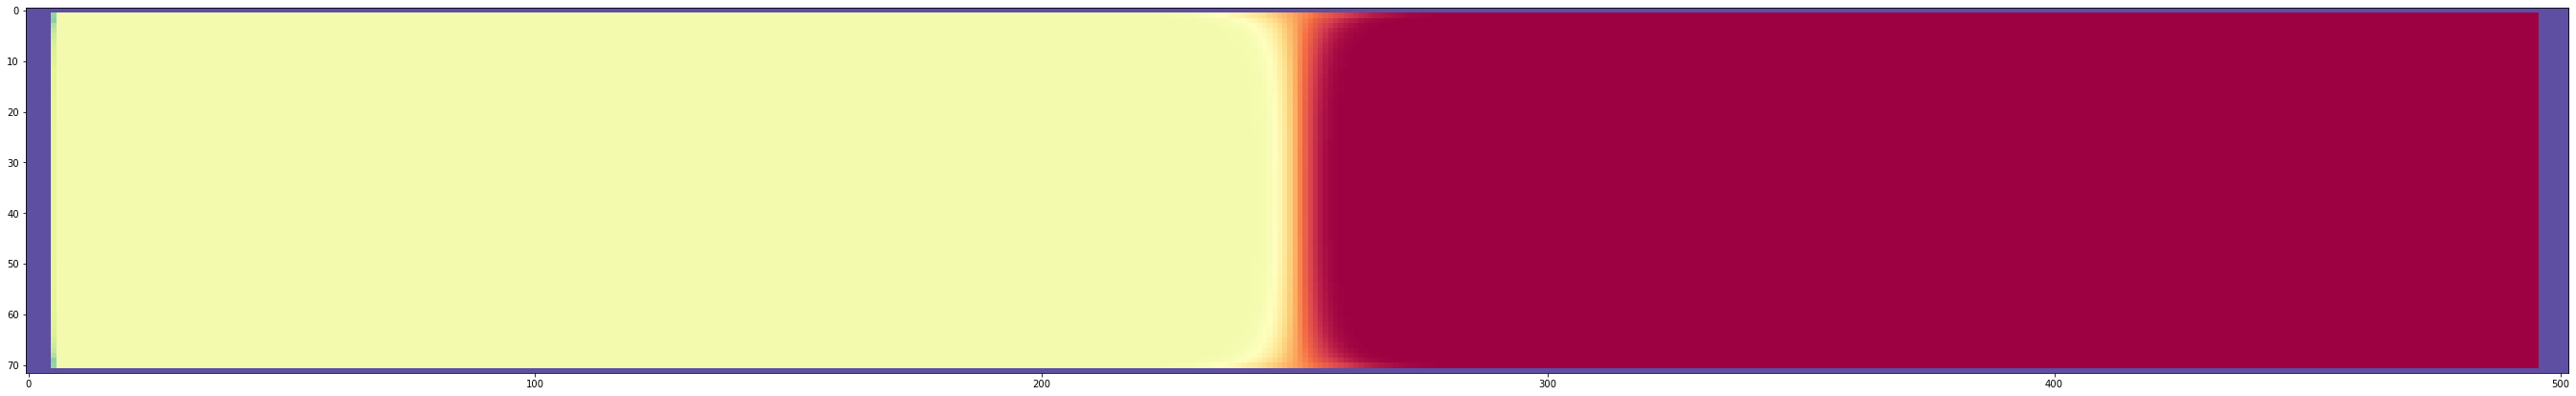

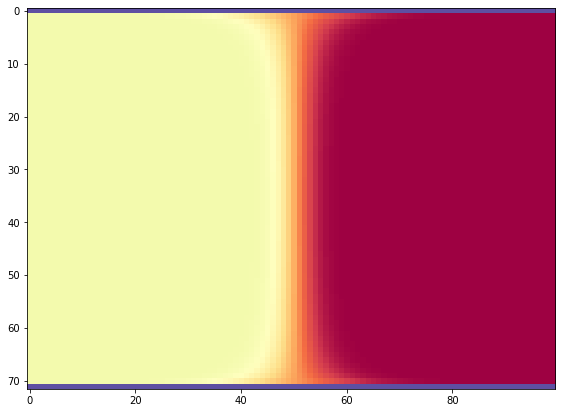


11.000000000000032
7.6001862541960845
0.0

1500


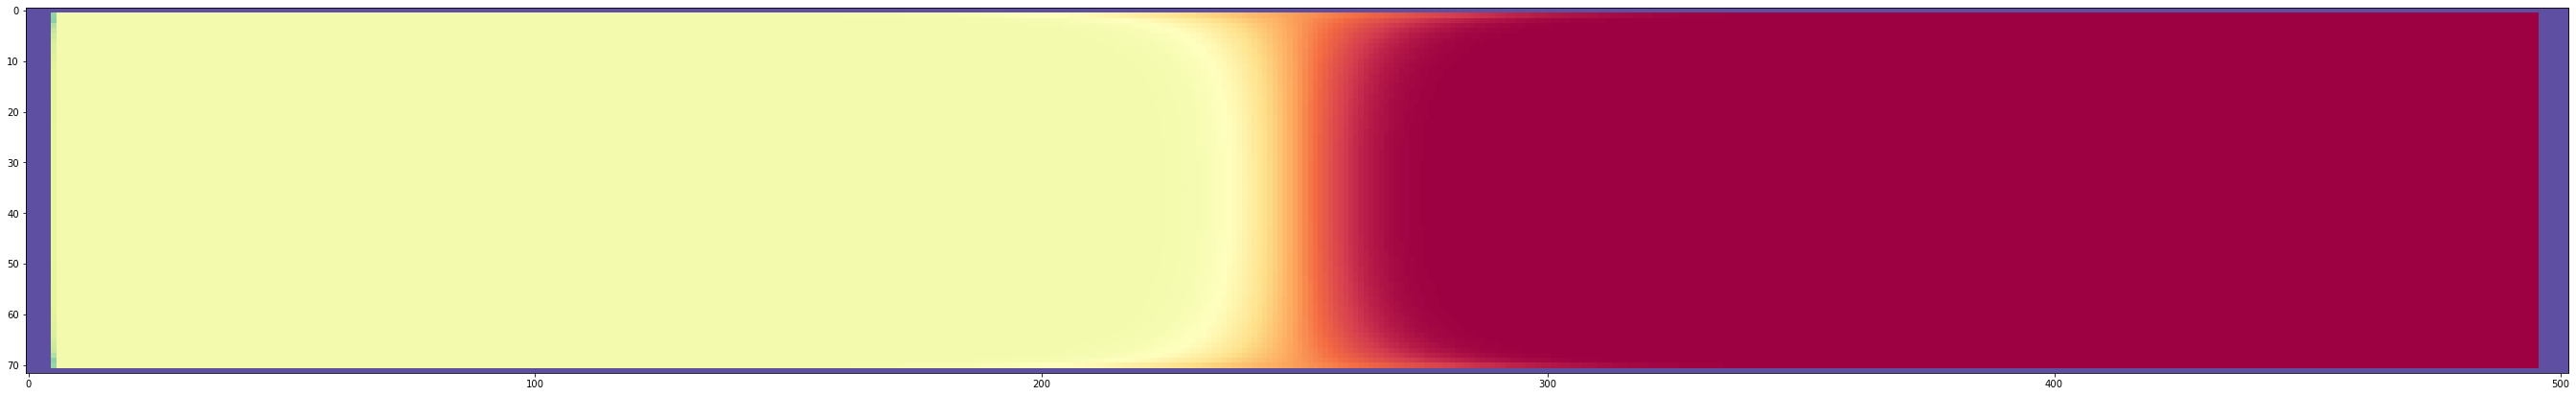

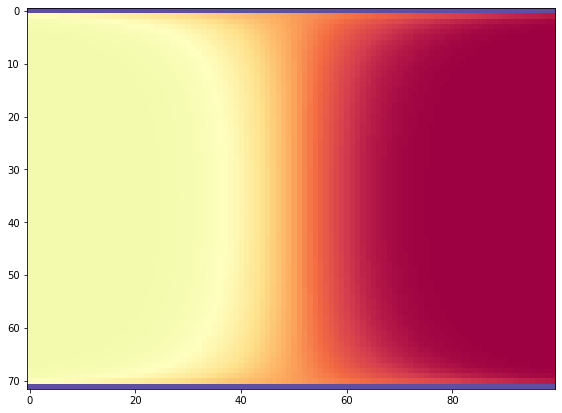


11.000000000000025
7.600186279357285
0.0

7500


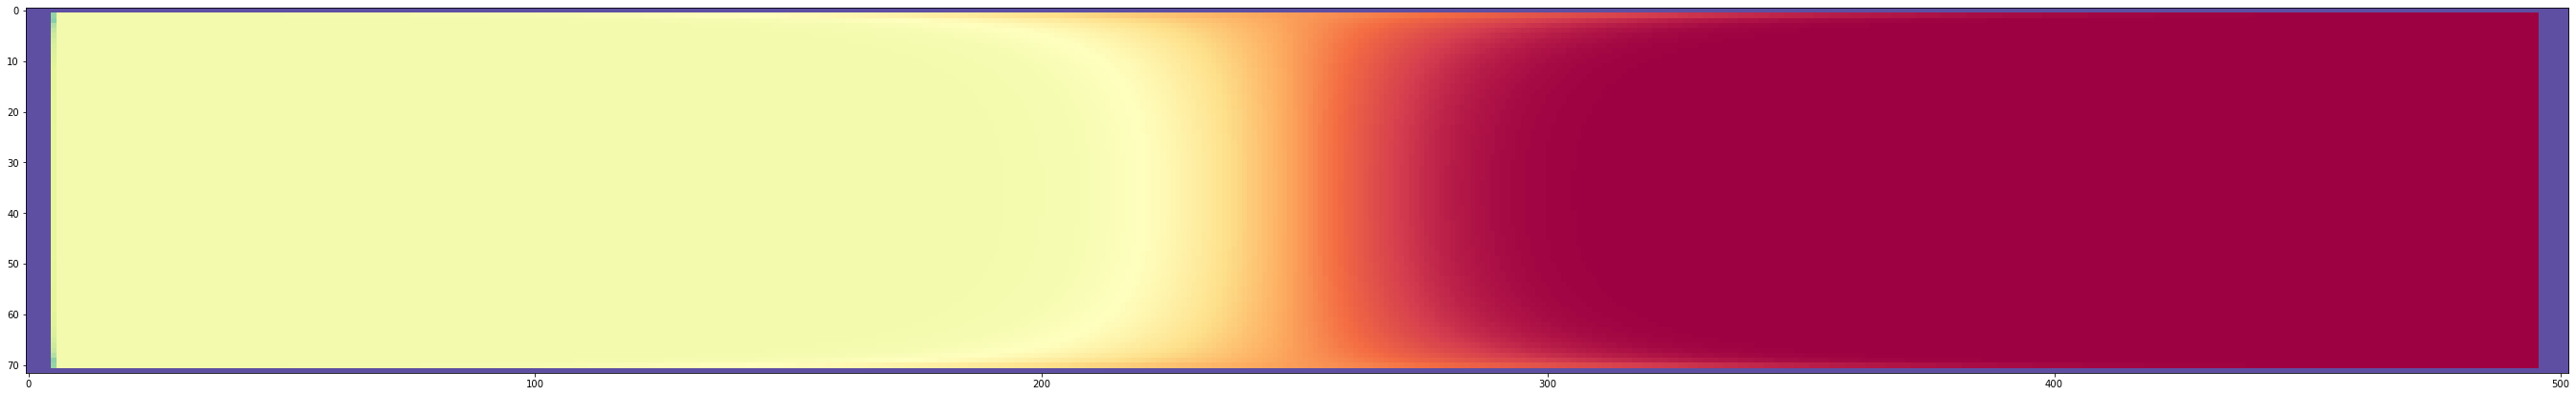

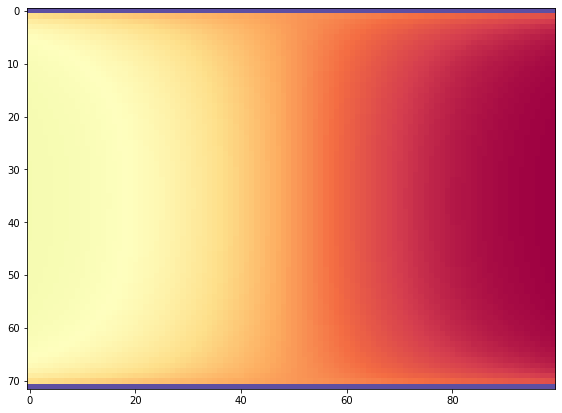


11.000000000000025
7.600186315512829
0.0

10000


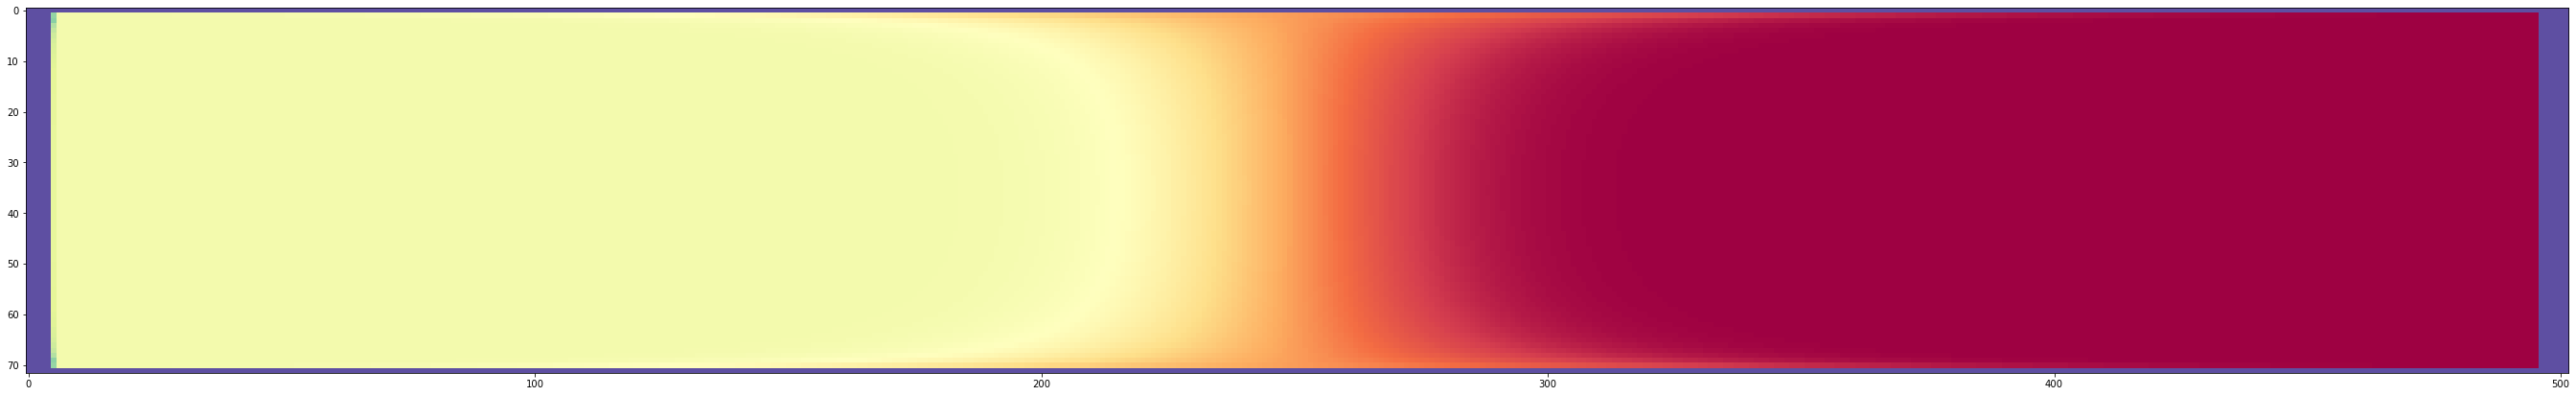

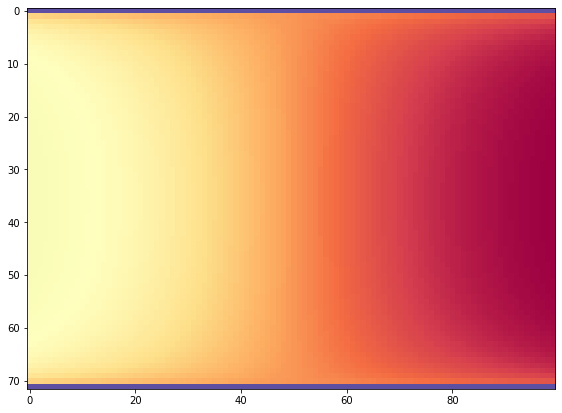

____________________________________________________
Na(I)

2.0000000000000004e-12
9.494459621819531e-13
0.0

15


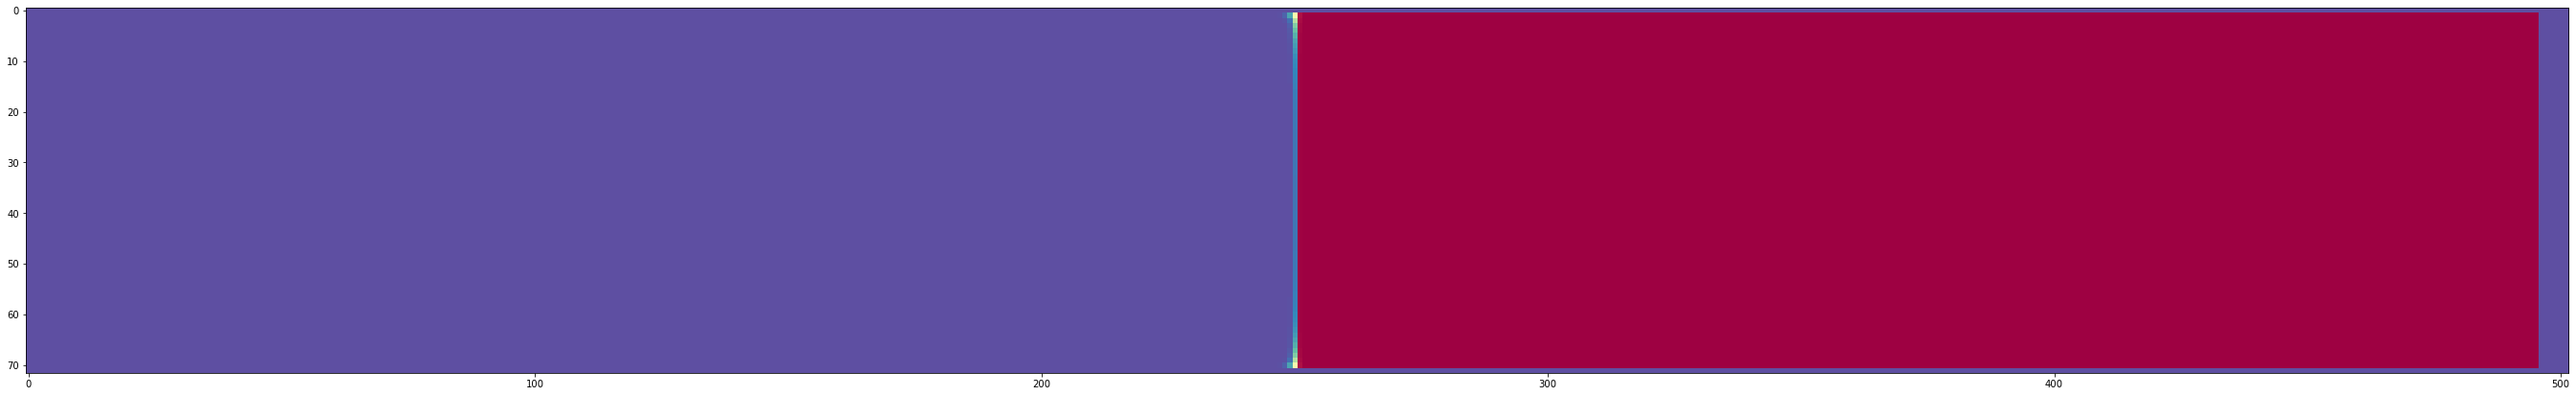

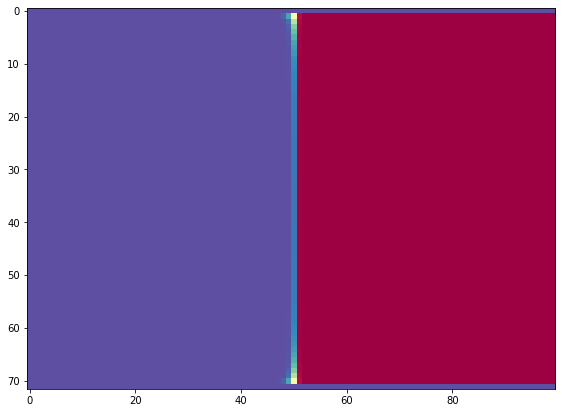


2.0000000000000004e-12
9.520442683068809e-13
0.0

150


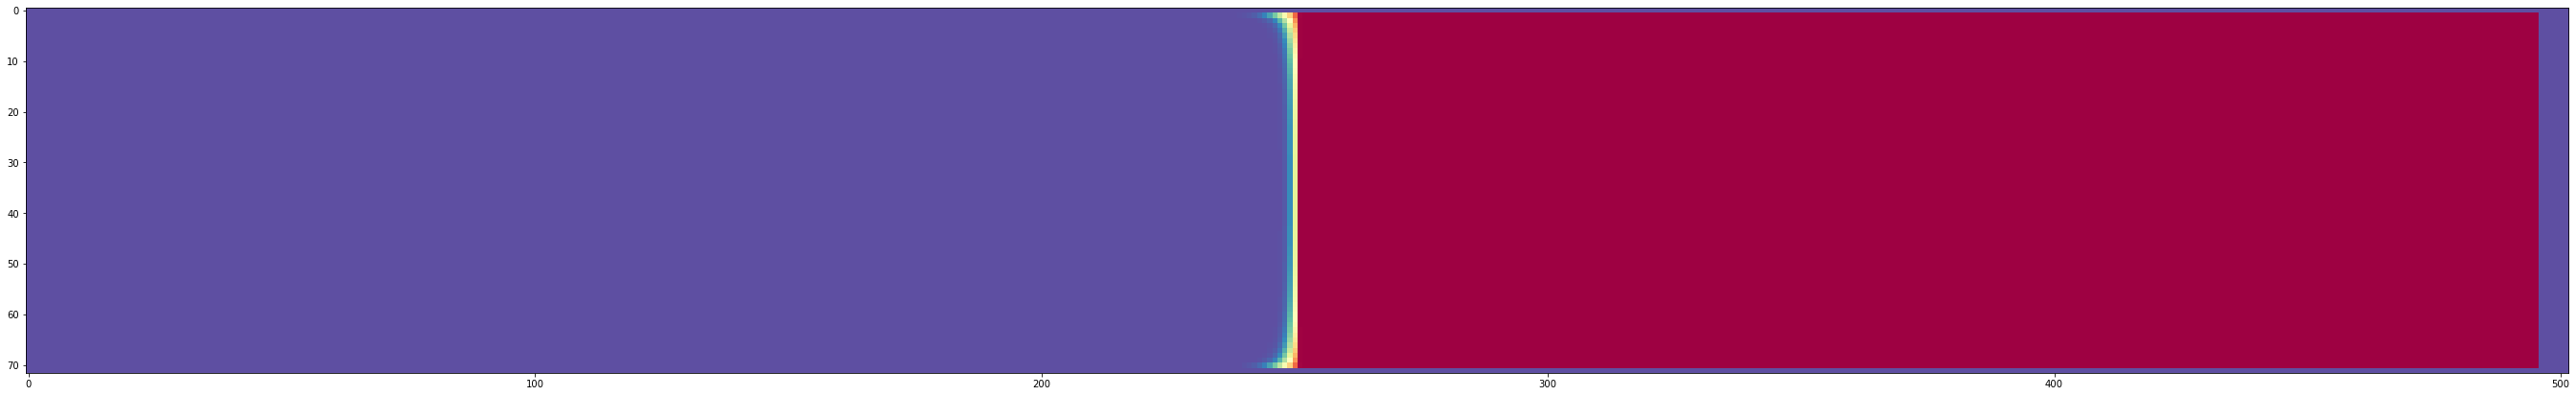

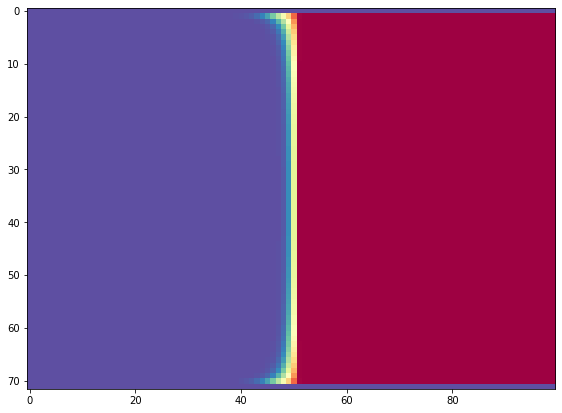


2.0000000000000004e-12
9.620185005293753e-13
0.0

1500


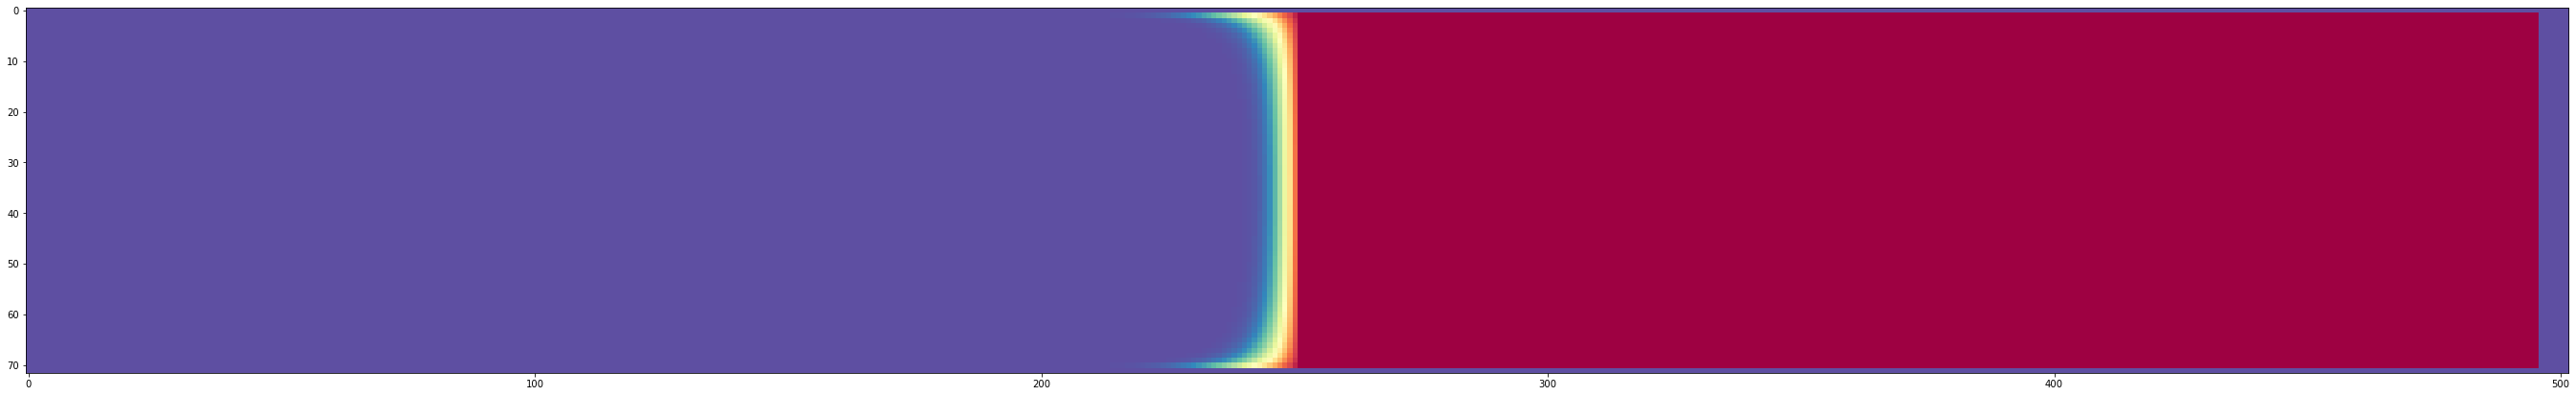

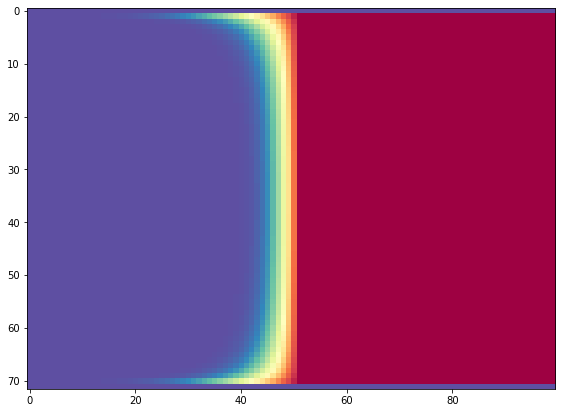


2.0000000000000004e-12
9.803678784677402e-13
0.0

7500


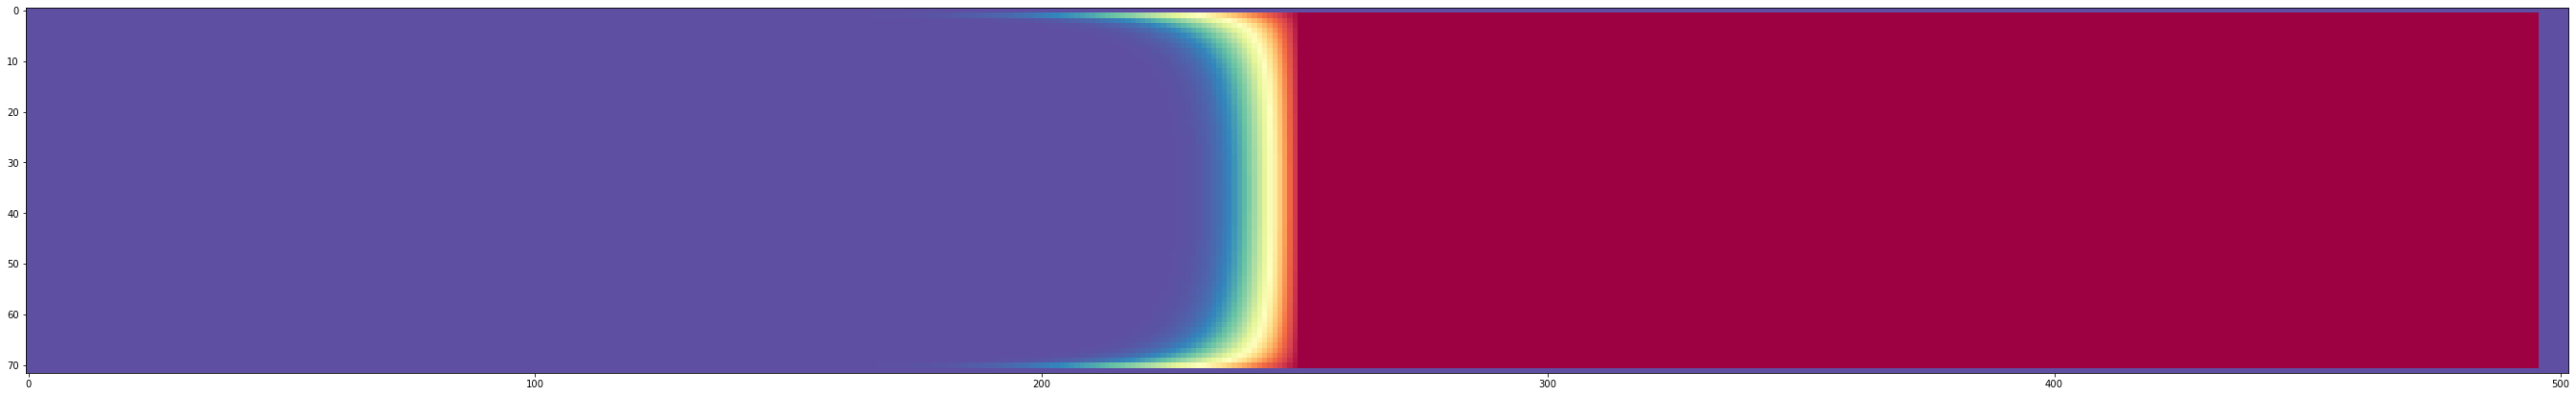

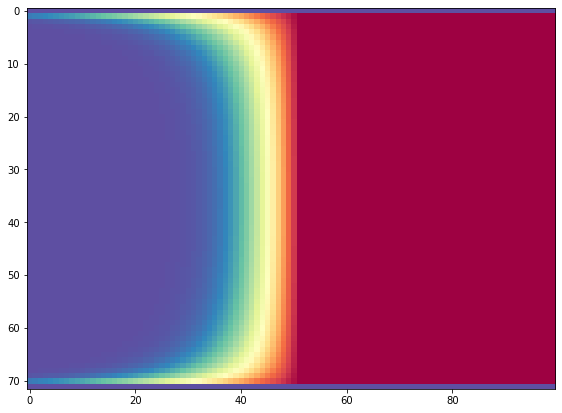


2.0000000000000004e-12
9.855115020375185e-13
0.0

10000


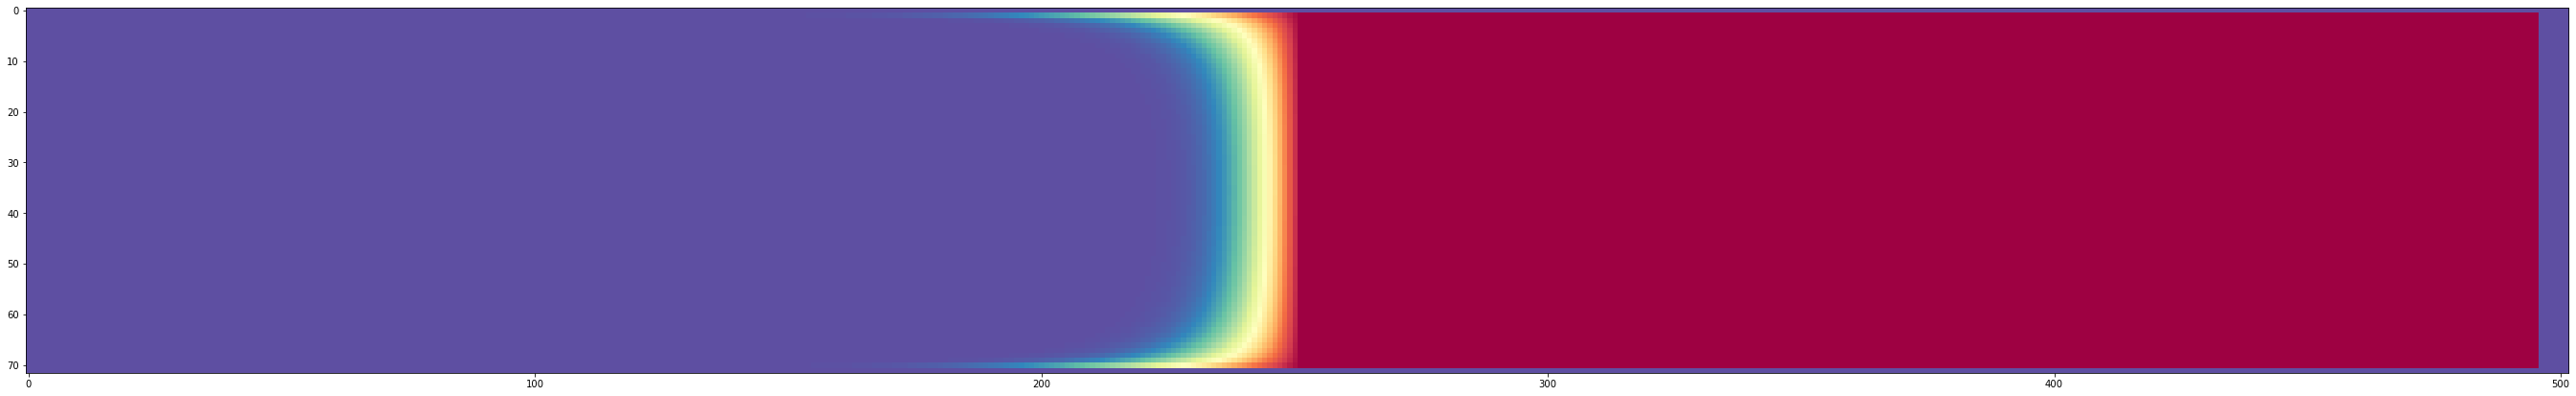

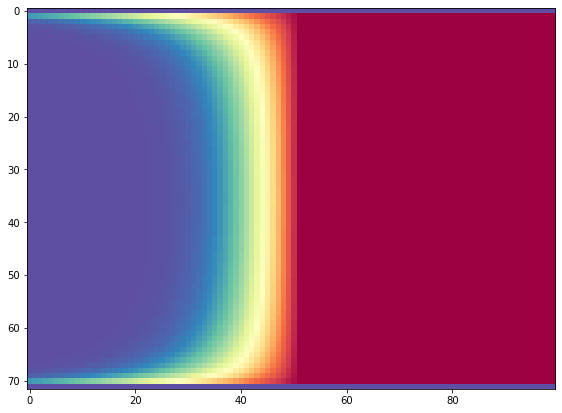

____________________________________________________
HS(I)

1.0000000000000002e-12
4.74785244004772e-13
0.0

15


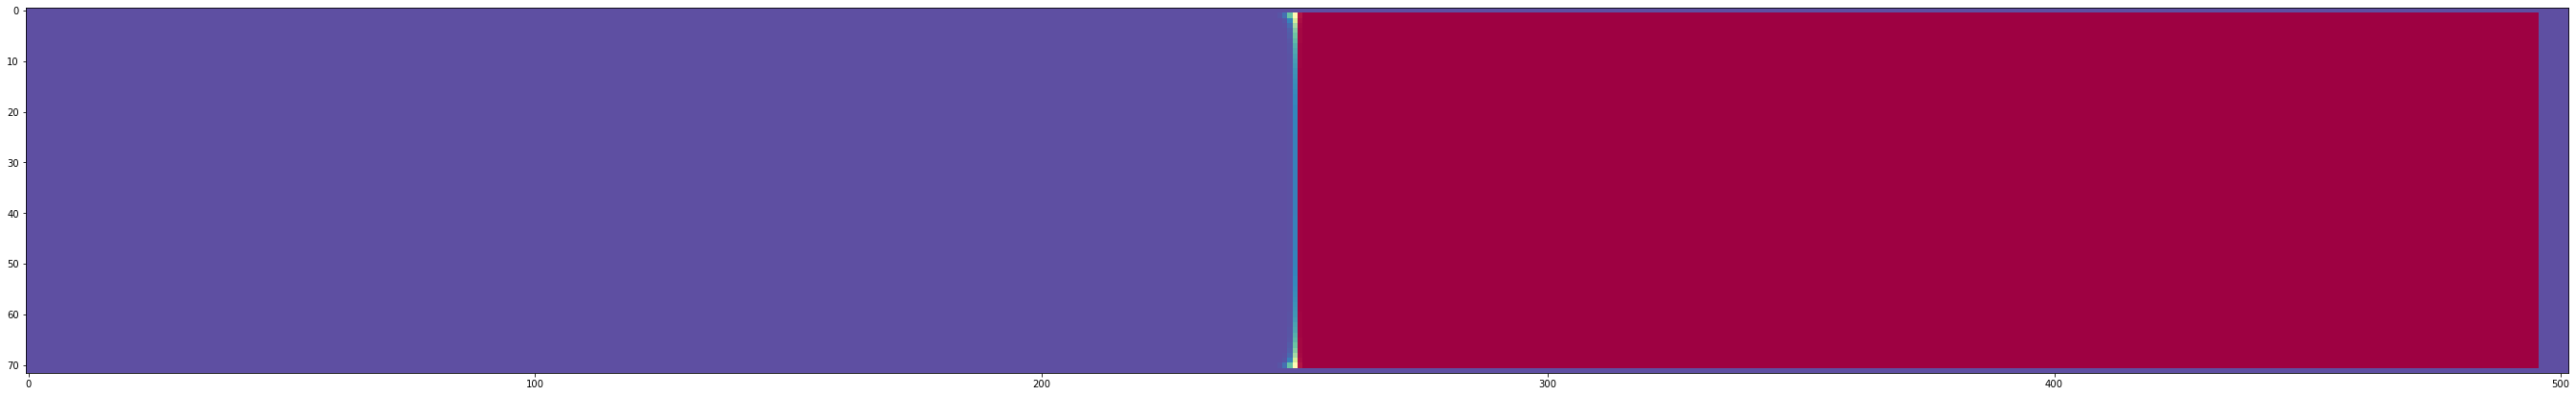

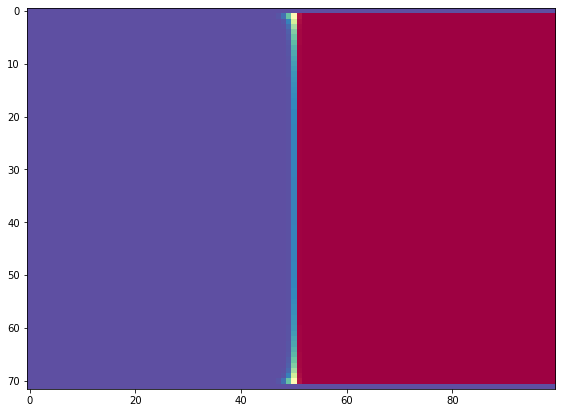


1.0000000000000002e-12
4.76333694817126e-13
0.0

150


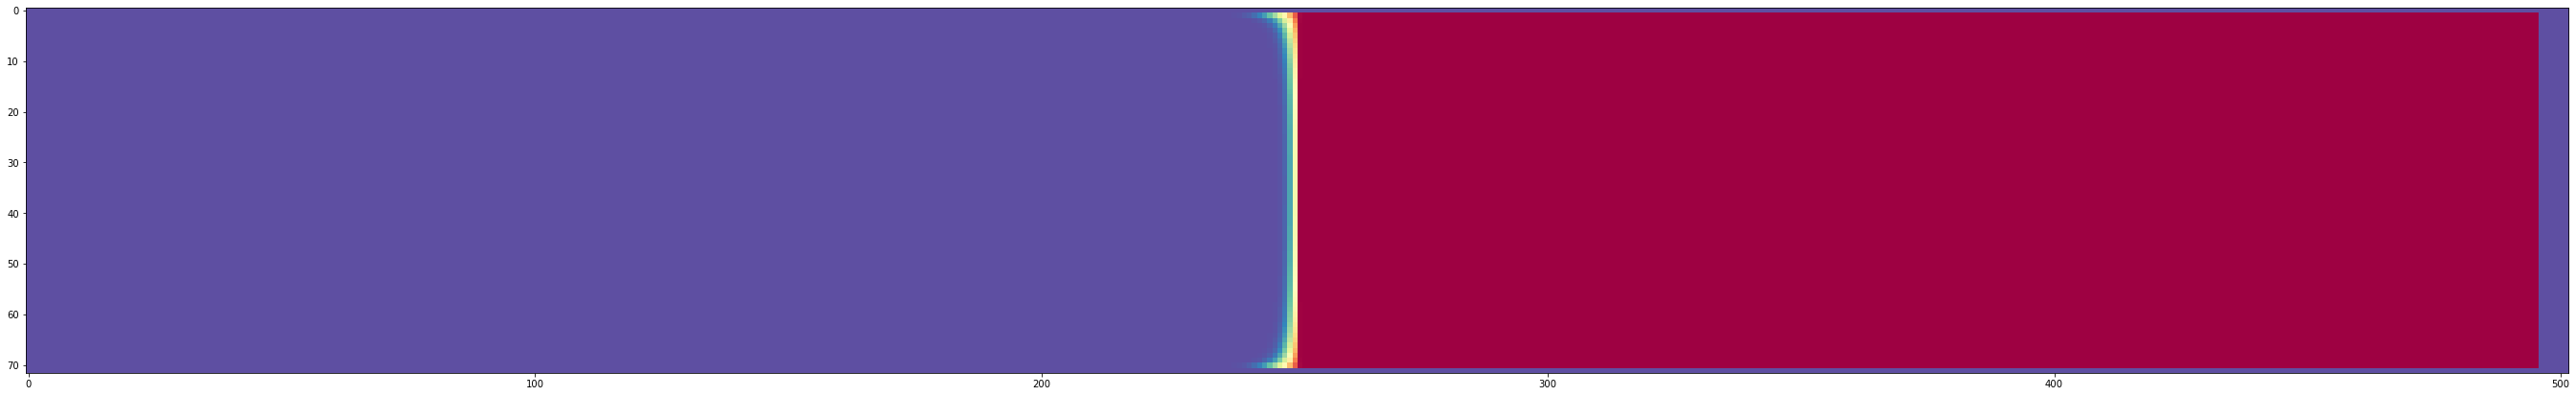

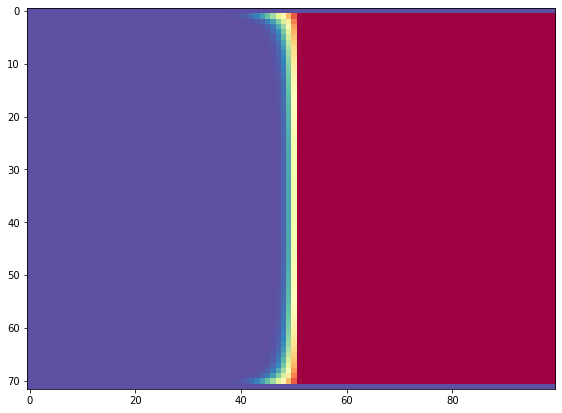


1.0000000000000002e-12
4.820496074716454e-13
0.0

1500


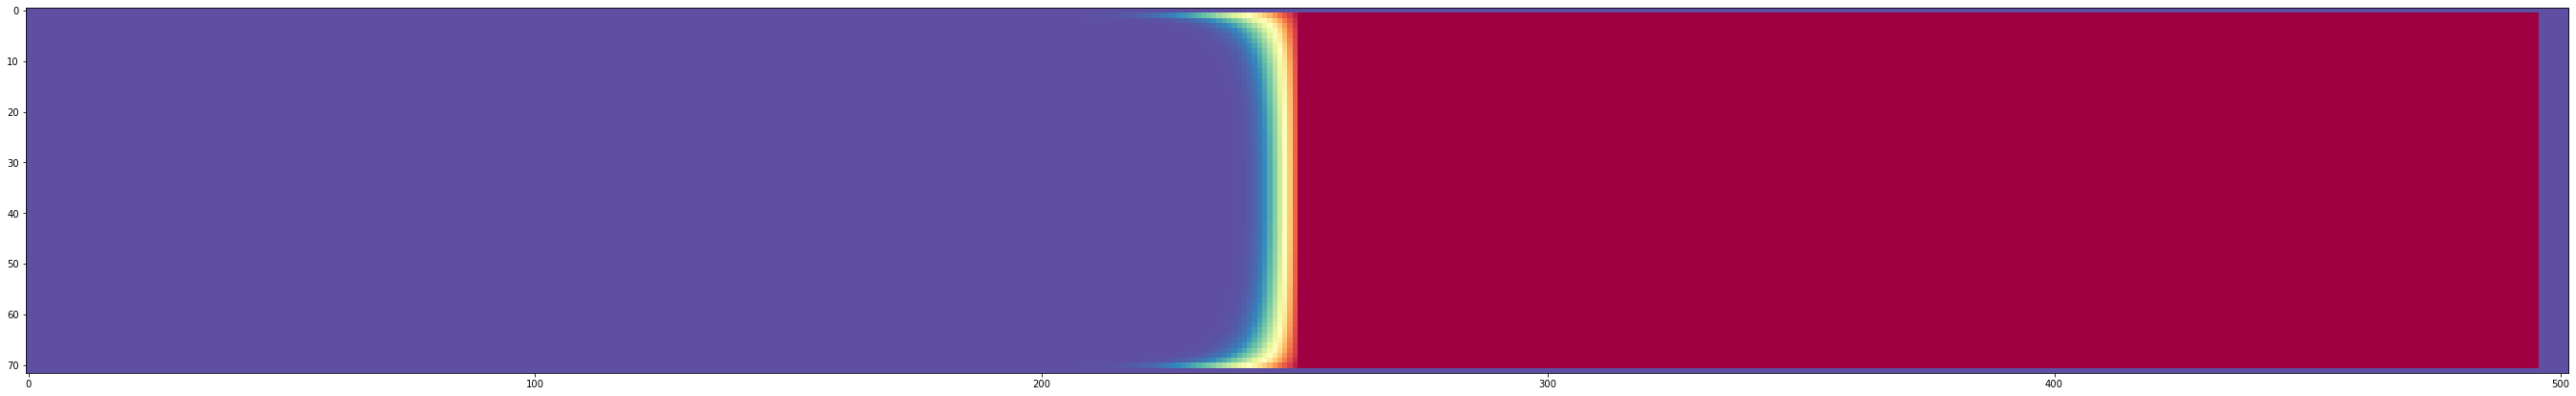

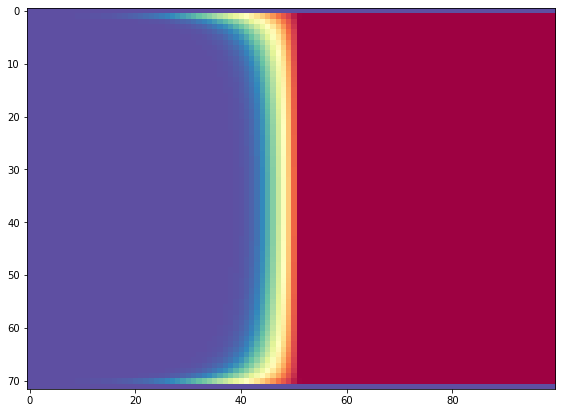


1.0000000000000002e-12
4.925198025202727e-13
0.0

7500


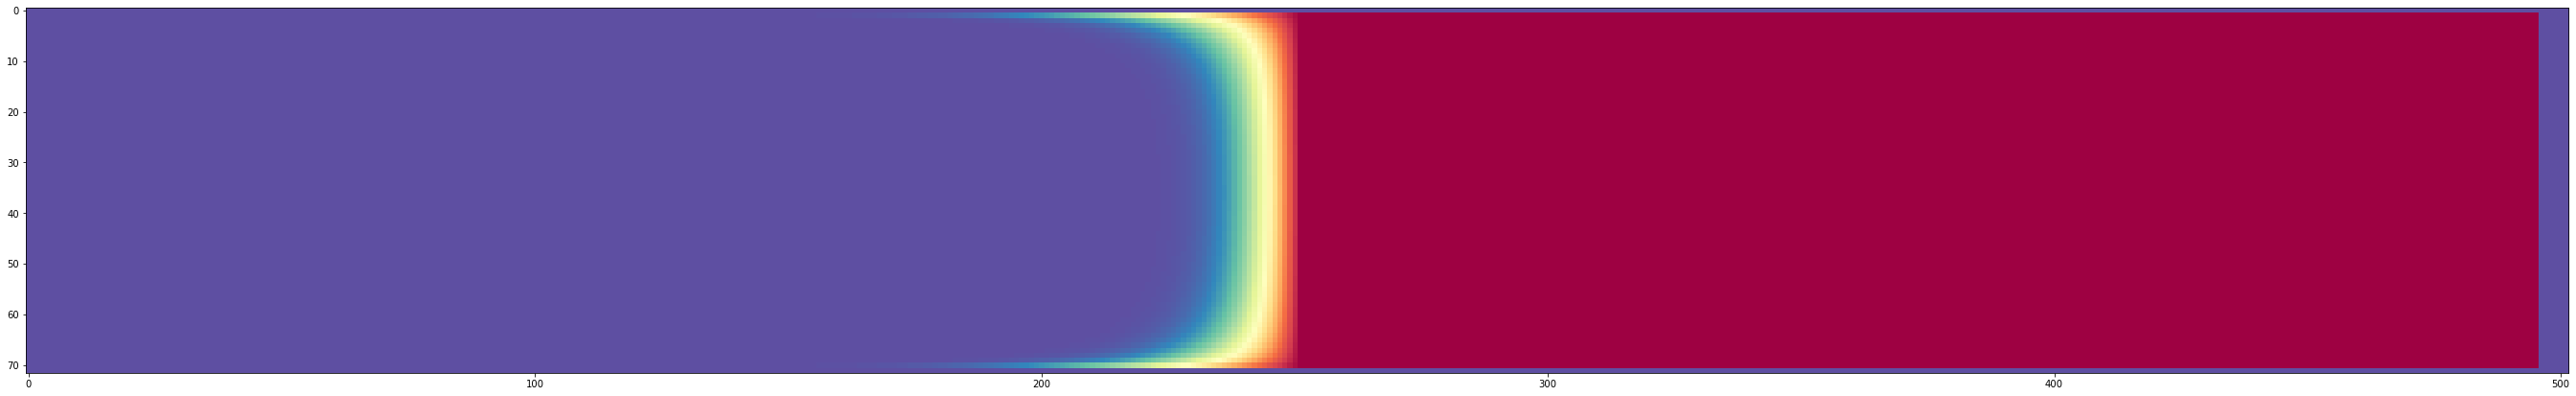

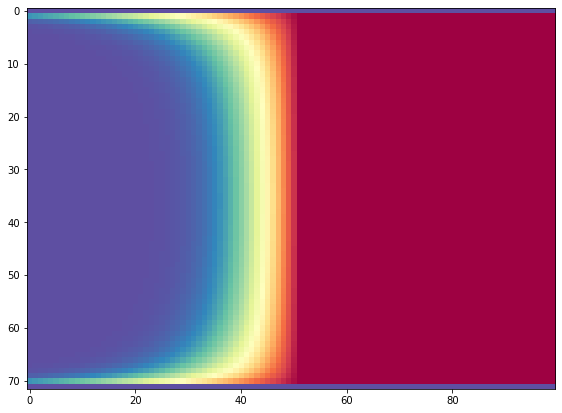


1.0000000000000002e-12
4.954536573951732e-13
0.0

10000


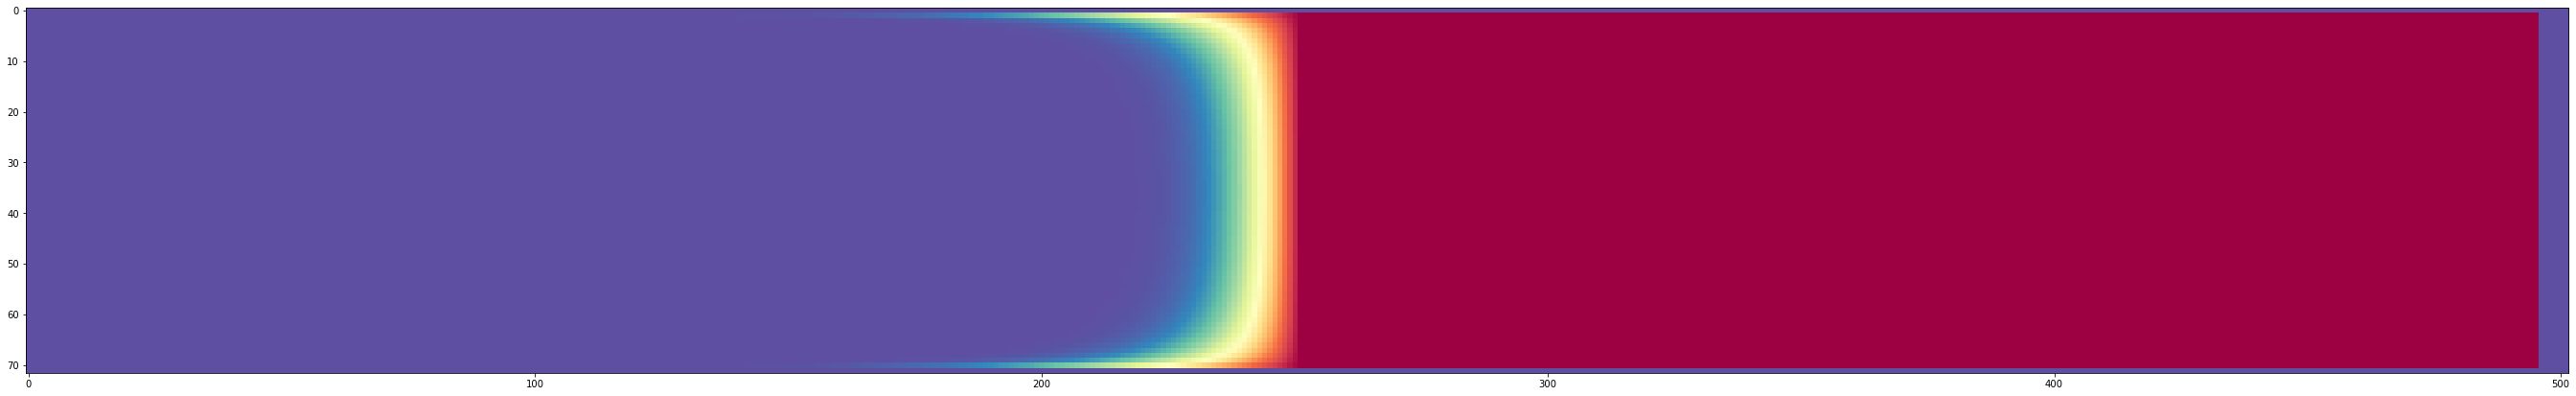

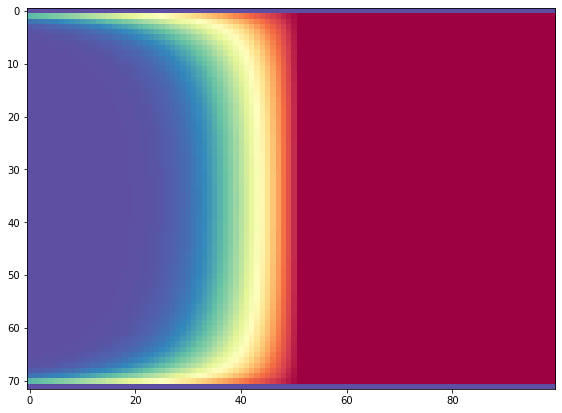

In [15]:
model = return_models
color = "Spectral_r" #"Spectral_r" ;  "mako"

for i,version in enumerate(return_models):
    print("____________________________________________________")
    print(return_names[i])    
    
    for index,channel_slice in enumerate(version):
        
        print()
        print(np.amax(channel_slice))
        print(np.average(channel_slice))
        print(np.min(channel_slice))
        print()

        print(return_distances[index])
        f, ax = plt.subplots(figsize=(50, 7))
        plt.imshow(channel_slice, interpolation= 'nearest', cmap = sns.color_palette(color, as_cmap=True))
        plt.show()

        f, ax = plt.subplots(figsize=(50, 7))
        plt.imshow(channel_slice[::,200:300], interpolation= 'nearest', cmap = sns.color_palette(color, as_cmap=True))
        plt.show()

### Fe-Anion composite figures

______________________________________________________________________________________________________
15  um down-channel
0.749056779945402
0.0014805827149411655
0.0


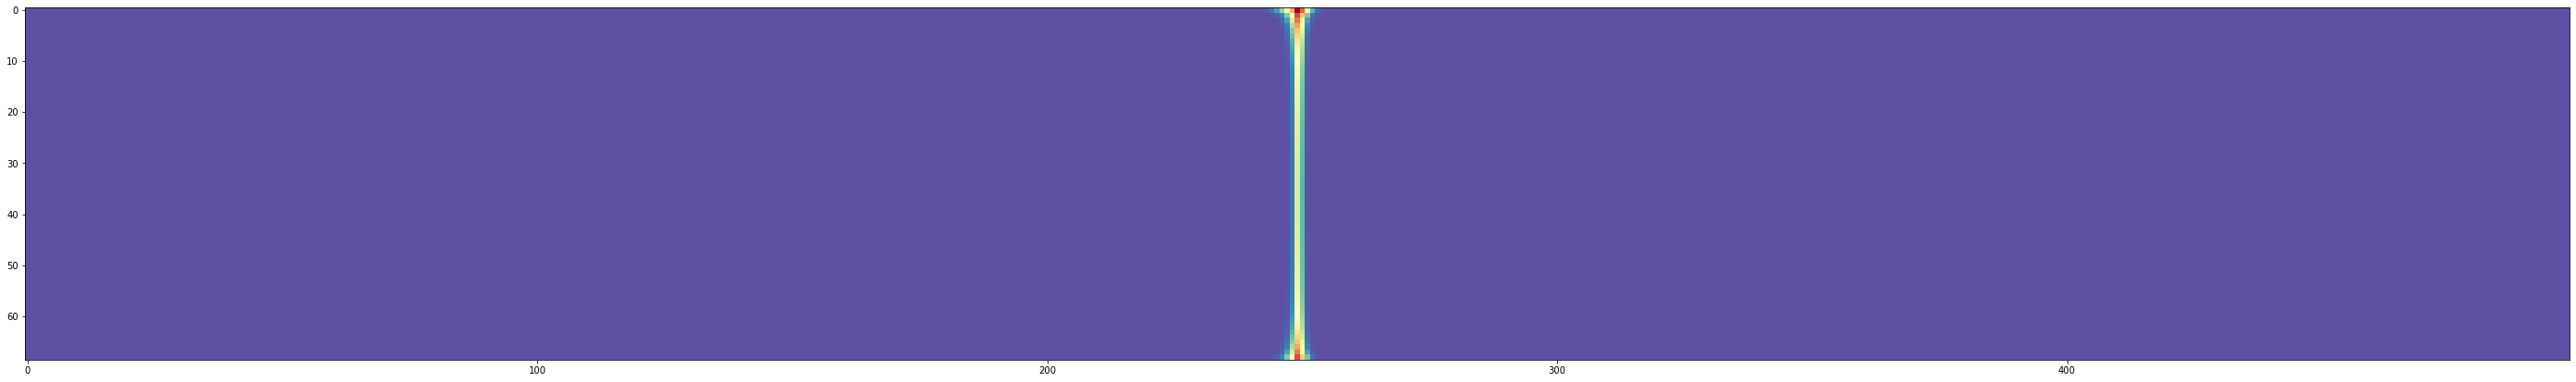

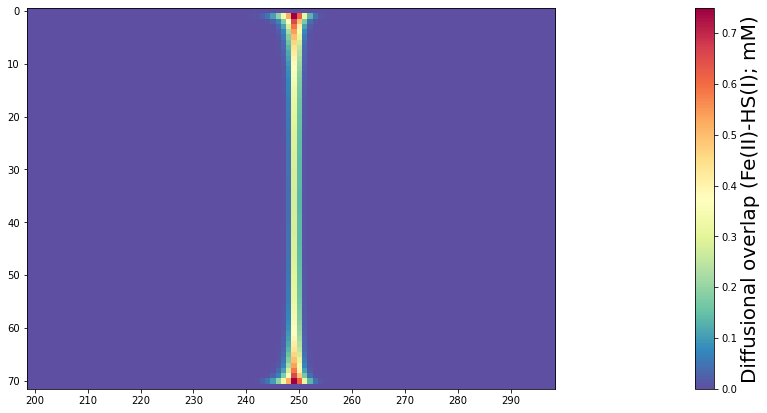

______________________________________________________________________________________________________
150  um down-channel
0.915698493400544
0.0070844752491595565
0.0


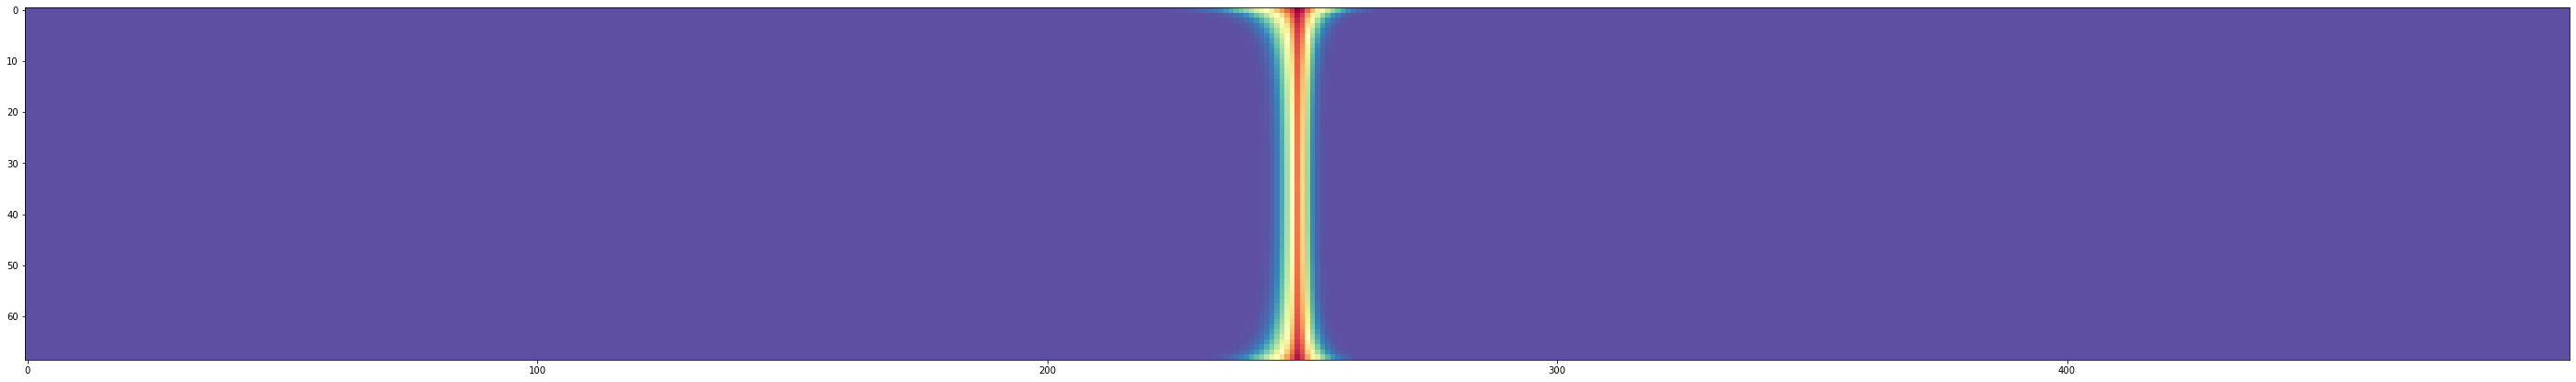

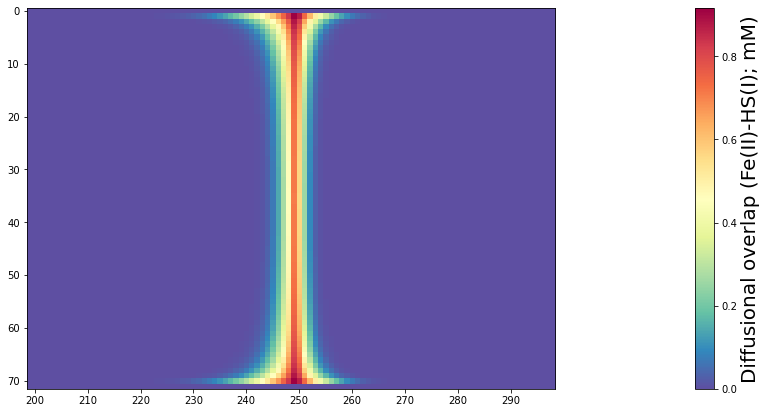

______________________________________________________________________________________________________
1500  um down-channel
0.9731684246002154
0.026043816249044425
0.0


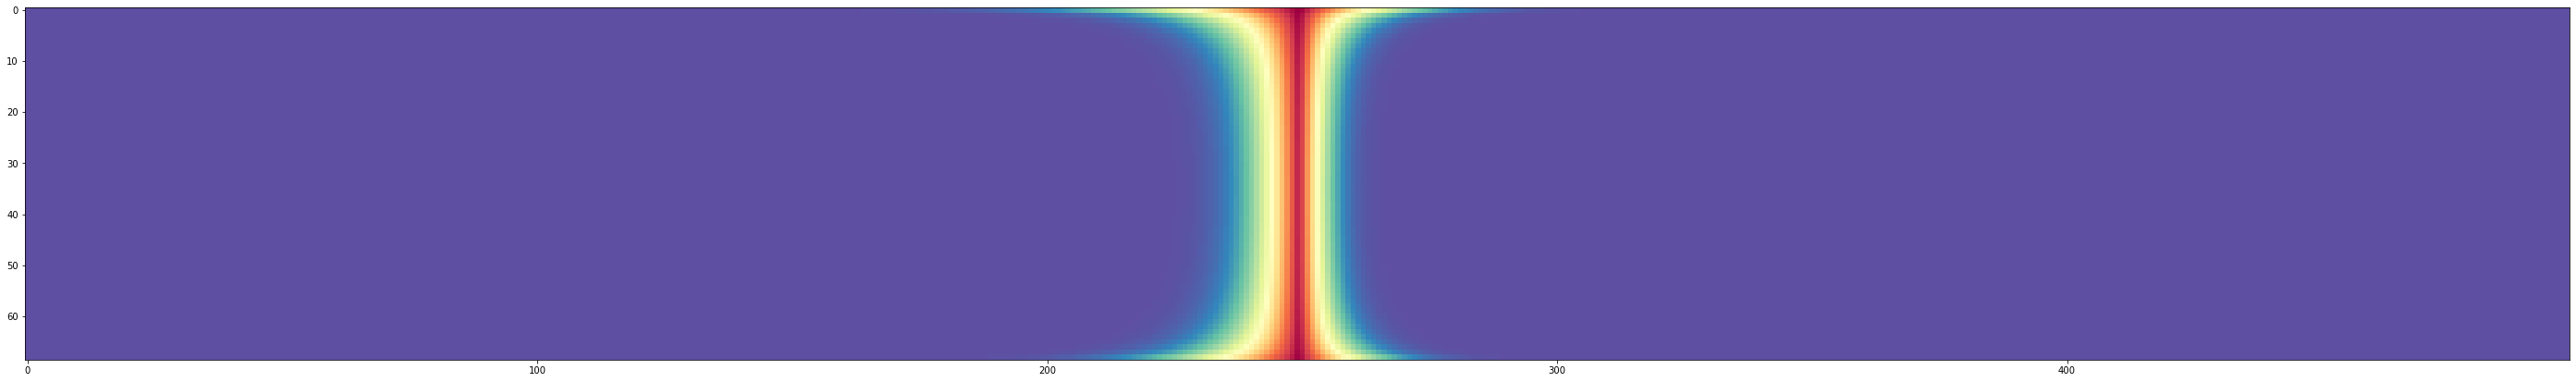

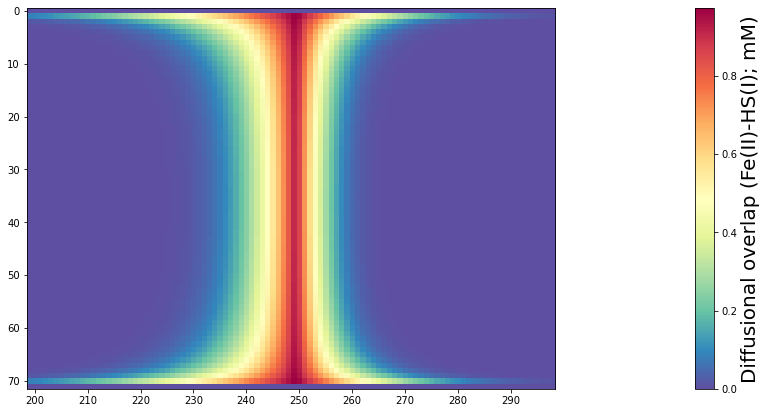

______________________________________________________________________________________________________
7500  um down-channel
0.9879936000800829
0.06052130535989639
0.0


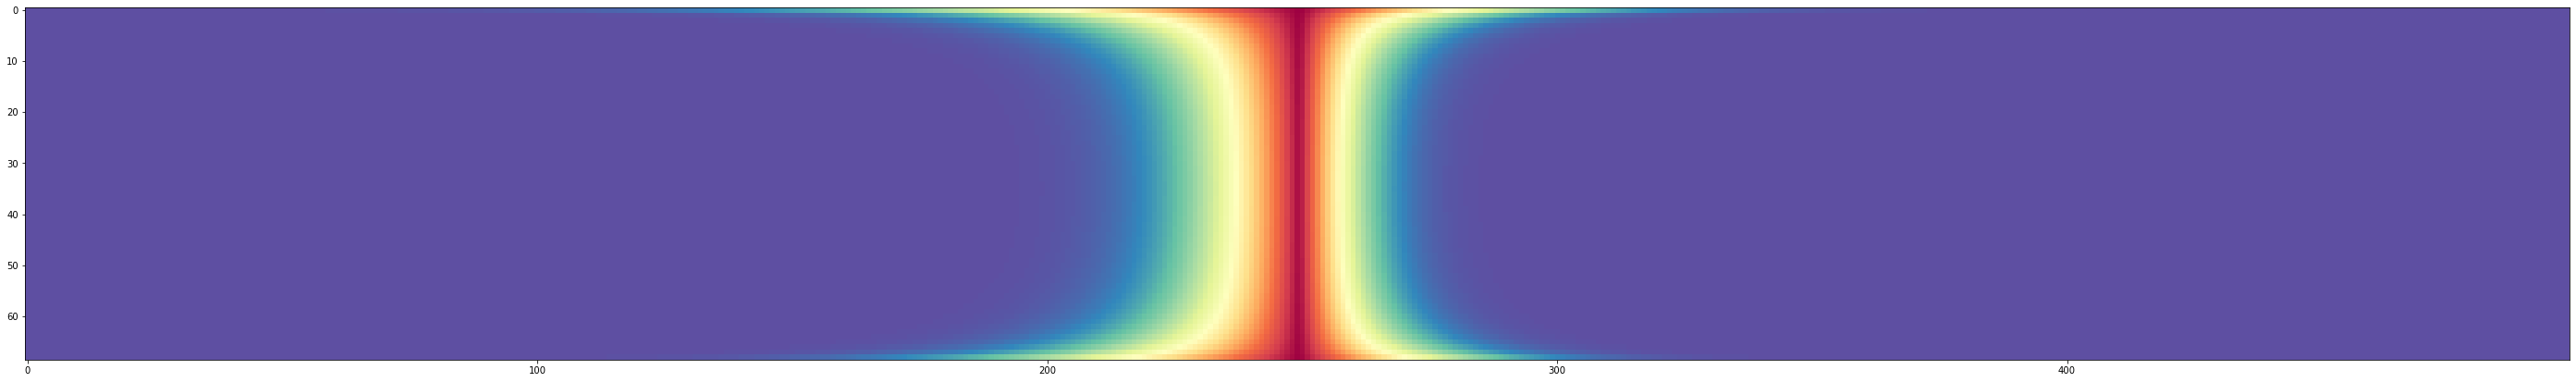

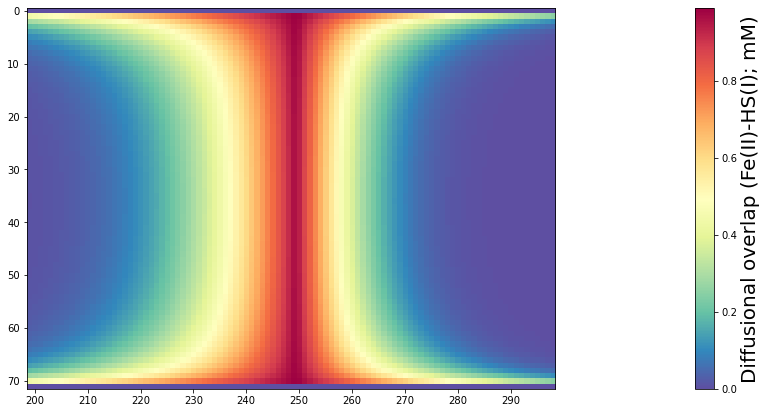

______________________________________________________________________________________________________
10000  um down-channel
0.9896017759098377
0.07017347279742997
0.0


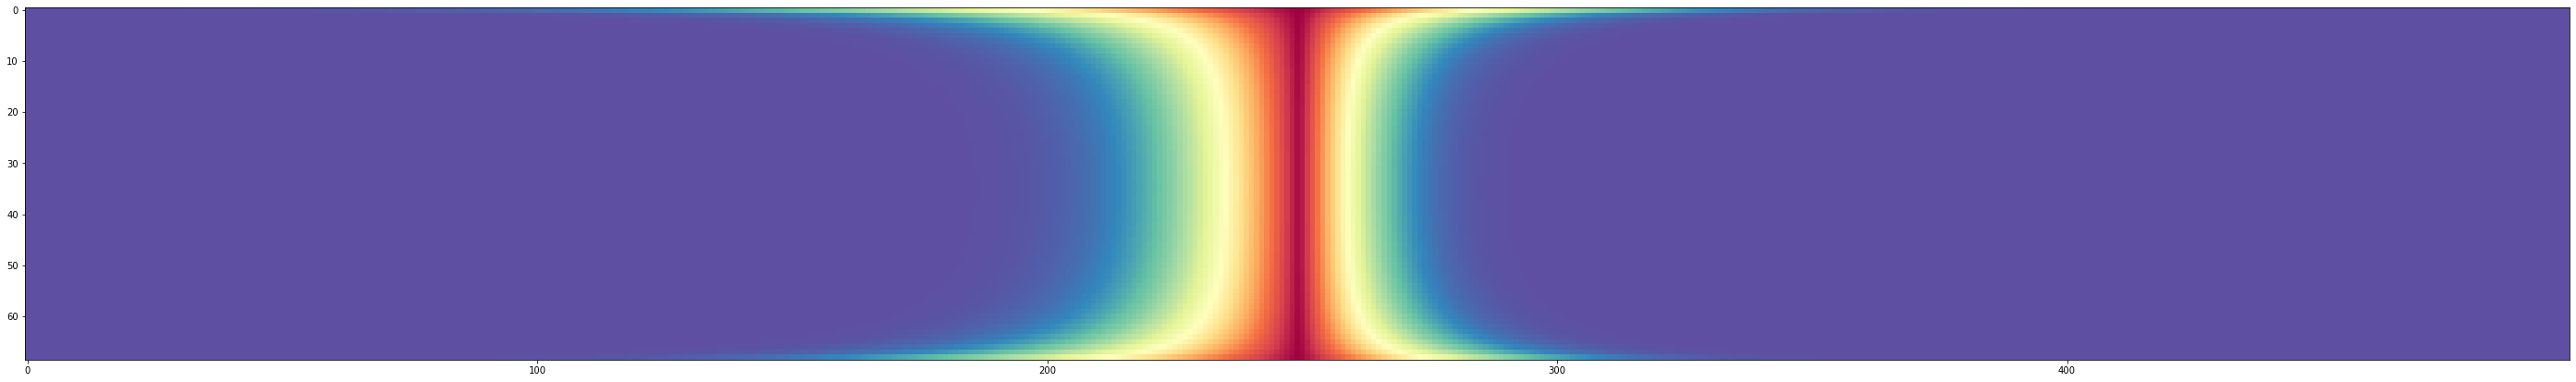

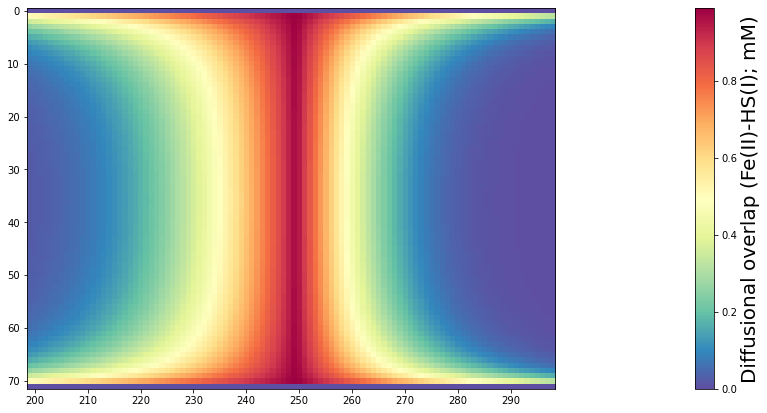

In [21]:
# 'HS(I)'
# 'HPO4(II)'
# 'CO3(II)'
anion = 'HS(I)'

chem_n, distance_n, height, width = return_models.shape
ionic_slices = np.zeros( (distance_n, height, width) )
fe_s_overlap = np.zeros( (distance_n, height, width) )
fe_array = np.zeros( (height, width) )
hs_array = np.zeros( (height, width) )

for j, distance in enumerate(return_distances):
    for i, chem_name in enumerate(return_names):
        if chem_name == 'Fe(II)':
            fe_array[::,251::] = return_models[i][j][::, 251::] * 10e11
        elif chem_name == anion:
            hs_array[::,0:251] = return_models[i][j][::, 0:251] * 10e11
    fe_s_overlap[j] = np.add(fe_array, hs_array)      


for dist_index,model in enumerate(fe_s_overlap):
    
    print('______________________________________________________________________________________________________')
    print(return_distances[dist_index], ' um down-channel')
    
    print(np.amax(model))
    print(np.average(model))
    print(np.min(model))

    f, ax = plt.subplots(figsize=(50, 7))
    plt.imshow(model[1:70,1:500], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
    plt.show()

    h_slice =slice(0,height)
    w_start = 200
    w_end = 300

    w_slice = slice(w_start,w_end)
    w_index = [num for num in range(1, (w_end-w_start+1), 10)]
    w_numbers = [num for num in range(w_start, (w_end), 10)]

    f, ax = plt.subplots(figsize=(50, 7))
    graph = plt.imshow(model[h_slice,w_slice], interpolation= 'nearest', \
                       cmap = sns.color_palette("Spectral_r", as_cmap=True)                       
                      )
    cbar = plt.colorbar(graph)

    plt.xticks(w_index, w_numbers)
    label_string = str('Diffusional overlap (Fe(II)-'+ anion+ '; mM)')
    cbar.set_label(label_string, fontsize = 20)
    plt.show()

## Generate ionic strength, diffusional overlap, and activity coefficient maps

### Ionic strength and diffusional overlap

Fe(II)-HS only here. This is the system with maximal constraints.

______________________________________________________________________________________________________
15  um down-channel
9.656025491459639
5.242195950419168
0.0


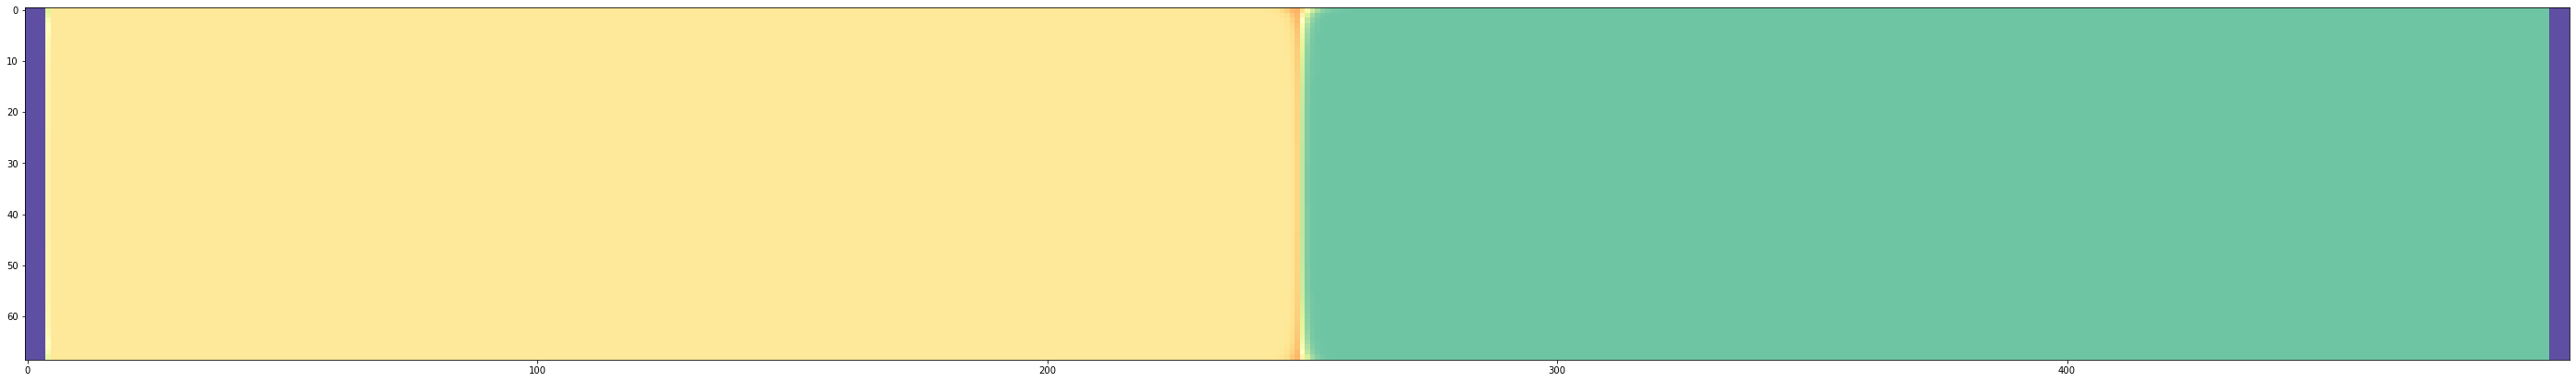

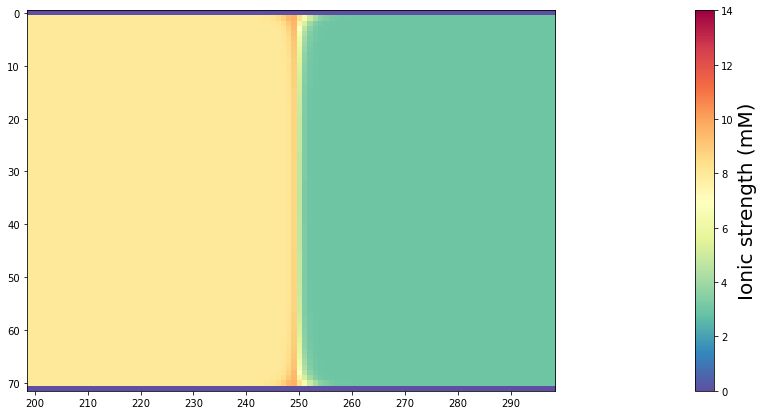

______________________________________________________________________________________________________
150  um down-channel
10.551529234422356
5.2756699486281935
0.0


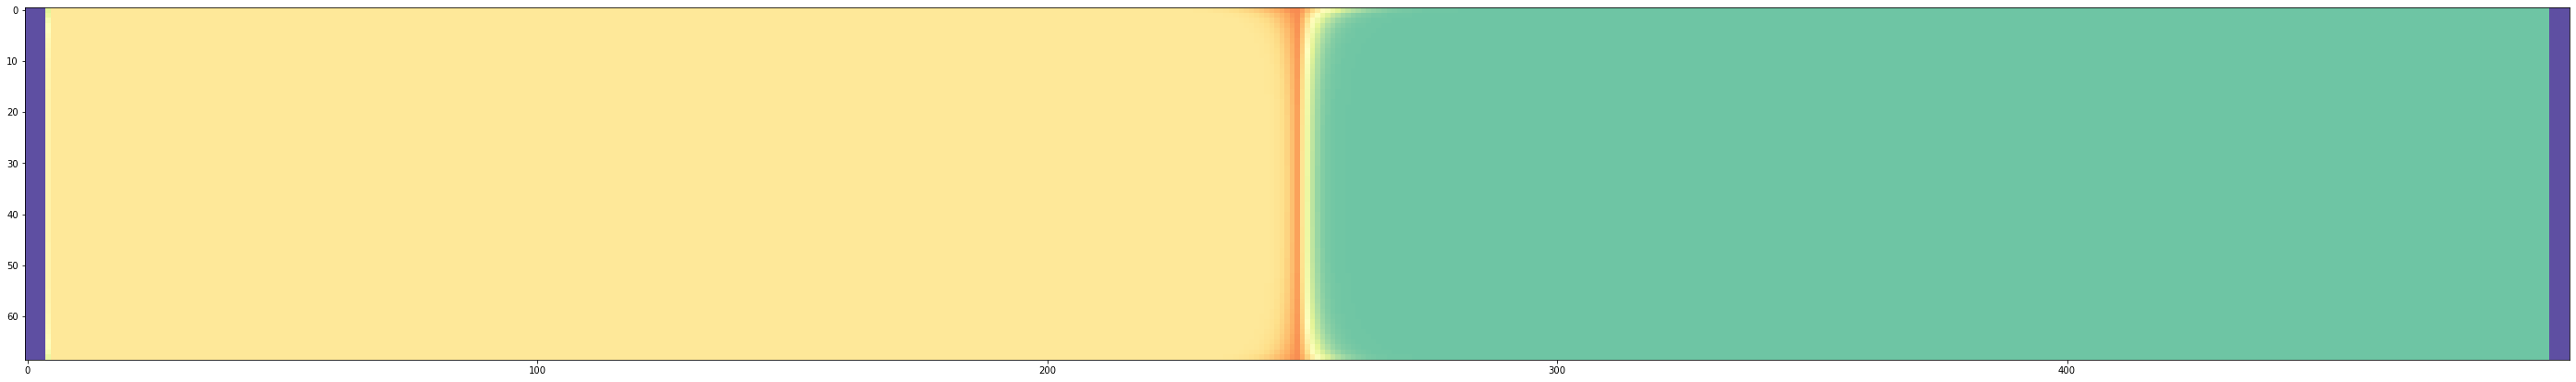

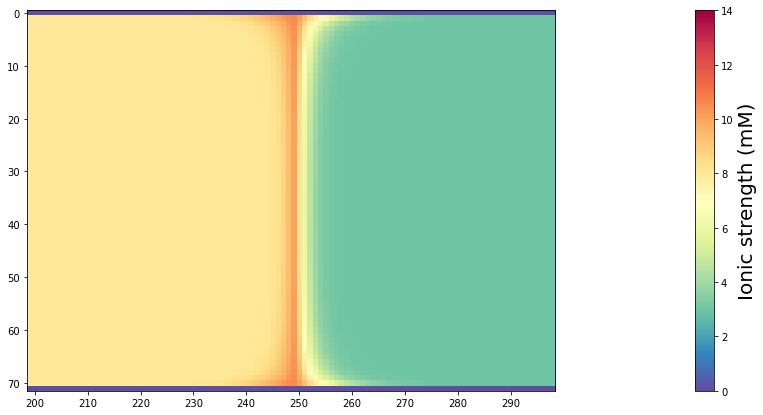

______________________________________________________________________________________________________
1500  um down-channel
10.857368977452197
5.387280553937955
0.0


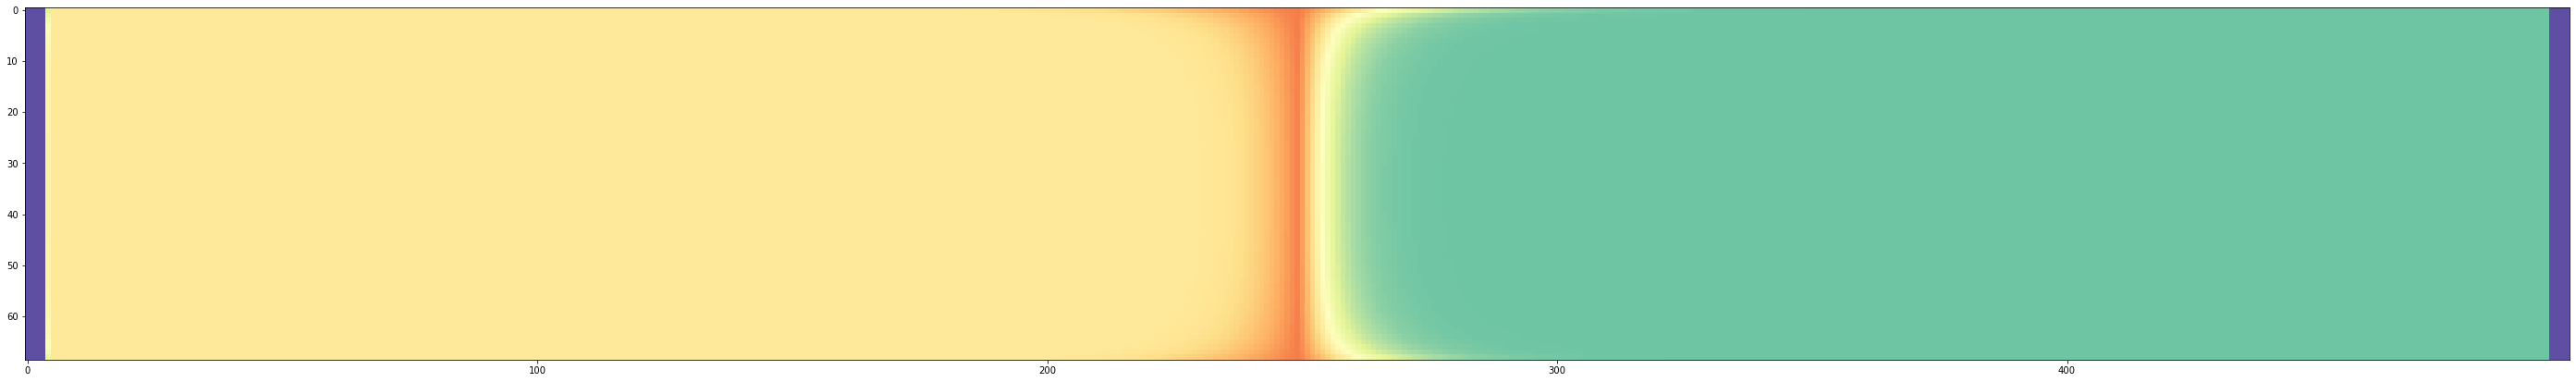

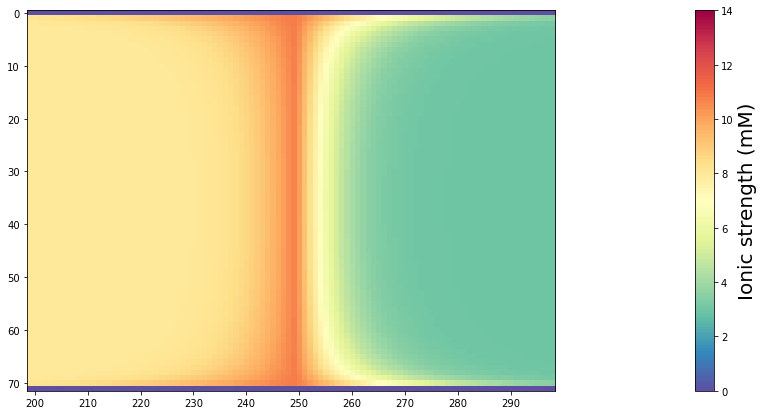

______________________________________________________________________________________________________
7500  um down-channel
10.936180877295604
5.589940703745632
0.0


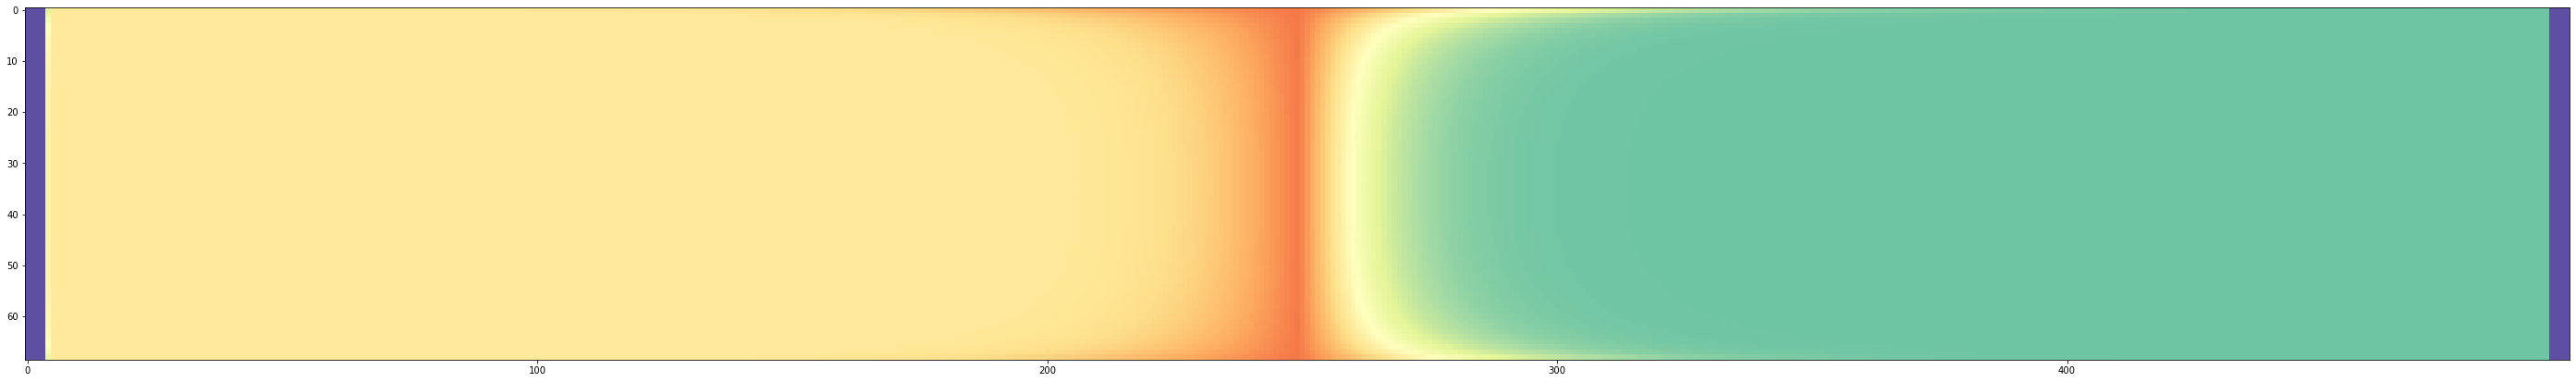

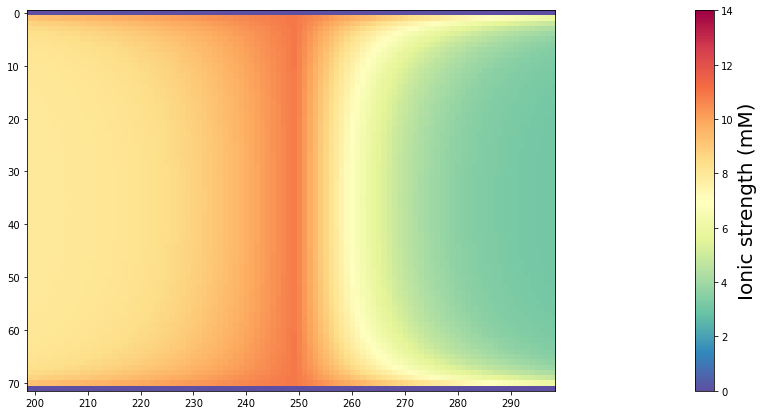

______________________________________________________________________________________________________
10000  um down-channel
10.944729252828605
5.646653984665489
0.0


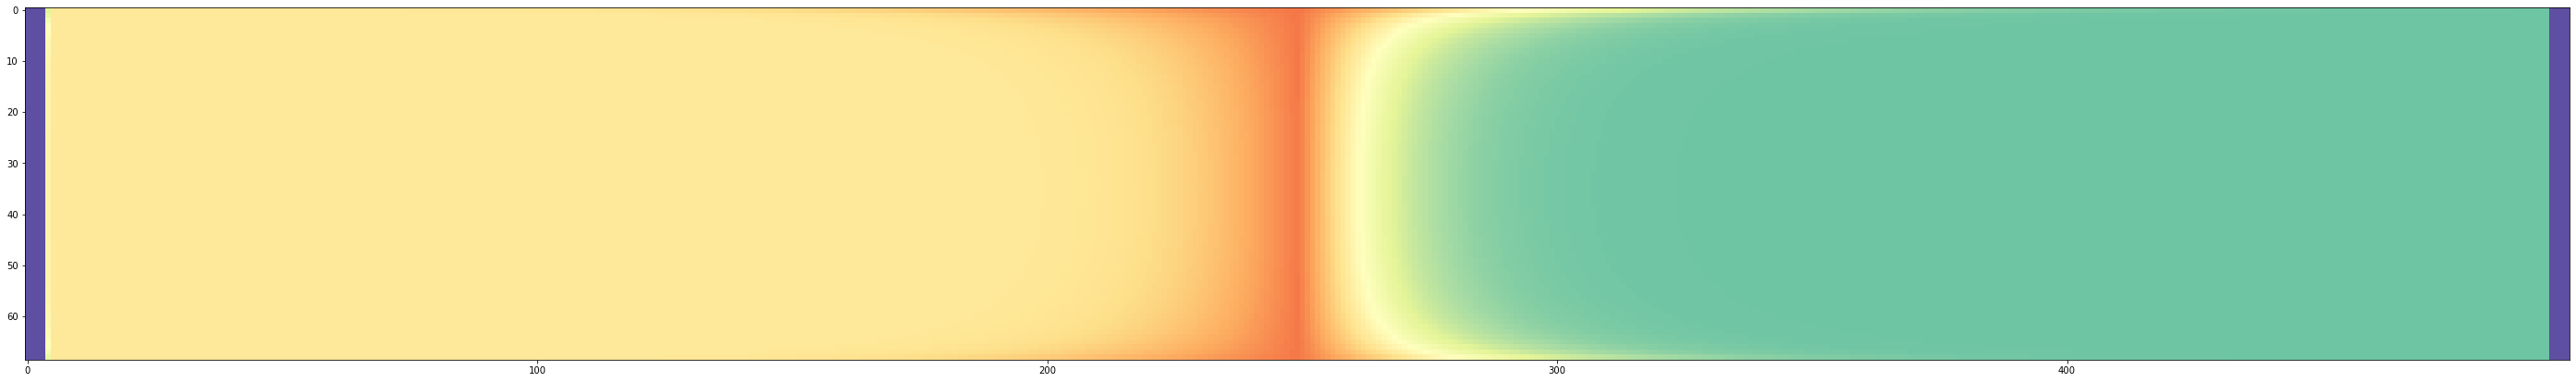

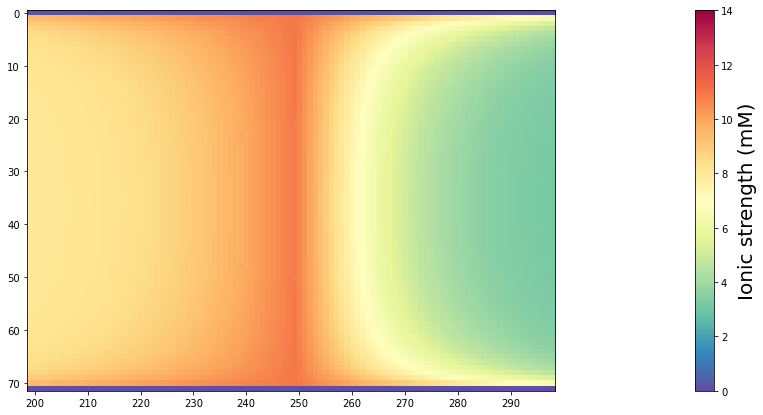

______________________________________________________________________________________________________
15  um down-channel
0.749056779945402
0.0014805827149411655
0.0


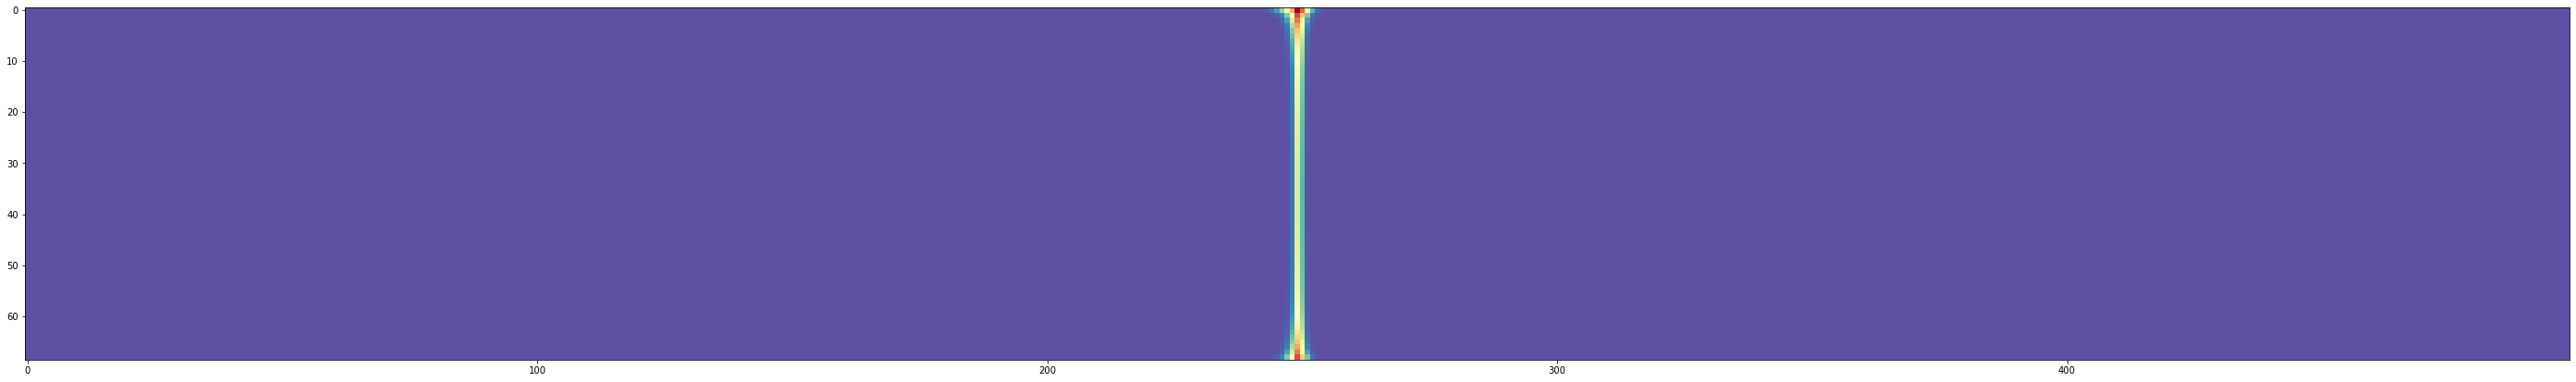

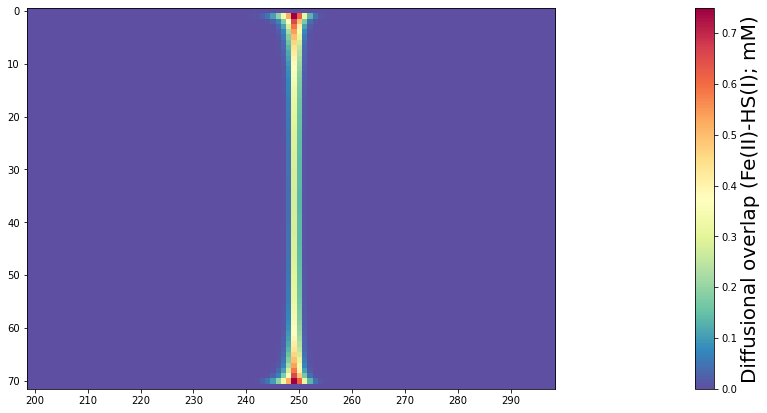

______________________________________________________________________________________________________
150  um down-channel
0.915698493400544
0.0070844752491595565
0.0


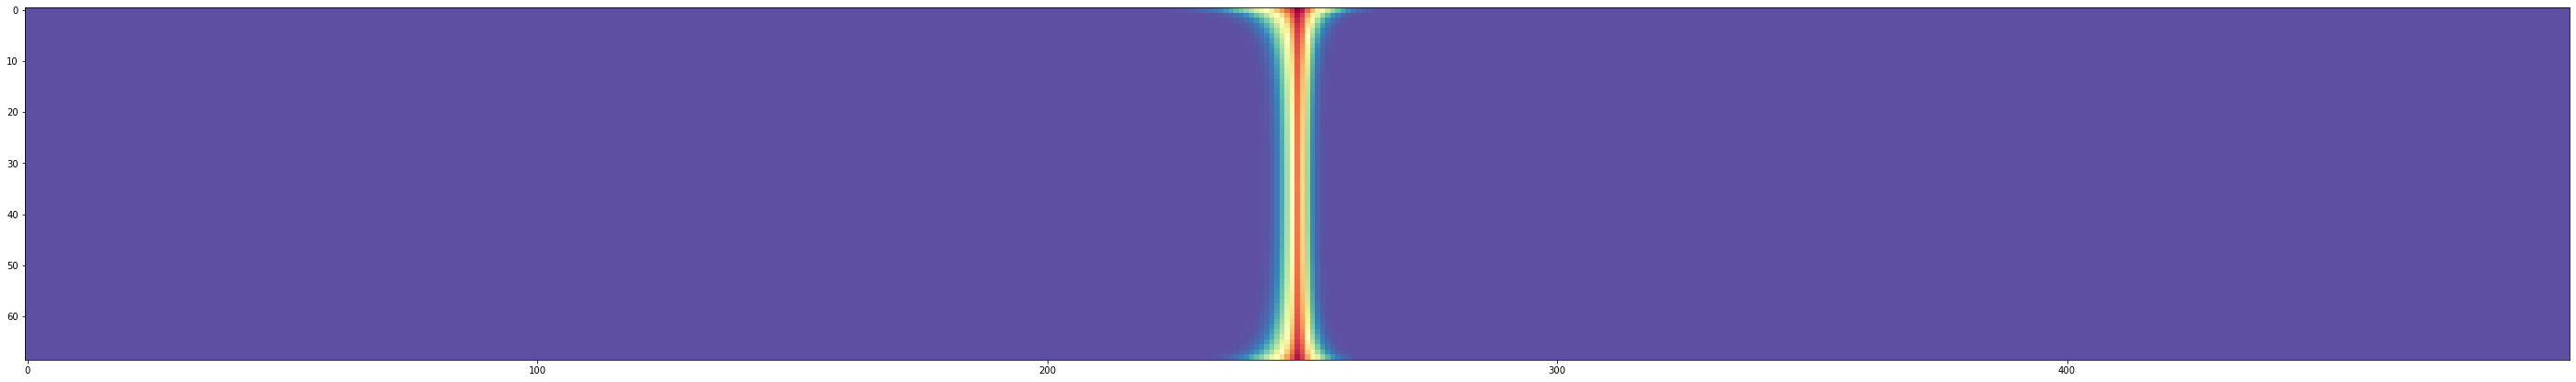

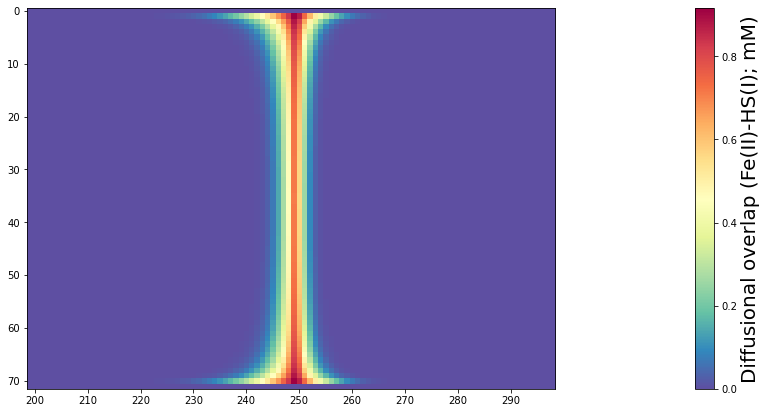

______________________________________________________________________________________________________
1500  um down-channel
0.9731684246002154
0.026043816249044425
0.0


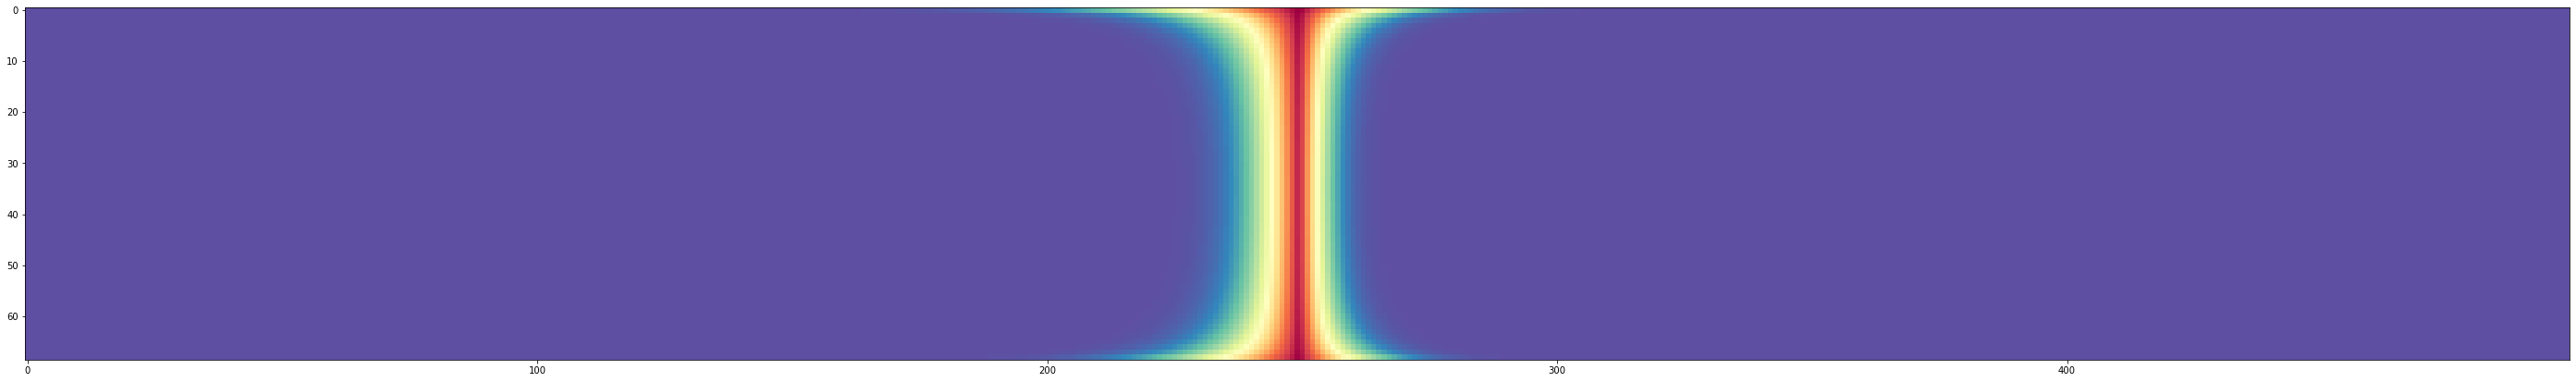

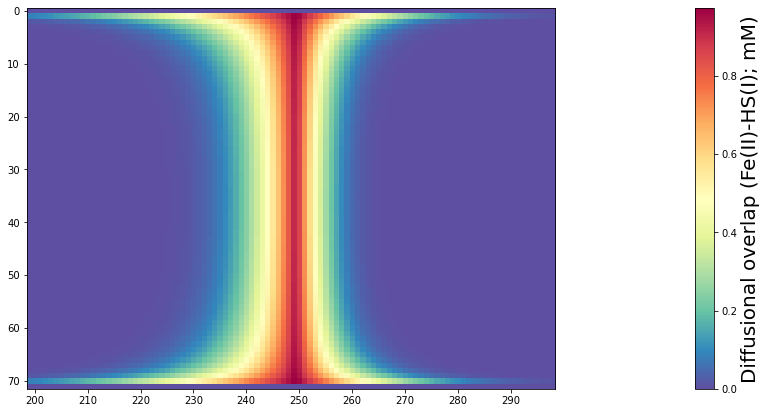

______________________________________________________________________________________________________
7500  um down-channel
0.9879936000800829
0.06052130535989639
0.0


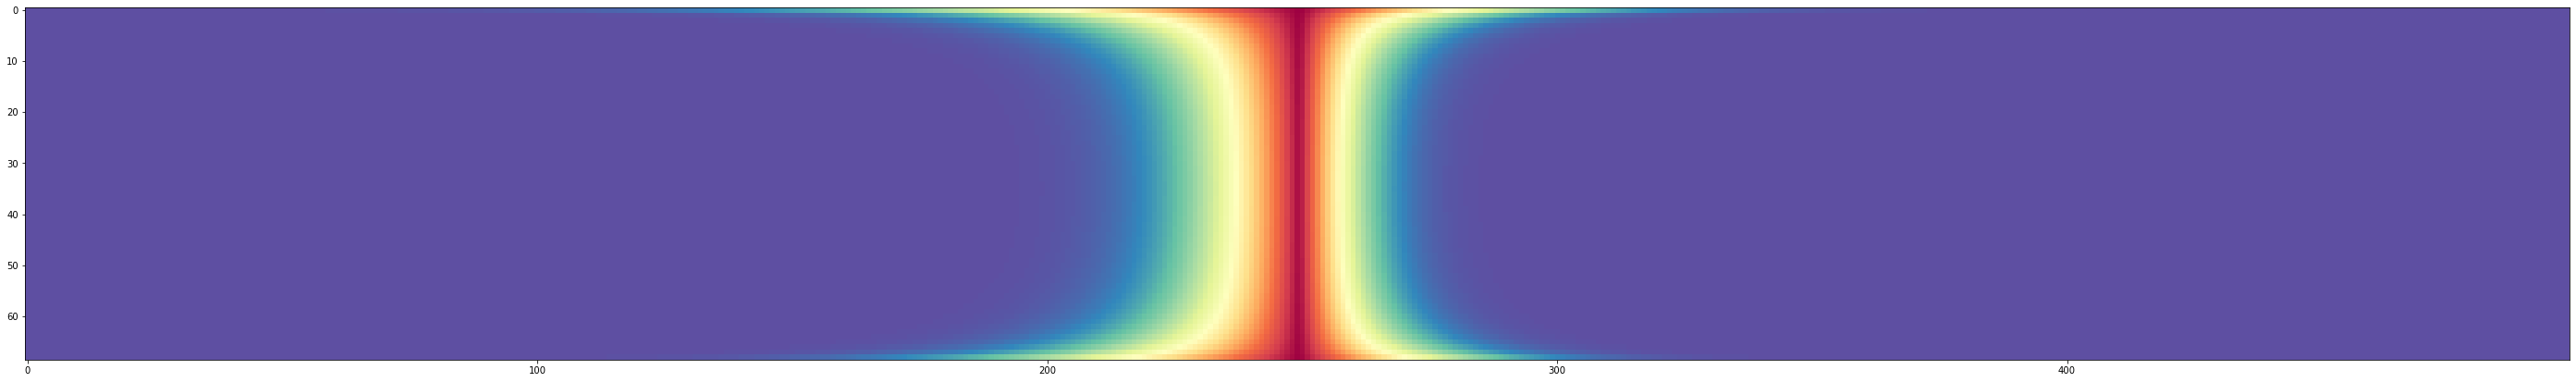

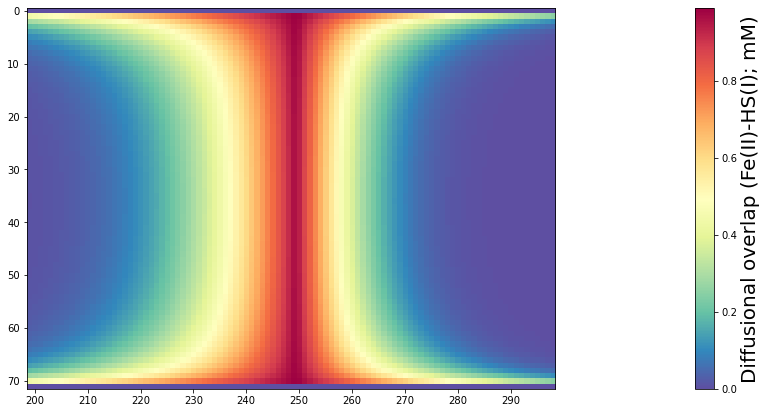

______________________________________________________________________________________________________
10000  um down-channel
0.9896017759098377
0.07017347279742997
0.0


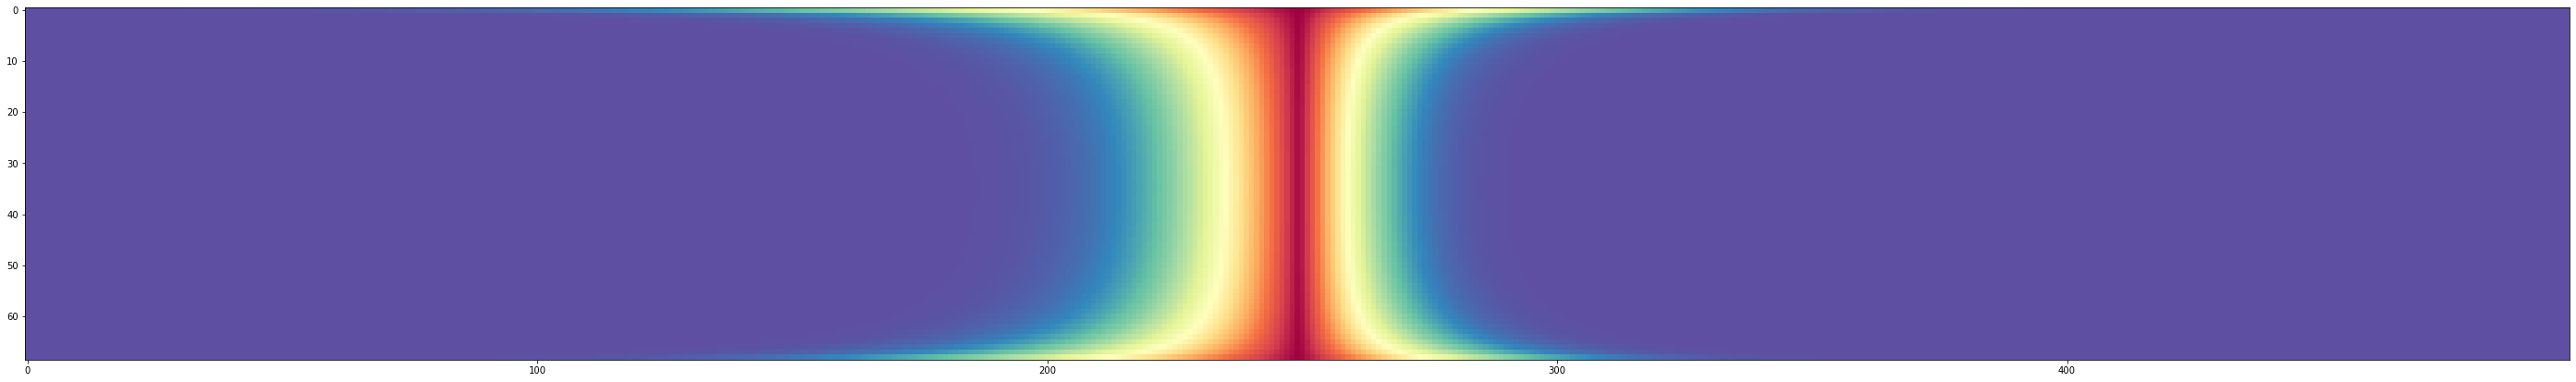

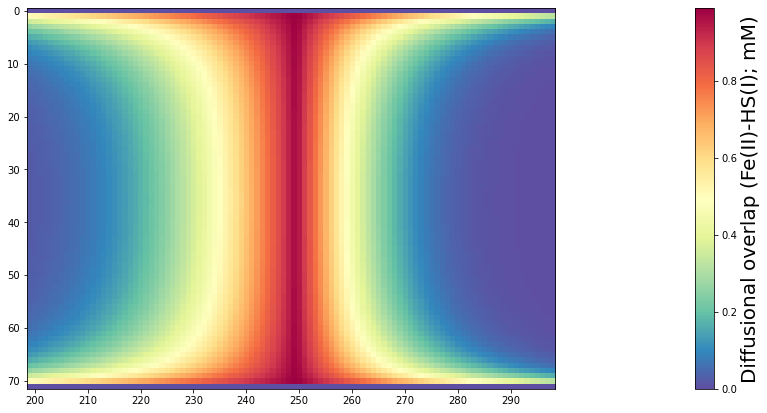

In [22]:
chem_n, distance_n, height, width = return_models.shape
ionic_slices = np.zeros( (distance_n, height, width) )

this_ionic_strength = np.zeros( (height, width) )
for j, distance in enumerate(return_distances):
    for i, chem_name in enumerate(return_names):
        np.multiply(this_ionic_strength, 0)
        if chem_name == 'H(I)':
            # pH is not typically considered in ionic strength
            pass
        else:
            this_ionic_strength = return_models[i][j] * charge_valency[chem_name]**2 * 10e11
         
        # Add either the zero array if pH or the calculated concentration * valency**2
        ionic_slices[j] = np.add(ionic_slices[j], this_ionic_strength)

# Ionic strength is 1/2 * the sum calculated above
np.divide(ionic_slices, 2)
            

fe_s_overlap = np.zeros( (distance_n, height, width) )
for j, distance in enumerate(return_distances):
    for i, chem_name in enumerate(return_names):
        if chem_name == 'Fe(II)':
            fe_array = return_models[i][j] * 10e11
        elif chem_name == anion:
            hs_array = return_models[i][j] * 10e11
    fe_s_overlap[j] = np.minimum(fe_array, hs_array)

for dist_index,model in enumerate(ionic_slices):
    
    print('______________________________________________________________________________________________________')
    print(return_distances[dist_index], ' um down-channel')
    
    print(np.amax(model))
    print(np.average(model))
    print(np.min(model))

    f, ax = plt.subplots(figsize=(50, 7))
    plt.imshow(model[1:70,1:500], interpolation= 'nearest', \
               cmap = sns.color_palette("Spectral_r", as_cmap=True), \
               vmin =0, vmax = 14)
    plt.show()

    h_slice =slice(0,height)
    w_start = 200
    w_end = 300

    w_slice = slice(w_start,w_end)
    w_index = [num for num in range(1, (w_end-w_start+1), 10)]
    w_numbers = [num for num in range(w_start, (w_end), 10)]

    f, ax = plt.subplots(figsize=(50, 7))
    graph = plt.imshow(model[h_slice,w_slice], interpolation= 'nearest', \
                       cmap = sns.color_palette("Spectral_r", as_cmap=True), \
                       vmin = 0, \
                       vmax = 14
                      )
    cbar = plt.colorbar(graph)

    plt.xticks(w_index, w_numbers)
    cbar.set_label('Ionic strength (mM)', fontsize = 20)
    plt.show()
    
for dist_index,model in enumerate(fe_s_overlap):
    
    print('______________________________________________________________________________________________________')
    print(return_distances[dist_index], ' um down-channel')
    
    print(np.amax(model))
    print(np.average(model))
    print(np.min(model))

    f, ax = plt.subplots(figsize=(50, 7))
    plt.imshow(model[1:70,1:500], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
    plt.show()

    h_slice =slice(0,height)
    w_start = 200
    w_end = 300

    w_slice = slice(w_start,w_end)
    w_index = [num for num in range(1, (w_end-w_start+1), 10)]
    w_numbers = [num for num in range(w_start, (w_end), 10)]

    f, ax = plt.subplots(figsize=(50, 7))
    graph = plt.imshow(model[h_slice,w_slice], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
    cbar = plt.colorbar(graph)

    plt.xticks(w_index, w_numbers)
    label_string = str('Diffusional overlap (Fe(II)-'+ anion+ '; mM)')
    cbar.set_label(label_string, fontsize = 20)
    plt.show()

### Top-down-view summed concentration of Fe-S overlap

______________________________________________________________________________________________________

15  um down-channel
25.45  = max summed conc.
0.107  = average summed conc.
2  micron width of visible precip.


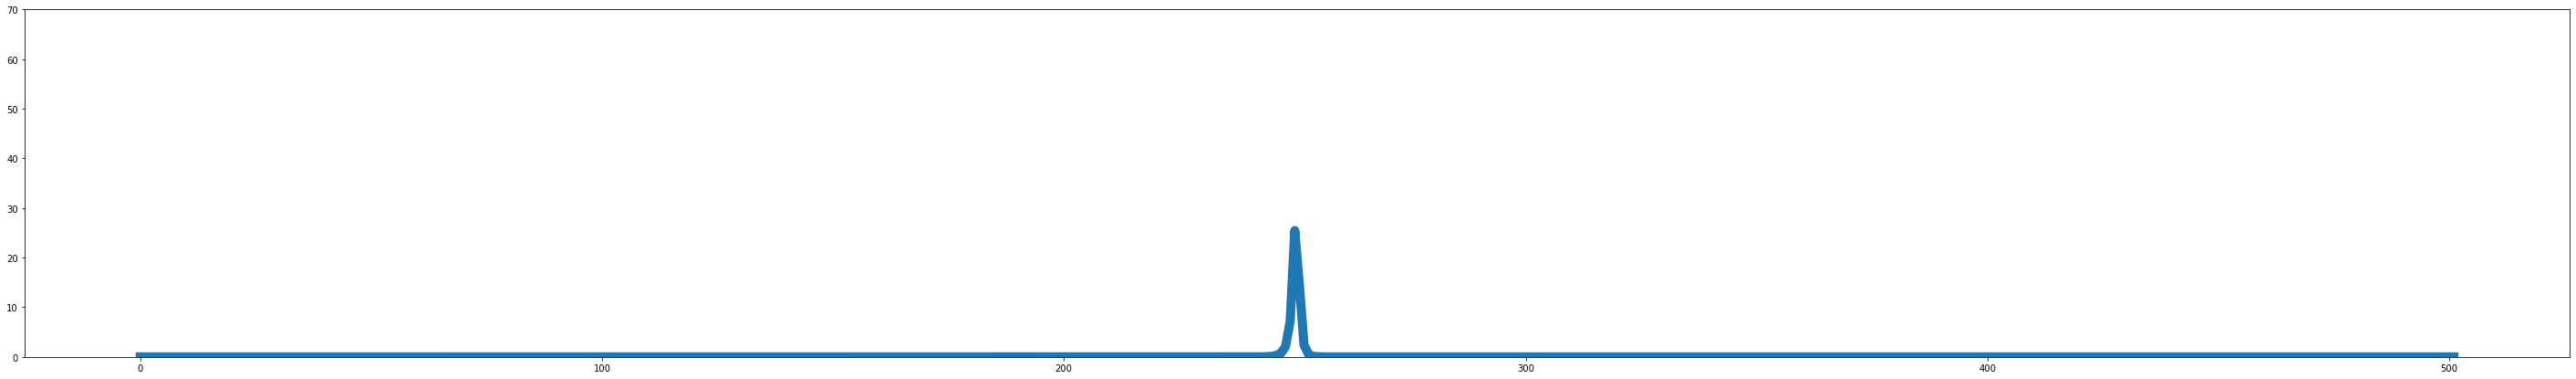

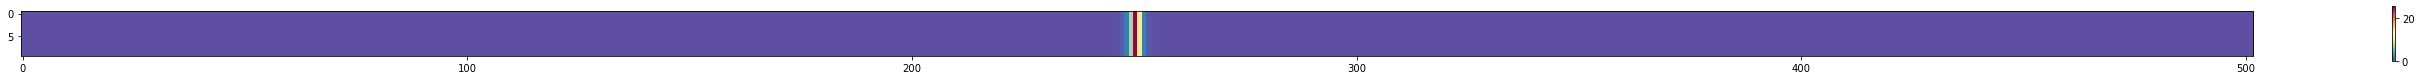

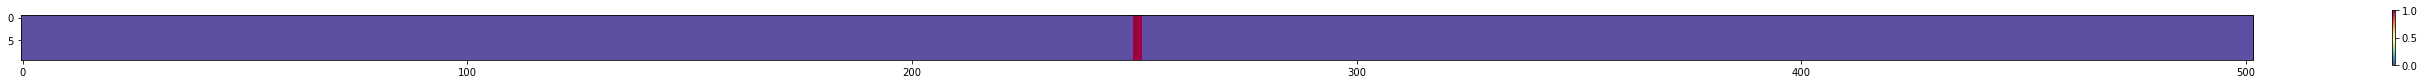

______________________________________________________________________________________________________

150  um down-channel
52.881  = max summed conc.
0.51  = average summed conc.
8  micron width of visible precip.


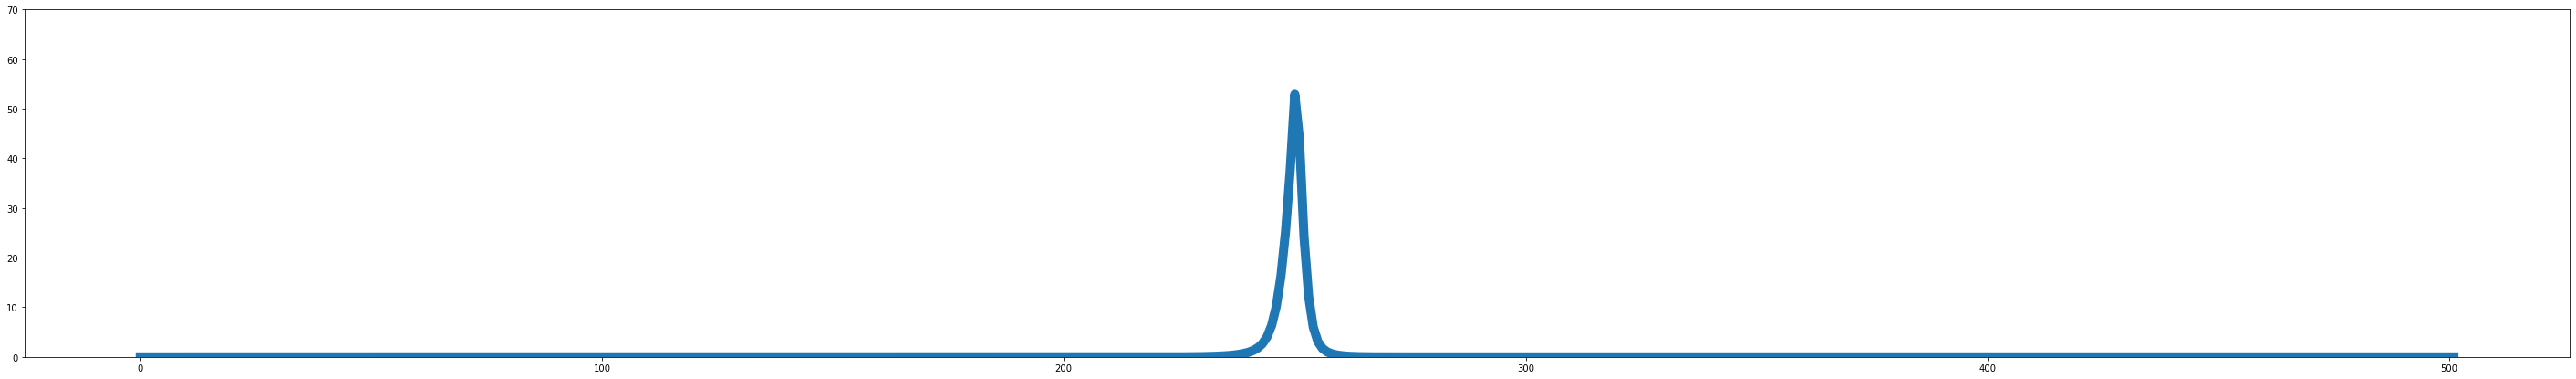

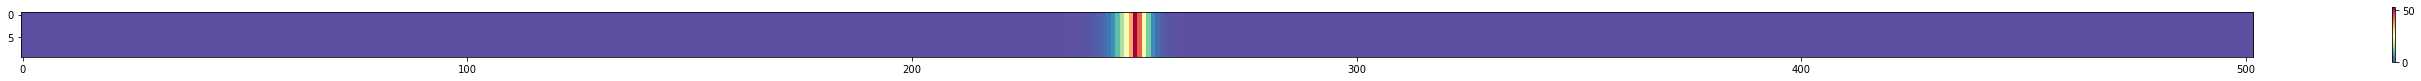

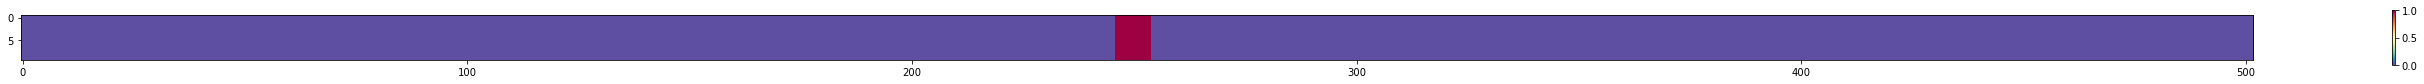

______________________________________________________________________________________________________

1500  um down-channel
64.489  = max summed conc.
1.875  = average summed conc.
25  micron width of visible precip.


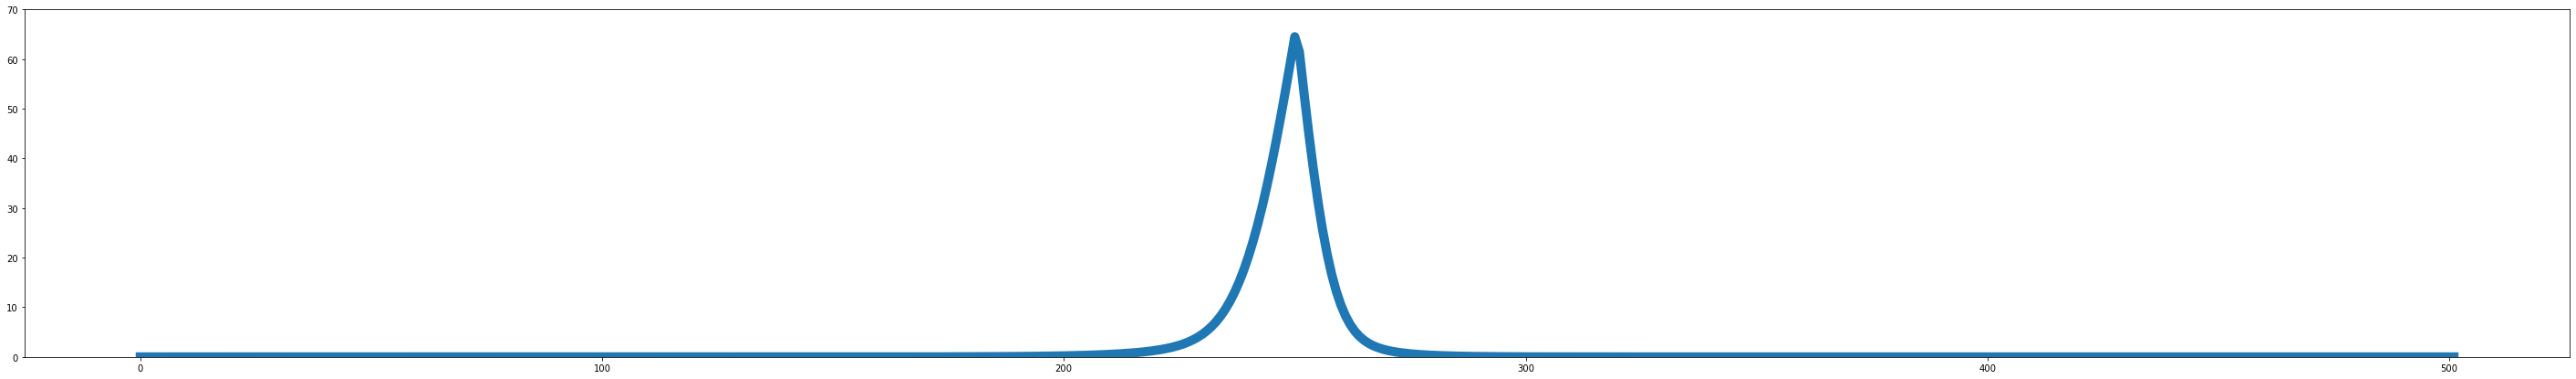

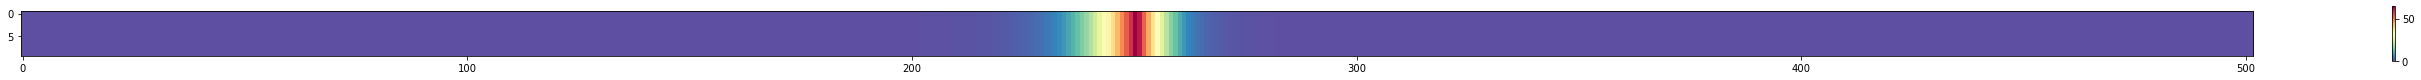

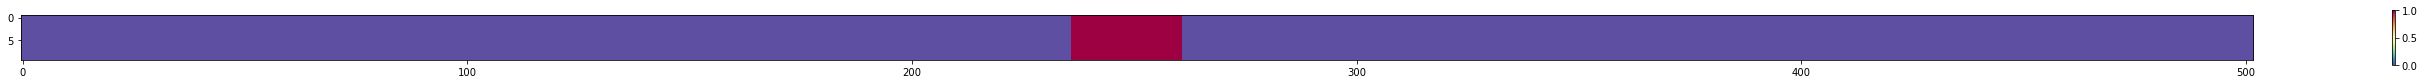

______________________________________________________________________________________________________

7500  um down-channel
67.532  = max summed conc.
4.358  = average summed conc.
57  micron width of visible precip.


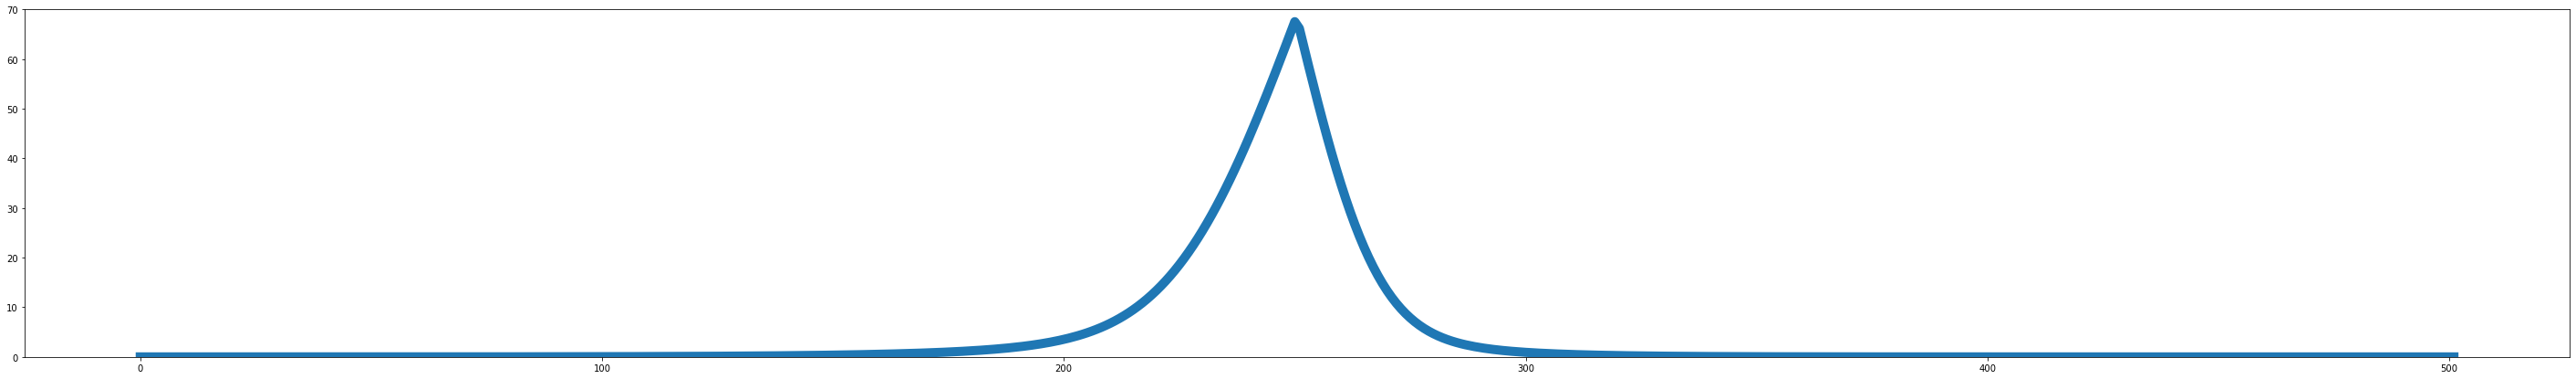

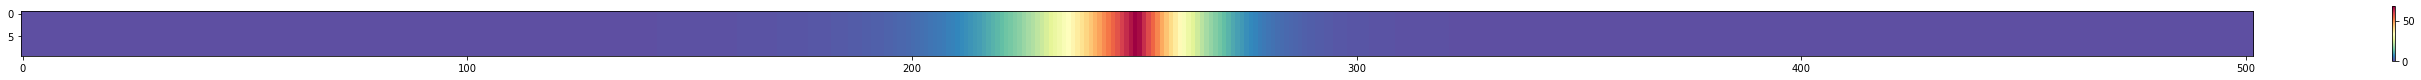

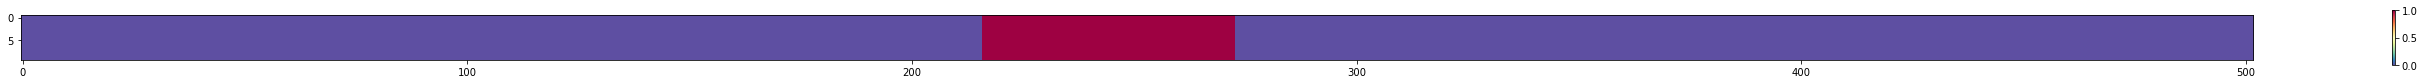

______________________________________________________________________________________________________

10000  um down-channel
67.862  = max summed conc.
5.052  = average summed conc.
66  micron width of visible precip.


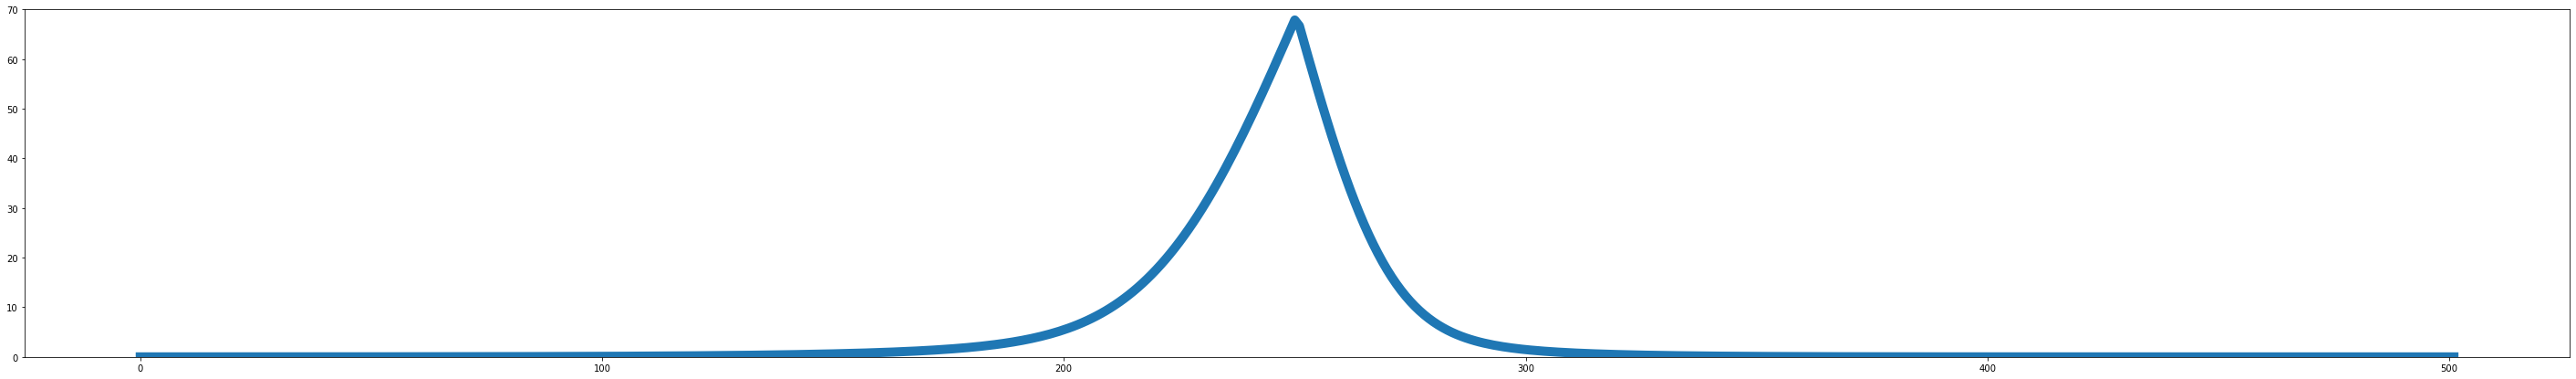

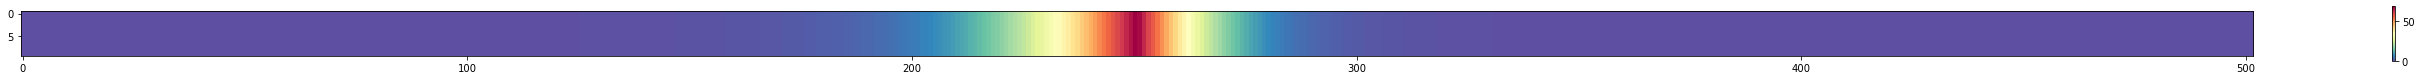

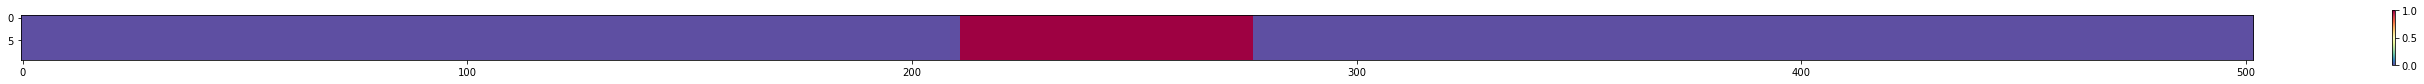

In [23]:
threshold_conc = 10

fe_s_topdown = []
for frame in fe_s_overlap:
    this_sum = np.sum(frame, axis=0)
    fe_s_topdown.append(this_sum)

for dist_index,model in enumerate(fe_s_topdown):
    
    print('______________________________________________________________________________________________________')
    print()
    print(return_distances[dist_index], ' um down-channel')
    
    print(round(np.amax(model), 3), ' = max summed conc.')
    print(round(np.average(model), 3), ' = average summed conc.')
    
    total_observable = np.sum(model>10)
    print(total_observable, " micron width of visible precip.")
    

    f, ax = plt.subplots(figsize=(50, 7))
    plt.plot(model, linewidth = 10)
    plt.ylim([0,70])
    plt.show()
    
    # Create a new 'image_array' and plot the 
    image_array = np.ones((10,502))
    for i in range(10):
        image_array[i,::] = model
    f, ax = plt.subplots(figsize=(50, 1))
    graph = plt.imshow(image_array, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
    cbar = plt.colorbar(graph)
    plt.show()
    
    image_array = np.ones((10,502))
    for j in range(502):
        if model[j] >= threshold_conc:
            image_array[::,j] = 1
        else:
            image_array[::,j] = 0
    f, ax = plt.subplots(figsize=(50, 1))
    graph = plt.imshow(image_array, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
    cbar = plt.colorbar(graph)
    plt.show()


# Detailed flow deformation by precipitation

Load prior results and initialize some variables

In [2]:
# MAKE SURE THIS IS RIGHT; in uL/min
flow_rate = 100

# Load a results model
root = Tk()
#root.withdraw()
filename = filedialog.askopenfilename(title = 'Load a RESULTS model')
root.destroy()
return_models = np.load(filename)

# Load a flow model
root = Tk()
#root.withdraw()
filename = filedialog.askopenfilename(title = 'Load a FLOW model')
root.destroy()
flow_model = np.load(filename)

# Make a rectangular channel; (height, width, length) in um^3
   # creates 'channel_slice', 'channel_length' and 'wall_mask' global variables
new_channel(70, 500, 15000)


   # Made negative due to reality (it's a decrease down the channel)
   # in mbar/mm
pressure_drop = -1 * estimate_pressure_drop(flow_rate, wall_mask)

# in um; typically will not change
slice_depth = 2.5

# in usec; typically will not change
time_step = 1

# in g/cm^3; this doesn't change for now, but may in the future
density = 1

# in mPa * sec; assume water for single, homogenous value
   # Options below for dynamic consideration of viscosity take this value as the default
viscosity = 1

parameter_tuple = (pressure_drop, \
                  slice_depth, \
                  time_step, \
                  density, \
                  viscosity)

# Make a new channel to 'apply' model to
new_channel(70, 500, 15000)

# These are the standard percentage-of-channel-length distances that are calculated
return_percentages = [0.001, 0.01, 0.1, 0.5, 0.66667]

#'channel_length' should be a global variable
return_distances = [int(round(percentage * channel_length)) for percentage in return_percentages]

# For Fe(II)Cl2-Na2S, the standard return chemical species and their order is below
return_names = ['Fe(II)', 'Cl(I)', 'H(I)', 'Na(I)', 'HS(I)']
# ['Fe(II)', 'Cl(I)', 'H(I)', 'Na(I)', 'HPO4(II)']
# ['Fe(II)', 'Cl(I)', 'H(I)', 'Na(I)', 'HS(I)']
# ['Fe(II)', 'Cl(I)', 'H(I)', 'Na(I)', 'CO3(II)']

In [4]:
# Things that really need to be specified each time
anion = 'HS(I)'    # 'HPO4(II)', 'HS(I)', 'CO3(II)'

iteration_max = 100
return_list = [1,10,100, 500]   # iterations to return


# density in g/cm^3
# Assume Fe(II) is the cation, then the anion precipitating is as below
# Densities are for as-sold chemical products 
density = {'HS(I)': 4.75, \
           'CO3(II)': 3.8, \
           'HPO4(II)': 3.06}
  # g/mol of Fe-Anion precipitates
molar_mass = {'HS(I)': 87.91, \
           'CO3(II)': 115.854, \
           'HPO4(II)': 150.82}
  # convert to number of grams in 1 um^3 of water (ignoring solutes)
grams_water_block = 1e-12
anion_density = density[anion]
height = return_models[0].shape[0]
width = return_models[0].shape[1]

# Generate diffusive overlaps from the 'return_models'
chem_n, distance_n, height, width = return_models.shape
ionic_slices = np.zeros( (distance_n, height, width) )
fe_s_overlap = np.zeros( (distance_n, height, width) )
fe_array = np.zeros( (height, width) )
hs_array = np.zeros( (height, width) )

# This is used ('hs_array', I think) for other things, but there's a better way applied below.
#   This is just kept in for the legacy code that I can't find and because I'm sure deleting it is a bad idea.
for j, distance in enumerate(return_distances):
    for i, chem_name in enumerate(return_names):
        if chem_name == 'Fe(II)':
            fe_array[::,251::] = return_models[i][j][::, 251::] * 10e11
        elif chem_name == anion:
            hs_array[::,0:251] = return_models[i][j][::, 0:251] * 10e11
    fe_s_overlap[j] = np.add(fe_array, hs_array)
    
chem_n, distance_n, height, width = return_models.shape
ionic_slices = np.zeros( (distance_n, height, width) )

# Calculate ionic strength
#   I think this is a wishful addition. This would have to be calulated each time and would be a real computational drag.
this_ionic_strength = np.zeros( (height, width) )
for j, distance in enumerate(return_distances):
    for i, chem_name in enumerate(return_names):
        np.multiply(this_ionic_strength, 0)
        if chem_name == 'H(I)':
            # pH is not typically considered in ionic strength
            pass
        else:
            this_ionic_strength = return_models[i][j] * charge_valency[chem_name]**2 * 10e11
         
        # Add either the zero array if pH or the calculated concentration * valency**2
        ionic_slices[j] = np.add(ionic_slices[j], this_ionic_strength)

# Ionic strength is 1/2 * the sum calculated above
np.divide(ionic_slices, 2)
            
#Initialize channel slice to hold precipitate concentrations
precipitate_slice = np.zeros( (height, width) )

# Diffusive contribution to Fe(II) and Anion concentrations
# Hard-coded to 'return_models[3]' assuming that this represents the 
diffusion_slice = np.copy(fe_s_overlap[3])

# Use initial 'diffusion_slice' as the input
#   Also used as the assumption for concentration input
initial_fe_slice = np.copy(return_models[0,3,::,::])
initial_anion_slice = np.copy(return_models[4,3,::,::])
diffusion_slice = np.zeros((height,width))
for h in range(height):
    for w in range(width):
        this_fe = initial_fe_slice[h,w]
        this_anion =initial_anion_slice[h,w]
        diffusion_slice[h,w] = min([this_fe, this_anion])

# 


In [6]:
#TESTING 

# variables just for testing
iteration_max = 51
return_list = [1,10, 50,100,200,300,500, 600, 700, 800, 900, 1000]   # iterations to return


# Initalize some variables
iteration_counter = 0
max_fe_conc = np.amax(initial_fe_slice)
max_anion_conc = np.amax(initial_anion_slice)
this_fe_slice = np.copy(initial_fe_slice)
this_anion_slice = np.copy(initial_anion_slice)
visc_flow = np.copy(flow_model)
precipitate_slice = np.zeros((height,width))

return_precipitate_slices = []

return_fe_slices = []
return_anion_slices = []

return_wall_slices = []
return_flow_slices = []

while iteration_counter<iteration_max:
    # Take the diffusional overlap of precipitating species
    diffusion_slice = np.zeros((height,width))
    for h in range(height):
        for w in range(width):
            this_fe = this_fe_slice[h,w]
            this_anion = this_anion_slice[h,w]
            diffusion_slice[h,w] = min(this_fe, this_anion)
    
    # Precipitate some fraction of diffusional overlap and add to 'return_precipitate_slices'
    precipitate_slice = np.add(precipitate_slice, diffusion_slice)    
    if iteration_counter in return_list:
        return_precipitate_slices.append(precipitate_slice)
        
    # Remove that difference from each reactant slice
    this_fe_slice = np.subtract(this_fe_slice, diffusion_slice)
    this_anion_slice = np.subtract(this_anion_slice, diffusion_slice)
    if iteration_counter in return_list:
        return_fe_slices.append(this_fe_slice)
        return_anion_slices.append(this_anion_slice)
        
    # Calculate effective viscosity and use it to deform flow
    this_wall = np.zeros((height,width))
    for h in range(height):
        for w in range(width):
            # 1e-12 g/um^3 water, but concentrations of fe/anion are in mM, so divide that by 1000 to get mol*(g/mol)/(g-water)
            this_volume_fraction = (precipitate_slice[h,w]*molar_mass[anion]/1e-9)/0.75
            if this_volume_fraction <0.8:
                this_eff_visc = (1-this_volume_fraction)**(-0.75*2.5)
                visc_flow[h,w] = flow_model[h,w]/this_eff_visc
                this_wall[h,w] = this_volume_fraction
            else:
                this_eff_visc = (1-this_volume_fraction)**(-0.75*2.5)
                visc_flow[h,w] = 0
                this_wall[h,w] = this_volume_fraction
    if iteration_counter in return_list:
        return_flow_slices.append(visc_flow)
        return_wall_slices.append(this_wall)
        
       # Equilibrate flow
    visc_flow = equilibrate_flow_slice(parameter_tuple, visc_flow, wall_mask, \
                                       max_iterations = 10, accuracy_threshold= .1, \
                                       run_to_max = False, show_print = False)
    
    
    # Add flow contribution to Fe and anion concentrations using diffusional assumptions of 'initial_ ...' slices
    diff_fe_change = np.zeros((height, width))
    diff_anion_change = np.zeros ((height, width))
    for h in range(1,height-1):
        for w in range(1,width-1):
            # flow in um/msec, so /1000 to get to usec. 
            # Each block is 1 um, so if >1um/usec, use max value, otherwise use fractional based on flow
            this_flow = visc_flow[h,w] / 1000
            this_fe_slice[h,w] = initial_fe_slice[h,w] * this_flow
            this_anion_slice[h,w] = initial_anion_slice[h,w] * this_flow
                
            # Calculate diffusive change
               # NOTE: this only solves for wall-like boundaries. MUST BE CHANGED TO SOLVE FOR PERMEABLE WALLS.
            # Calculate 'sediment diffusion' constant
            if this_wall[h,w] > 0.9:
                this_fe_diff_const = 0
                this_anion_diff_const = 0
            else:
                this_fe_diff_const = diffusion_const['Fe(II)'] * 1/(1+ (0.74 * (this_wall[h,w]/0.9)) )
                this_anion_diff_const = diffusion_const[anion] * 1/(1+ (0.74 * (this_wall[h,w]/0.9)) )
            
                alpha_fe = this_fe_diff_const/1000 * .01   # This second term is 'time_step/distance_step^2', 1usec/1um^2
                alpha_anion = this_anion_diff_const/1000 * .01
              # To keep array notation conistent, x=height and y=width
            # if alpha ==0, boundary is a wall
            if (alpha_fe > 0) and (alpha_anion > 0):
                if (wall_mask[h+1,w]==1) and (wall_mask[h-1,w]==1) and (wall_mask[h,w+1]==1) and (wall_mask[h,w-1]==1):
                    diff_fe_change[h,w] = alpha_fe * (this_fe_slice[h+1,w] + this_fe_slice[h-1,w])\
                    + alpha_fe * (this_fe_slice[h,w+1] + this_fe_slice[h,w-1])+(1-4*alpha_fe)*this_fe_slice[h,w]
                else:
                    diff_fe_change[h,w] = this_fe_slice[h,w]
                if (wall_mask[h+1,w]==1) and (wall_mask[h-1,w]==1) and (wall_mask[h,w+1]==1) and (wall_mask[h,w-1]==1):
                    diff_anion_change[h,w] = alpha_anion * (this_anion_slice[h+1,w] + this_anion_slice[h-1,w])\
                    + alpha_anion * (this_anion_slice[h,w+1] + this_anion_slice[h,w-1])+(1-4*alpha_anion)*this_anion_slice[h,w]
                else:
                    diff_fe_change[h,w] = this_anion_slice[h,w]            
    this_fe_slice = np.copy(diff_fe_change)
    this_anion_slice = np.copy(diff_anion_change)

    
    # Update parameters for next loop
    iteration_counter += 1
    if iteration_counter%1 ==0:
        print(iteration_counter)

1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [35]:
#With 'precipitate_slices' loaded from a prior simulation, calculate some stuff and try out different parameters

# variables just for testing
iteration_max = 1001
#return_list = [1,10, 50,100,200,300,500, 600, 700, 800, 900, 1000]   # iterations to return
return_list = [1,2,3,4,5,6,7,8,9,10,11,12]

# Initalize some variables
iteration_counter = 0
max_fe_conc = np.amax(initial_fe_slice)
max_anion_conc = np.amax(initial_anion_slice)
this_fe_slice = np.copy(initial_fe_slice)
this_anion_slice = np.copy(initial_anion_slice)
visc_flow = np.copy(flow_model)
precipitate_slice = np.zeros((height,width))

return_precipitate_slices = []

return_fe_slices = []
return_anion_slices = []

return_wall_slices = []
return_flow_slices = []
return_effvisc_slices = []

for precipitate_slice in precipitate_slices:
        
    # Calculate effective viscosity and use it to deform flow
    this_wall = np.zeros((height,width))
    this_visc = np.zeros((height,width))
    for h in range(height):
        for w in range(width):
            # 1e-12 g/um^3 water, but concentrations of fe/anion are in mM, so divide that by 1000 to get mol*(g/mol)/(g-water)
            this_volume_fraction = (precipitate_slice[h,w]*molar_mass[anion]/1e-9)/0.75
            if this_volume_fraction <0.8:
                this_eff_visc = (1-this_volume_fraction)**(-0.75*2.5)
                this_visc[h,w]= math.log(this_eff_visc)
                visc_flow[h,w] = flow_model[h,w]/this_eff_visc
                this_wall[h,w] = this_volume_fraction
            elif this_volume_fraction > 0.98:
                this_visc[h,w] = math.log(1500)
                visc_flow[h,w] = 0
                this_wall[h,w] = this_volume_fraction
            else:
                this_eff_visc = (1-this_volume_fraction)**(-0.75*2.5)
                this_visc[h,w]= math.log(this_eff_visc)
                visc_flow[h,w] = 0
                this_wall[h,w] = this_volume_fraction
    if iteration_counter in return_list:
        return_flow_slices.append(visc_flow)
        return_wall_slices.append(this_wall)
        return_effvisc_slices.append(this_visc)

    
    # Update parameters for next loop
    iteration_counter += 1
    if iteration_counter%1 ==0:
        print(iteration_counter)

1
2
3
4
5
6
7
8
9
10
11
12


## Save/Load Precipitation Model results

Load a precipitate result

In [9]:
root = Tk()
#root.withdraw()
filename = filedialog.askopenfilename()
root.destroy()

model = np.load(filename)

#return_wall_slices   # This is actually the effective viscosity
#return_precipitate_slices
#return_fe_slices
#return_anion_slices
#return_flow_slices

In [238]:
root = Tk()
#root.withdraw()
filename = filedialog.asksaveasfilename()
root.destroy()

np.save(filename, return_flow_slices)

## Visualize models


_____________________________________________________________
Time  50  useconds
70.95037970096875
49.5772355149511
0.0


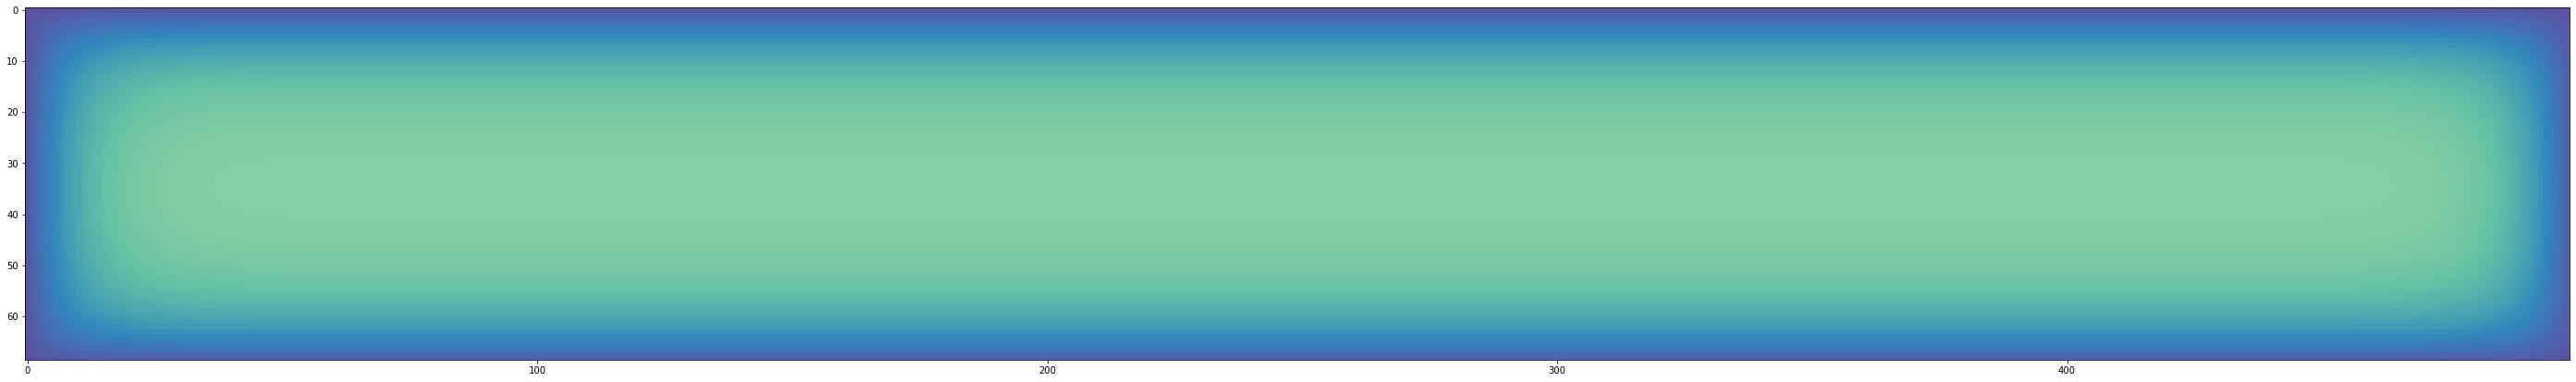

70.95037970096875
51.67728822482608
0.0


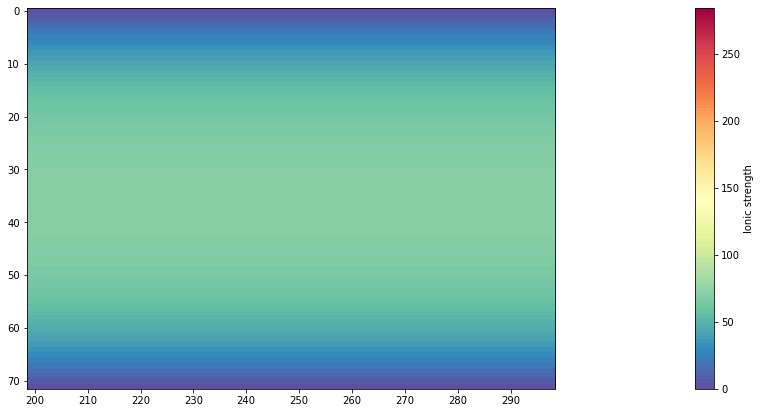

500  micron width of visible precip.


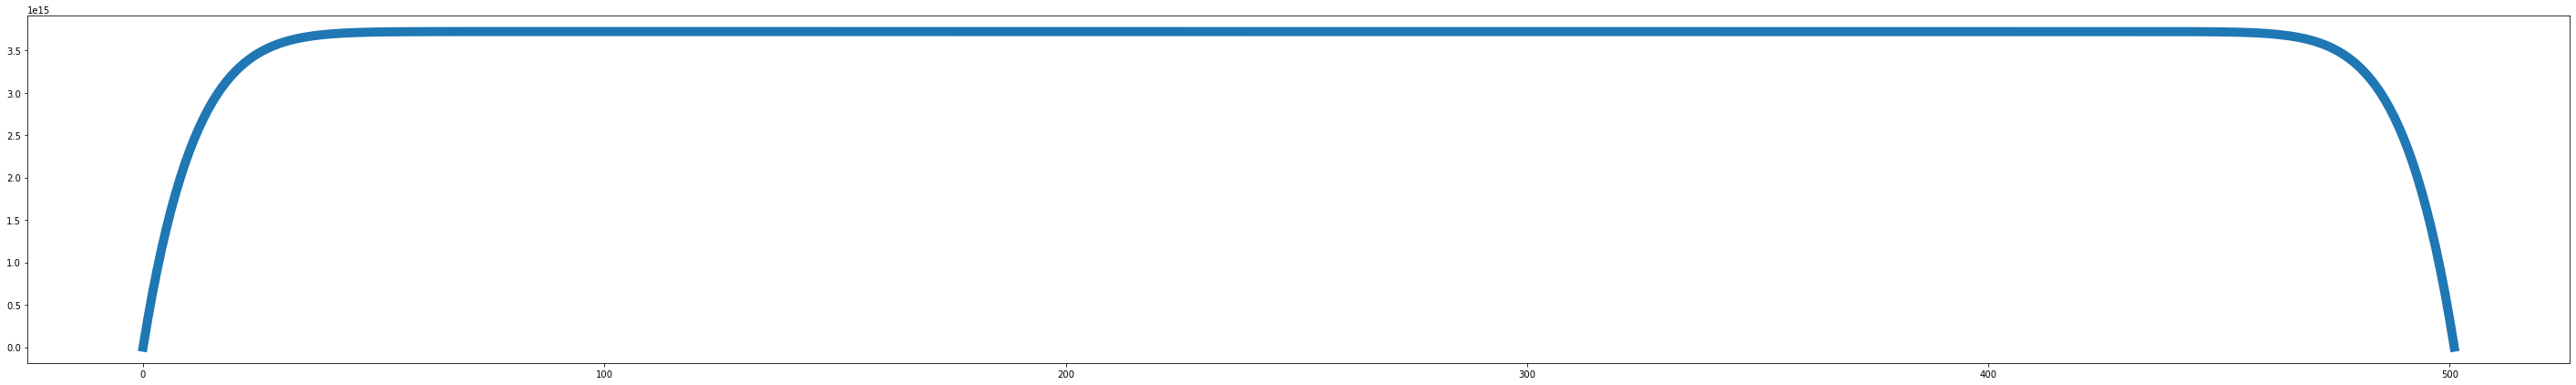

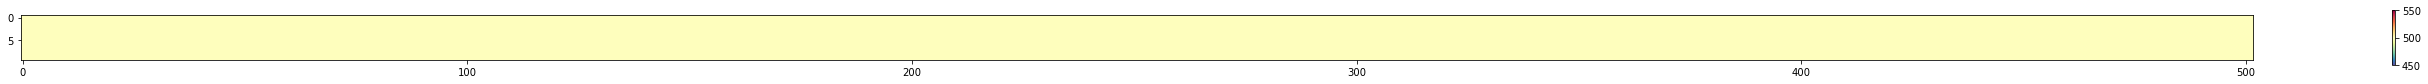

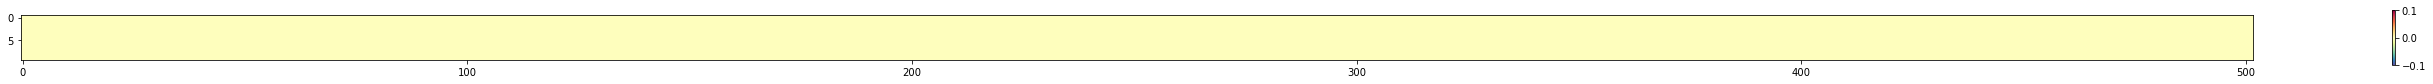


_____________________________________________________________
Time  100  useconds
141.9007726494135
99.15447810462953
0.0


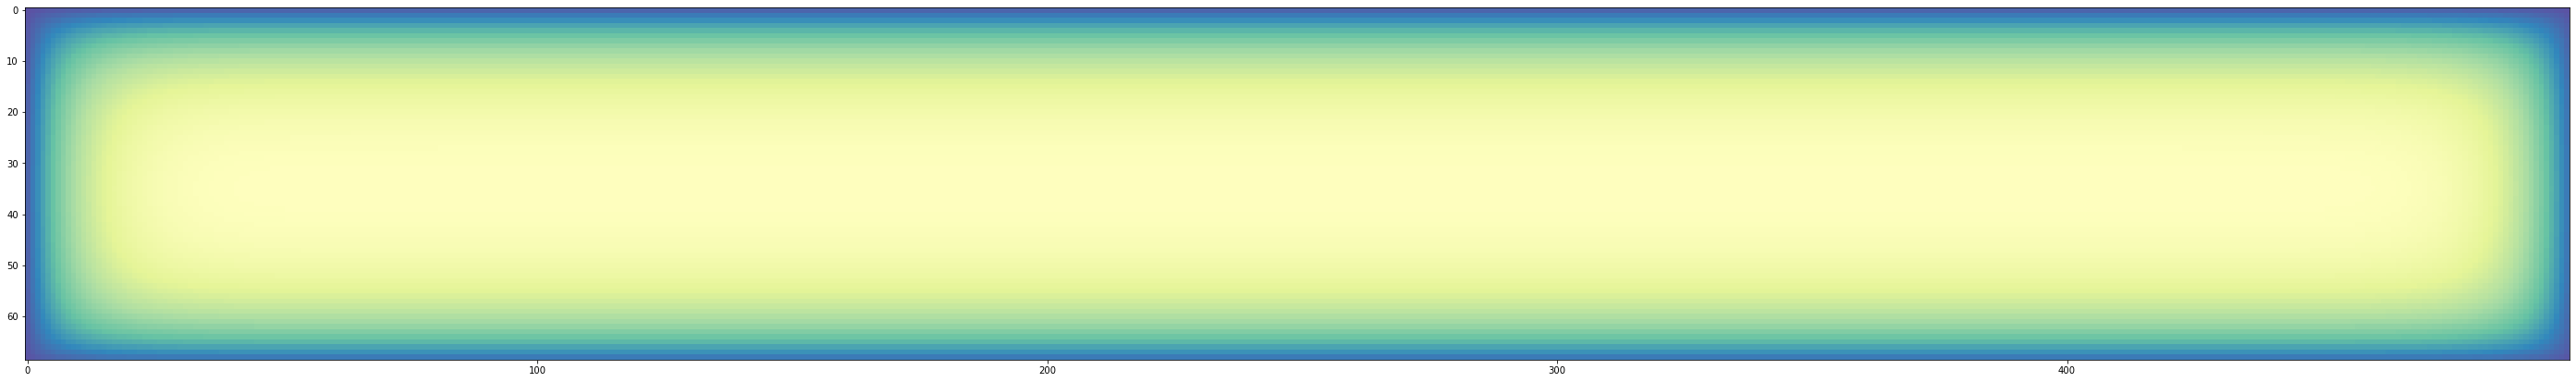

141.9007726494135
103.35458625033016
0.0


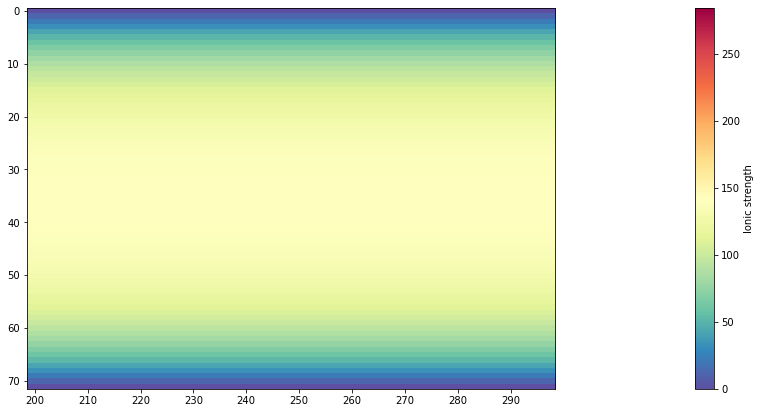

500  micron width of visible precip.


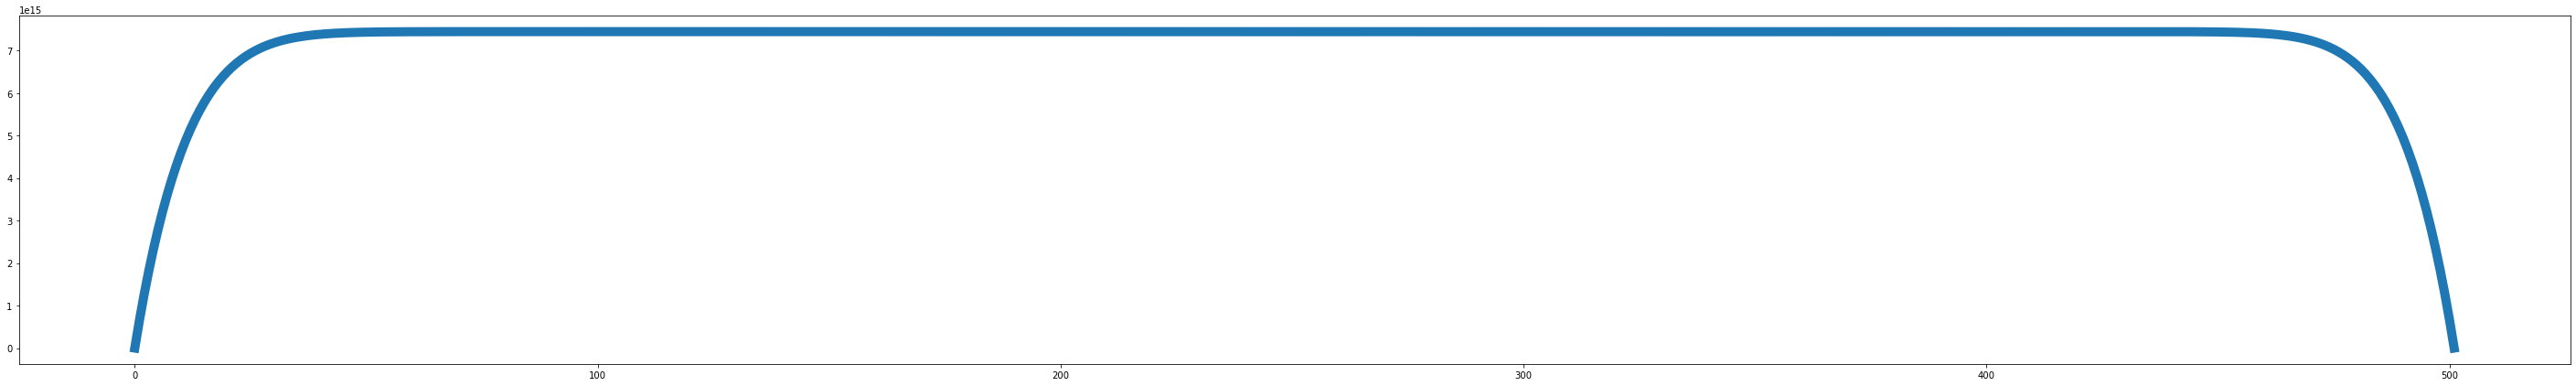

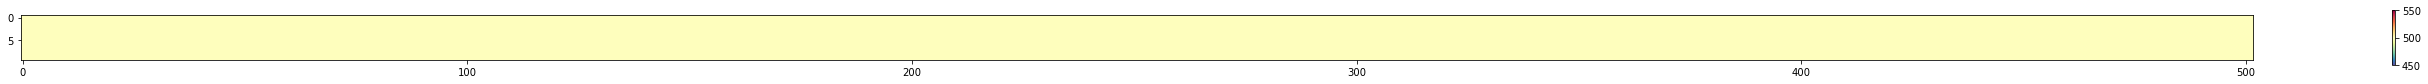

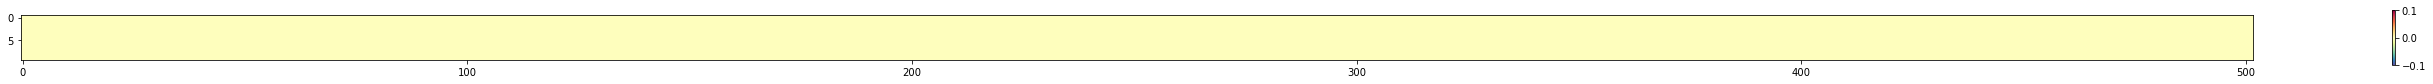


_____________________________________________________________
Time  200  useconds
283.8015596268658
198.30896385572893
0.0


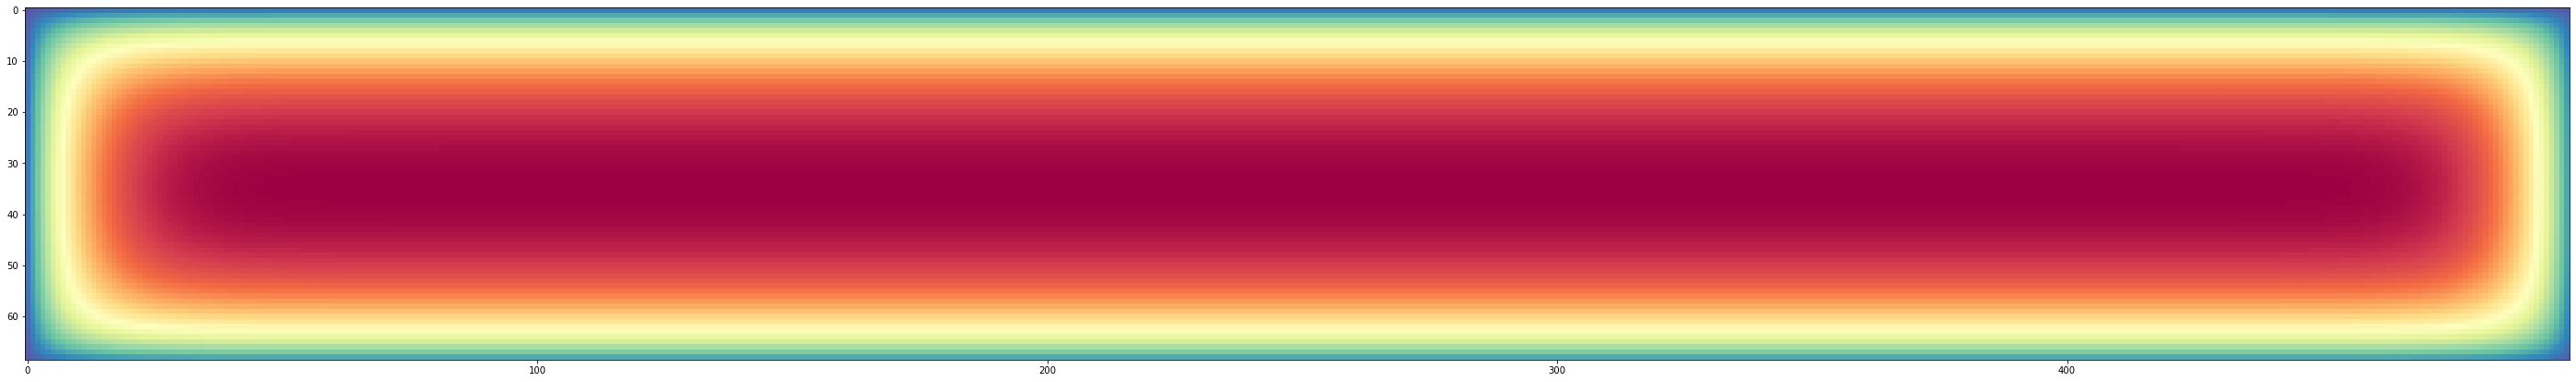

283.8015596268658
206.70918315196954
0.0


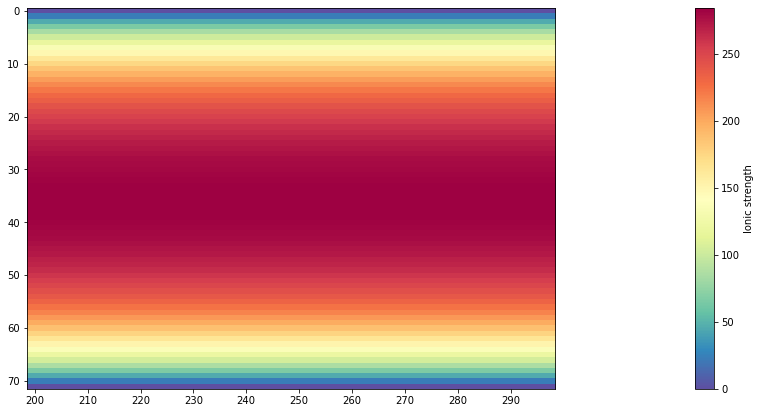

500  micron width of visible precip.


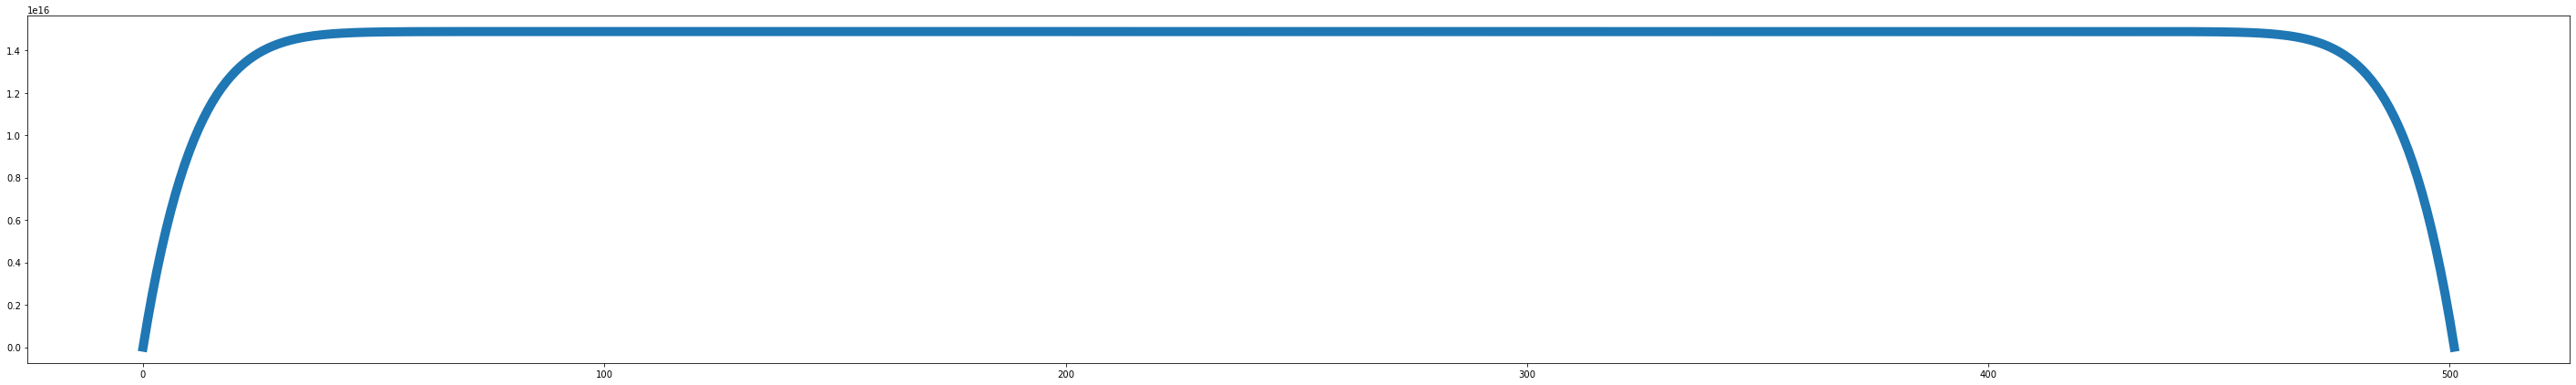

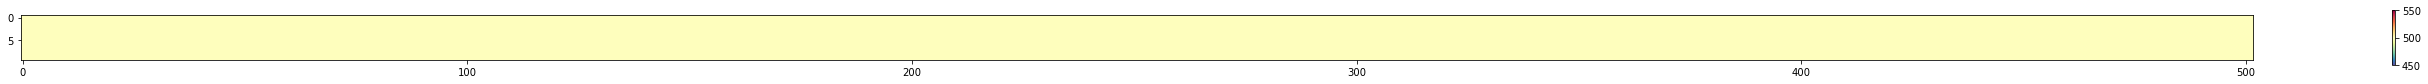

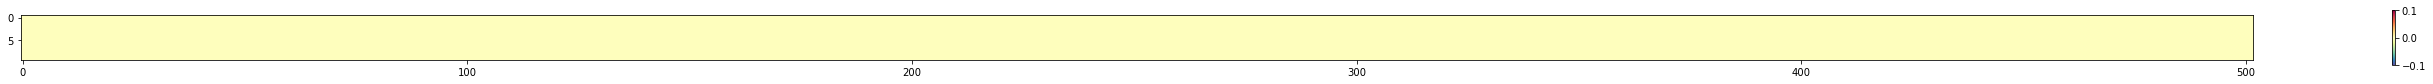

In [11]:
models =  flows
return_list = [50,100, 200]
#return_wall_slices   # This is actually the effective viscosity
#return_precipitate_slices
#return_fe_slices
#return_anion_slices
#return_flow_slices
#return_effvisc_slices


#anion_mask #anion_fill_slice #flow_dilution_volume #flow_addition #working_slice

model_max = np.amax(models[-1])
#model_max = 7.5    # Use to force a colorbar max in case spurious cells are throwing off the image

height = models[0].shape[0]
width = models[0].shape[1]

for index, model in enumerate(models):
    #model = model/ 1e-12
    print()
    print('_____________________________________________________________')
    print('Time ', return_list[index], ' useconds')
    
    print(np.amax(model))
    print(np.average(model))
    minimum = np.min(model)
    print(np.min(model))

    f, ax = plt.subplots(figsize=(50, 7))
    plt.imshow(model[1:70,1:500], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True), \
                       vmin = 0, \
                       vmax = model_max
                      )
    plt.show()

    h_slice =slice(0,height)
    w_start = 200
    w_end = 300

    w_slice = slice(w_start,w_end)
    w_index = [num for num in range(1, (w_end-w_start+1), 10)]
    w_numbers = [num for num in range(w_start, (w_end), 10)]

    print(np.amax(model[h_slice,w_slice]))
    print(np.average(model[h_slice,w_slice]))
    print(np.min(model[h_slice,w_slice]))

    f, ax = plt.subplots(figsize=(50, 7))
    graph = plt.imshow(model[h_slice,w_slice], interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True), \
                       vmin = 0, \
                       vmax = model_max
                      )
    cbar = plt.colorbar(graph)

    plt.xticks(w_index, w_numbers)
    cbar.set_label('Ionic strength')
    plt.show()
    
    this_sum = np.sum(model, axis=0)
    mM_sum = this_sum / 1e-12
    
    total_observable = np.sum(mM_sum>10)
    print(total_observable, " micron width of visible precip.")

    
    f, ax = plt.subplots(figsize=(50, 7))
    plt.plot(mM_sum, linewidth = 10)
    plt.show()
    
    # Create a new 'image_array' and plot the 
    image_array = np.ones((10,502))
    for i in range(10):
        image_array[i,::] = total_observable
    f, ax = plt.subplots(figsize=(50, 1))
    graph = plt.imshow(image_array, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
    cbar = plt.colorbar(graph)
    plt.show()
    
    image_array = np.ones((10,502))
    for j in range(502):
        if mM_sum[j] >= 10:
            image_array[::, j] = 1
        else:
            image_array[:j] = 0
    f, ax = plt.subplots(figsize=(50, 1))
    graph = plt.imshow(image_array, interpolation= 'nearest', cmap = sns.color_palette("Spectral_r", as_cmap=True))
    cbar = plt.colorbar(graph)
    plt.show()




# Testing & Troubleshooting

In [ ]:
model = return_models
color = "Spectral_r" #"Spectral_r" ;  "mako"

for i,version in enumerate(return_models):
    print("____________________________________________________")
    print(return_names[i])    
    
    for index,channel_slice in enumerate(version):
        
        print()
        print(np.amax(channel_slice))
        print(np.average(channel_slice))
        print(np.min(channel_slice))
        print()

        print(return_distances[index])
        f, ax = plt.subplots(figsize=(50, 7))
        plt.imshow(channel_slice, interpolation= 'nearest', cmap = sns.color_palette(color, as_cmap=True))
        plt.show()

        f, ax = plt.subplots(figsize=(50, 7))
        plt.imshow(channel_slice[::,200:300], interpolation= 'nearest', cmap = sns.color_palette(color, as_cmap=True))
        plt.show()

In [226]:
this_sum = np.sum(return_precipitate_slices[0], axis=0)
this_sum.shape

(502,)